In [2]:
import pandas as pd
import numpy as np

In [3]:
!pip install python-dotenv

In [4]:
from dotenv import load_dotenv
load_dotenv()

True

# Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/trabajo-final-check-worthiness/check-worthiness-project
%ls

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1S2YTpyjEJLco8XPXsyW3F4GAELxQkz49/trabajo-final-check-worthiness/check-worthiness-project
beto/              data/     fasttext/           InferSent/  models/       requirements.txt
beto_fine_tuning/  encoder/  git_commands.ipynb  main.ipynb  __pycache__/


In [ ]:
!ls data -la

total 20641
drwx------ 2 root root    4096 Apr 12  2023  clef2021-checkthat
drwx------ 2 root root    4096 Apr 12  2023  clef2022-checkthat-lab
drwx------ 2 root root    4096 Apr 12  2023  clef2023-checkthat-lab
-rw------- 1 root root 4540965 Feb 28 21:46  complete.csv
-rw------- 1 root root 1603407 Feb 28 21:46  dev.csv
-rw------- 1 root root    4911 Feb 19 03:48  final_results.csv
-rw------- 1 root root  109537 Mar  8 04:41  final_results_cv.json
-rw------- 1 root root   11291 Mar  8 04:41  final_results.json
-rw------- 1 root root  449609 Mar  1 16:43  gpt_predictions.json
-rw------- 1 root root  263168 Mar  1 05:05  results_bayes_beto.csv
-rw------- 1 root root  295072 Feb 29 02:41  results_bayes_fasttext.csv
-rw------- 1 root root  303048 Feb 29 03:48  results_bayes_infersent.csv
-rw------- 1 root root  271144 Feb 29 01:14  results_bayes_tfidf.csv
-rw------- 1 root root  271144 Feb 29 01:57  results_bayes_w2vec.csv
-rw------- 1 root root  311024 Mar  4 17:34  results_beto_fine_tun

# Dataset loading
```
******************** hidden ********************
```


## Combining Train, Dev & Test


`Using datasets in spanish language only`

> **clef2021-checkthat**  
>[dev & train](https://github.com/Newtral-Tech/clef2021-checkthat/tree/main)
>[testing](https://gitlab.com/checkthat_lab/clef2021-checkthat-lab/-/blob/master/task1/test-gold/subtask-1a--spanish.zip)  
>`topic_id | tweet_id | tweet_url | tweet_text | claim | check-worthiness`
>- data/clef2021-checkthat/dataset_train.csv.zip
>- data/clef2021-checkthat/dataset_dev.csv.zip
>- data/clef2021-checkthat/dataset_test_goldstandard.csv.zip



> **clef2022-checkthat-lab**  
>[dev dev_test train](https://gitlab.com/checkthat_lab/clef2022-checkthat-lab/clef2022-checkthat-lab/-/tree/main/task1/data/subtasks-spanish)  
>`topic | tweet_id | tweet_url | tweet_text | class_label`
>- data/clef2022-checkthat-lab/CT22_spanish_1A_checkworthy_train.csv.zip
>- data/clef2022-checkthat-lab/CT22_spanish_1A_checkworthy_dev.csv.zip
>- data/clef2022-checkthat-lab/CT22_spanish_1A_checkworthy_dev_test.csv.zip

> **clef2023-checkthat-lab**  
>[dev dev_test train](https://gitlab.com/checkthat_lab/clef2023-checkthat-lab/-/tree/main/task1/data)  
>`tweet_id | tweet_url | tweet_text | class_label`
>- data/clef2023-checkthat-lab/CT23_1B_checkworthy_spanish_train.csv.zip
>- data/clef2023-checkthat-lab/CT23_1B_checkworthy_spanish_dev.csv.zip
>- data/clef2023-checkthat-lab/CT23_1B_checkworthy_spanish_dev_test.csv.zip

In [ ]:
# Training dataset

train_df = pd.read_csv('data/clef2021-checkthat/dataset_train.csv.zip')
train_df = train_df.drop('topic_id', axis=1)
train_df = train_df[train_df['claim'] == 1].drop('claim', axis=1) # 2495 a 952
train_df = train_df.rename(columns={'check-worthiness': 'class_label'})

aux_df = pd.read_csv('data/clef2022-checkthat-lab/CT22_spanish_1A_checkworthy_train.csv.zip')
aux_df = aux_df.drop('topic', axis=1)
train_df = pd.concat([train_df, aux_df])

aux_df = pd.read_csv('data/clef2023-checkthat-lab/CT23_1B_checkworthy_spanish_train.csv.zip')
aux_df['class_label'] = aux_df['class_label'].replace('No', 0).replace('Yes', 1)
train_df = pd.concat([train_df, aux_df], ignore_index=True)  # every dataframe concatenated

train_df = train_df.set_index('tweet_id')
train_df.index = train_df.index.astype(str)

train_df = train_df[~train_df.index.duplicated(keep='first')]  # get rid of repeated rows

train_df

,tweet_url,tweet_text,class_label
tweet_id,,,
1217566329823252481,https://twitter.com/user/status/12175663298232...,@tve_tve vuelve a quedar en evidencia. Desplaz...,0
1172059020095610881,https://twitter.com/user/status/11720590200956...,El nuevo curso escolar en #Andalucía comienza ...,0
1226480356955693056,https://twitter.com/user/status/12264803569556...,El PP se equivoca total y completamente excluy...,0
1259920819834191872,https://twitter.com/user/status/12599208198341...,Si algo define a @CruzRojaEsp es que siempre e...,0
1226086367710580737,https://twitter.com/user/status/12260863677105...,"Hoy @populares se ha unido a PSOE, PODEMOS y ...",0
...,...,...,...
1447650732581310470,https://twitter.com/user/status/14476507325813...,"Las organizaciones médicas alertan de una ""inm...",0
1456501355833696256,https://twitter.com/user/status/14565013558336...,82 días desde que empezó el #IFNavalacruz en #...,0
1440963865848819714,https://twitter.com/user/status/14409638658488...,🌍 Valiente y coherente‼️ El presidente Pedro S...,0


In [ ]:
# Dev dataset

dev_df = pd.read_csv('data/clef2021-checkthat/dataset_dev.csv.zip')
dev_df = dev_df.drop('topic_id', axis=1)
dev_df = dev_df[dev_df['claim'] == 1].drop('claim', axis=1)
dev_df = dev_df.rename(columns={'check-worthiness': 'class_label'})

aux_df = pd.read_csv('data/clef2022-checkthat-lab/CT22_spanish_1A_checkworthy_dev.csv.zip')
aux_df = aux_df.drop('topic', axis=1)
dev_df = pd.concat([dev_df, aux_df])

aux_df = pd.read_csv('data/clef2023-checkthat-lab/CT23_1B_checkworthy_spanish_dev.csv.zip')
aux_df['class_label'] = aux_df['class_label'].replace('No', 0).replace('Yes', 1)
dev_df = pd.concat([dev_df, aux_df], ignore_index=True)  # every dataframe concatenated

dev_df = dev_df.set_index('tweet_id')
dev_df.index = dev_df.index.astype(str)

dev_df = dev_df[~dev_df.index.duplicated(keep='first')]  # get rid of repeated rows

dev_df

,tweet_url,tweet_text,class_label
tweet_id,,,
1227543257690918913,https://twitter.com/user/status/12275432576909...,4. La conclusión para no iniciados es clara: l...,1
1222917768774856707,https://twitter.com/user/status/12229177687748...,SUMA Y SIGUE\n\nTambién se ha detectado que Co...,1
1176096346379575296,https://twitter.com/user/status/11760963463795...,@CiudadanosCs #ThomasCook tiene en #España cer...,0
1224776781753978882,https://twitter.com/user/status/12247767817539...,"📢 Es insuficiente la subida del 0,9% de pensio...",0
1220305130324742145,https://twitter.com/user/status/12203051303247...,Que Sánchez DEPENDE del independentismo no es ...,0
...,...,...,...
1456998178008481800,https://twitter.com/user/status/14569981780084...,Los 10 mejores cantantes de la historia del ro...,0
1444601817590124544,https://twitter.com/user/status/14446018175901...,La izquierda y la 'pobreza energética' . http...,0
1449465039027687427,https://twitter.com/user/status/14494650390276...,Un orgullo formar parte de la mesa del 40 cong...,0


In [ ]:
# Test dataset

test_df = pd.read_csv('data/clef2021-checkthat/dataset_test_goldstandard.csv.zip')
test_df = test_df.drop('topic_id', axis=1)
test_df = test_df[test_df['claim'] == 1].drop('claim', axis=1)
test_df = test_df.rename(columns={'check-worthiness': 'class_label'})

aux_df = pd.read_csv('data/clef2022-checkthat-lab/CT22_spanish_1A_checkworthy_dev_test.csv.zip')
aux_df = aux_df.drop('topic', axis=1)
test_df = pd.concat([test_df, aux_df])

aux_df = pd.read_csv('data/clef2023-checkthat-lab/CT23_1B_checkworthy_spanish_dev_test.csv.zip')
aux_df['class_label'] = aux_df['class_label'].replace('No', 0).replace('Yes', 1)
test_df = pd.concat([test_df, aux_df], ignore_index=True)  # every dataframe concatenated

test_df = test_df.set_index('tweet_id')
test_df.index = test_df.index.astype(str)

test_df = test_df[~test_df.index.duplicated(keep='first')]  # get rid of repeated rows

test_df

,tweet_url,tweet_text,class_label
tweet_id,,,
1296128564090351616,https://twitter.com/user/status/12961285640903...,"Qué tal si ponemos el foco aquí? ¿""Por no ser ...",1
1260816850658775042,https://twitter.com/user/status/12608168506587...,El 75% de los créditos ICO para pymes y autóno...,1
1268857203366256641,https://twitter.com/user/status/12688572033662...,"Visito Torrejón de Ardoz con su alcalde, donde...",1
1188175222026973184,https://twitter.com/user/status/11881752220269...,"Aquí tienen a TV3, una tv que pagamos todos, c...",0
1219242938389102592,https://twitter.com/user/status/12192429383891...,La tragedia vuelve a sacudirnos con un crimen ...,0
...,...,...,...
1454818788126380037,https://twitter.com/user/status/14548187881263...,"Para ser grande, se entero: nada tuyo exageres...",0
1464547666487132170,https://twitter.com/user/status/14645476664871...,Las políticas de @PSOE son las de la mayoría s...,0
1458749622592155648,https://twitter.com/user/status/14587496225921...,Un gobierno incompetente y que engaña a los es...,1


## Complete dataset

In [ ]:
complete_df = pd.concat([train_df, dev_df])
complete_df = pd.concat([complete_df, test_df])

In [ ]:
complete_df = complete_df[~complete_df.index.duplicated(keep='first')]  # get rid of repeated rows

In [ ]:
complete_df = pd.read_csv('data/complete.csv', index_col='tweet_id')

In [ ]:
complete_df

,tweet_url,tweet_text,class_label
tweet_id,,,
1217566329823252481,https://twitter.com/user/status/12175663298232...,@tve_tve vuelve a quedar en evidencia. Desplaz...,0
1172059020095610881,https://twitter.com/user/status/11720590200956...,El nuevo curso escolar en #Andalucía comienza ...,0
1226480356955693056,https://twitter.com/user/status/12264803569556...,El PP se equivoca total y completamente excluy...,0
1259920819834191872,https://twitter.com/user/status/12599208198341...,Si algo define a @CruzRojaEsp es que siempre e...,0
1226086367710580737,https://twitter.com/user/status/12260863677105...,"Hoy @populares se ha unido a PSOE, PODEMOS y ...",0
...,...,...,...
1454818788126380037,https://twitter.com/user/status/14548187881263...,"Para ser grande, se entero: nada tuyo exageres...",0
1464547666487132170,https://twitter.com/user/status/14645476664871...,Las políticas de @PSOE son las de la mayoría s...,0
1458749622592155648,https://twitter.com/user/status/14587496225921...,Un gobierno incompetente y que engaña a los es...,1


# Preprocessing
```
******************** hidden ********************
```

In [ ]:
import re
import spacy
!python -m spacy download es_core_news_lg

In [ ]:
nlp = spacy.load("es_core_news_lg")

In [ ]:
def preprocess_tweet(tweet: str) -> str:
        """Function that cleans the input text by going to:
        - remove links
        - remove usernames
        - remove special characters
        - remove numbers
        - remove stopwords
        - convert to lowercase
        - remove excessive white spaces
        Arguments:
            text (str): text to clean
            remove_stopwords (bool): whether to remove stopwords
        Returns:
            str: cleaned text
        """
        # tokenization
        doc = nlp(tweet)

        tokens = []
        for token in doc:
            if token.text.startswith("@"):  # replace all user mentions with the special token "user"
                tokens.append("USER")
            elif is_url(token.text):
                tokens.append('URL')
            elif doc[token.i - 1].text == "#":
                if is_hashtag_upper_camel_case(token.text):
                    tokens.extend(chunk.lower() for chunk in re.findall(r'[A-Z][a-z\d]+', token.text))
                else:  # not UpperCamelCase
                    tokens.append("HASHTAG")
            #    print('hashtag', token.text)
            #    if is_hashtag_upper_camel_case(token.text):
            #        tokens.append(re.findall(r'[A-Z][a-z\d]+', token.text[1:]))
            #    else:  # not UpperCamelCase
            #        tokens.append("HASHTAG")
            elif token.is_stop or not token.is_alpha:  # eliminación de stopwords y caracteres no alfabéticos
                continue
            else:
                tokens.append(token.lemma_.lower())

        # replace all user mentions with the special token "user"
        #tokens = [re.sub(r'@\w+', 'user', token.text) for token in doc]

        # splitting hashtags into separate words based on UpperCamelCase
        #tokens = [re.sub(r'#[A-Z][a-z\d]+', lambda hashtag: ' '.join(re.findall('[A-Z][a-z\d]*', hashtag.group())), tweet) for token in tokens]

        # lemmatization, case conversion, eliminación de stopwords y caracteres no alfabéticos
        #tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]

        return tokens

In [ ]:
train_df.head()

In [ ]:
train_df["cleaned"] = train_df['tweet_text'].apply(
    lambda x: preprocess_tweet(x)
)

In [ ]:
test_df["cleaned"] = test_df['tweet_text'].apply(
    lambda x: preprocess_tweet(x)
)

In [ ]:
print(train_df.iloc[3].tweet_text, '\n')
train_df.iloc[3].cleaned

In [ ]:
print(train_df.iloc[1].tweet_text, '\n')
train_df.iloc[1].cleaned

In [ ]:
print(train_df.iloc[6].tweet_text, '\n')
train_df.iloc[6].cleaned

In [ ]:
print(test_df.iloc[10].tweet_text, '\n')
test_df.iloc[10].cleaned

In [ ]:
train_df.head()

In [ ]:
test_df.head()

# Embeddings pruebas
```
******************** hidden ********************
```

## Word2vec
```
******************** hidden ********************
```

In [ ]:
from gensim.models import Word2Vec

### Training

In [ ]:
texts = train_df['cleaned'].tolist() + test_df['cleaned'].tolist()

*   vectors_size : defines the dimensions of our vector space.
*   min_count: Words below the min_count frequency are removed from the vocabulary before training.
*   window: maximum distance between the current and the expected word within a sentence.
*   sg: defines the training algorithm. 0 = CBOW (continuous bag of words), 1 = Skip-Gram.

In [ ]:
feature_size = 10  # Word vector dimensionality. El original es 100, acá lo achicamos.
min_word_count = 1  # Minimum word count
window_context = 30  # Context window size
sample = 1e-3 # Downsample setting for frequent words
sg = 1  # Training algorithm: 1 for skip-gram; otherwise CBOW.

# w2v_model = Word2Vec(
#     sentences=texts,
#     vector_size=feature_size,
#     min_count=min_word_count,
#     window=window_context,
#     sample=sample,
#     sg=sg,
#     epochs=50  # iterations
# )

In [ ]:
w2v_model.wv['eliminar']

In [ ]:
w2v_model.wv.most_similar(positive=['funcionario'], topn=3)

In [ ]:
from pprint import pprint
# view similar words based on gensim's model
similar_words = {
    search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
    for search_term in ['enfermedad', 'pandemia', 'funcionario', 'política', 'economía']
}
pprint(similar_words)

In [ ]:
print(type(w2v_model.wv[train_df['cleaned'].iloc[3][0]]))
print(w2v_model.wv[train_df['cleaned'].iloc[3][0]])
pd.DataFrame([w2v_model.wv[word] for word in train_df['cleaned'].iloc[3]])

### Visualization

In [ ]:
from sklearn.manifold import TSNE
def reduce_dimensions(model):
    num_components = 2  # number of dimensions to keep after compression

    # extract vocabulary from model and vectors in order to associate them in the graph
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    # apply TSNE
    tsne = TSNE(n_components=num_components, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_embeddings(x_vals, y_vals, labels):
    import plotly.graph_objs as go
    fig = go.Figure()
    trace = go.Scatter(x=x_vals, y=y_vals, mode='markers', text=labels)
    fig.add_trace(trace)
    fig.update_layout(title="Word2Vec - Visualizzazione embedding con TSNE")
    fig.show()
    return fig


#x_vals, y_vals, labels = reduce_dimensions(w2v_model)

#plot = plot_embeddings(x_vals, y_vals, labels)

## Beto (Bert for spanish)
```
******************** hidden ********************
```

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.6 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, BertModel
import torch
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
model = BertModel.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Ejemplo de texto de entrada
text = "¡Hola! Esto es un ejemplo de texto en español."

# Tokenizar el texto de entrada
tokens = tokenizer.tokenize(text)

# Convertir los tokens en IDs de entrada para el modelo
input_ids = tokenizer.convert_tokens_to_ids(tokens)

# Pasar los IDs de entrada al modelo para obtener la representación
outputs = model(torch.tensor([input_ids]))

# Obtener la representación codificada por BERT
encoded_representation = outputs

In [ ]:
encoded_representation

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.0975,  0.0328,  0.0043,  ..., -0.6935,  0.6566,  0.1801],
         [ 0.4714,  0.3867, -0.6651,  ...,  0.0906, -0.0107, -0.9708],
         [-0.0827,  0.6042,  0.1536,  ..., -0.5443, -0.4434, -0.5016],
         ...,
         [ 0.0023,  0.3124,  0.1166,  ..., -0.9059,  0.3952,  0.3471],
         [ 0.3725,  0.7044,  0.2323,  ..., -0.8896,  0.5634, -0.0404],
         [ 0.6092,  0.7224, -0.0862,  ..., -0.8786,  0.0171,  0.0282]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 0.1081,  0.5474,  0.6223, -0.2034,  0.4861, -0.2344, -0.6504,  0.1672,
         -0.3687, -0.8555, -0.2620,  0.2067, -0.4149, -0.3755, -0.2553, -0.6993,
          0.2366,  0.3558, -0.1686, -0.2782,  0.4591,  0.0959,  0.6203,  0.0770,
          0.3322, -0.3514,  0.1416, -0.6509,  0.0504, -0.4374,  0.0511,  0.0678,
         -0.3815,  0.4206,  0.5388, -0.8616, -0.6557, -0.8514,  0.1535, -0.1754,
         -0.3071, -0.2578, -0.05

## Bert fine-tuning


Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Model generation


Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task. For example, in this tutorial we will use `BertForSequenceClassification`.

The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.


In [ ]:
!pip install transformers

The code in this notebook is actually a simplified version of the [run_glue.py](https://github.com/huggingface/transformers/blob/master/examples/run_glue.py) example script from huggingface.

`run_glue.py` is a helpful utility which allows you to pick which GLUE benchmark task you want to run on, and which pre-trained model you want to use (you can see the list of possible models [here](https://github.com/huggingface/transformers/blob/e6cff60b4cbc1158fbd6e4a1c3afda8dc224f566/examples/run_glue.py#L69)). It also supports using either the CPU, a single GPU, or multiple GPUs. It even supports using 16-bit precision if you want further speed up.

Unfortunately, all of this configurability comes at the cost of *readability*. In this Notebook, we've simplified the code greatly and added plenty of comments to make it clear what's going on.

In [ ]:
train_df.loc[train_df.class_label == 0].sample(5)[['tweet_text', 'class_label']]

,tweet_text,class_label
tweet_id,,
1217526969442668545,Alarmante titular a toda página de Libertad Di...,0
1169569024939823104,La AEAT ha publicado las estadísticas del Impu...,0
1172216692891688961,[Abro hilo]. España es el país con más menores...,0
1220263417669476352,⚫ Hace 25 años que ETA asesinó a nuestro compa...,0
1280441638393974784,¡Nadie deja de trabajar con un sueldo digno! ...,0


In [ ]:
# Get the lists of sentences and their labels.
sentences = train_df.tweet_text.values
labels = train_df.class_label.values
print(labels)
len(labels)

[0 0 0 ... 0 0 0]


13430

In this section, we'll transform our dataset into the format that BERT can be trained on.


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', do_lower_case=True)

Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  @tve_tve vuelve a quedar en evidencia. Desplaza al minuto 18 la denuncia del #CGPJ ante las críticas  de Iglesias y habla de “diferencias”. Exigimos al responsable de edición del telediario explicaciones y a Sánchez que deje de utilizar @rtve a su antojo  @Enric_Hernandez
Tokenized:  ['@', 'tv', '##e', '_', 'tv', '##e', 'vuelve', 'a', 'quedar', 'en', 'evidencia', '.', 'desplaz', '##a', 'al', 'minuto', '1', '##8', 'la', 'denuncia', 'del', '[UNK]', 'c', '##g', '##p', '##j', 'ante', 'las', 'críticas', 'de', 'iglesias', 'y', 'habla', 'de', '[UNK]', 'diferencias', '[UNK]', '.', 'exig', '##imos', 'al', 'responsable', 'de', 'edición', 'del', 'tele', '##dia', '##rio', 'explicaciones', 'y', 'a', 'sánchez', 'que', 'deje', 'de', 'utilizar', '@', 'rt', '##ve', 'a', 'su', 'anto', '##jo', '@', 'enri', '##c', '_', 'hern', '##and', '##ez']
Token IDs:  [985, 6651, 30955, 965, 6651, 30955, 4391, 1012, 2831, 1035, 7012, 1008, 6684, 30956, 1074, 4479, 1098, 996, 1032, 10762, 1081, 3, 1013, 309

When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately.

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  @tve_tve vuelve a quedar en evidencia. Desplaza al minuto 18 la denuncia del #CGPJ ante las críticas  de Iglesias y habla de “diferencias”. Exigimos al responsable de edición del telediario explicaciones y a Sánchez que deje de utilizar @rtve a su antojo  @Enric_Hernandez
Token IDs: [4, 985, 6651, 30955, 965, 6651, 30955, 4391, 1012, 2831, 1035, 7012, 1008, 6684, 30956, 1074, 4479, 1098, 996, 1032, 10762, 1081, 3, 1013, 30972, 30968, 30981, 2306, 1085, 9755, 1009, 10243, 1040, 2892, 1009, 3, 6961, 3, 1008, 4105, 2816, 1074, 5148, 1009, 5222, 1081, 2755, 1913, 3035, 15768, 1040, 1012, 11828, 1041, 6511, 1009, 4917, 985, 13256, 1397, 1012, 1069, 12484, 1173, 985, 20955, 30965, 965, 11240, 2162, 1217, 5]


In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  282


In [ ]:
!pip install keras

In [ ]:
from tensorflow import keras

In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.utils import pad_sequences

In [ ]:
# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 64

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 64 values...

Padding token: "[PAD]", ID: 1

Done.


In [ ]:
input_ids[18]

array([    4,  9000,  1341,  6485,  1040,  4932,  1076,  1039,  2368,
       25818,  1081,  3445,  1012, 10373, 26873, 30959,  1048,  1039,
        3537,  2760,  1035,  2029,  2942,  1019,  1032,  1100, 21923,
        1009,  1032,  8132,  1100,  2045,  2074,  1039, 12596,  3971,
       15602,  1100,  1039,  3445,  1035,  2942,  1394,  1044,  5155,
        1009,  4735,  3722,  6291,  1012,  2174,  1909,  1100,  1042,
        2758,  4146,   995,   989,   989,  1027,  1008,  1270,   989,
        1013])

In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:

    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)


In [ ]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [ ]:
import torch

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "dccuchile/bert-base-spanish-wwm-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'classifier.bias', 'bert.pooler.dense.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    378.    Elapsed: 0:00:19.
  Batch    80  of    378.    Elapsed: 0:00:34.
  Batch   120  of    378.    Elapsed: 0:00:49.
  Batch   160  of    378.    Elapsed: 0:01:03.
  Batch   200  of    378.    Elapsed: 0:01:17.
  Batch   240  of    378.    Elapsed: 0:01:31.
  Batch   280  of    378.    Elapsed: 0:01:45.
  Batch   320  of    378.    Elapsed: 0:02:00.
  Batch   360  of    378.    Elapsed: 0:02:16.

  Average training loss: 0.40
  Training epcoh took: 0:02:23

Running Validation...
  Accuracy: 0.85
  Validation took: 0:00:05

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    378.    Elapsed: 0:00:15.
  Batch    80  of    378.    Elapsed: 0:00:29.
  Batch   120  of    378.    Elapsed: 0:00:43.
  Batch   160  of    378.    Elapsed: 0:00:57.
  Batch   200  of    378.    Elapsed: 0:01:11.
  Batch   240  of    378.    Elapsed: 0:01:25.
  Batch   280  of    378.    Elapsed: 0:01:40.
  Batch   320  of    378.    Elap

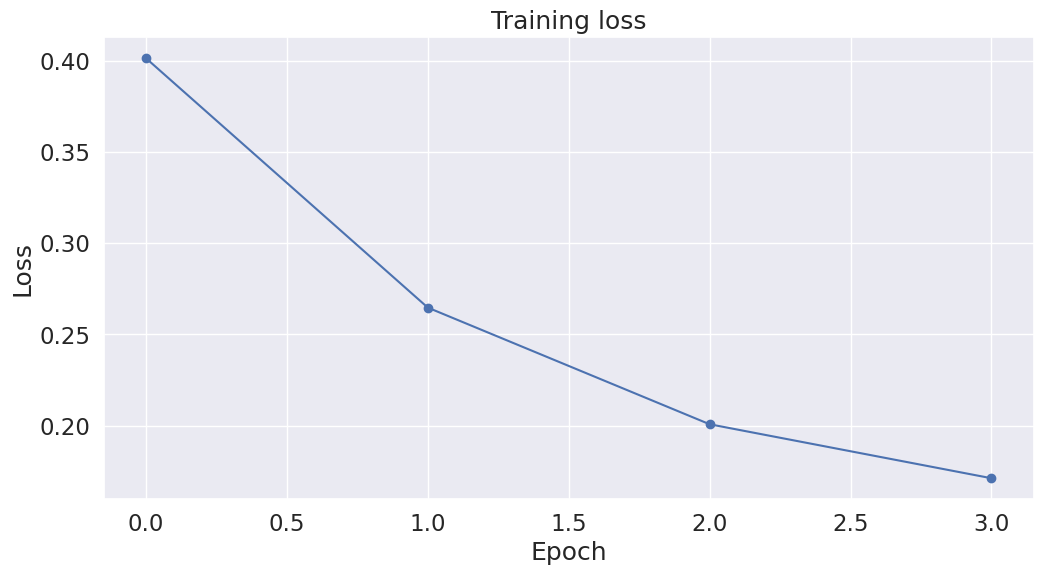

In [ ]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

#### Test

In [ ]:
tokenizer = BertTokenizer.from_pretrained('./beto-fine-tuning/')

In [ ]:
tokenizer

Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.


BertTokenizer(name_or_path='./beto-fine-tuning/', vocab_size=31002, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	5: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
test_df.iloc[0]['tweet_text']

'Qué tal si ponemos el foco aquí? ¿"Por no ser ocio nocturno"? En serio? Y no solo por una cuestión de salud pública. Por el fondo. Por eso... Tercer brote en un prostíbulo: 1.600 abiertos por no ser ocio nocturno https://t.co/MITvbXOs1H'

In [ ]:
input_ids = tokenizer.encode(test_df.iloc[502]['tweet_text'], add_special_tokens=True, truncation=True, max_length=64, padding=True, return_tensors="pt")

In [ ]:
input_ids

tensor([[    4, 19519,  1039,  1707,  1048,  1136,  7730,  1035,  1032,  1532,
         11412,  1126,  1081,  5092,     3,  1039,  1758,     3,  1008,  1091,
         10113,  1012,  1032,  7810,  1009,  1136,  2771,  3213,     3,  1032,
         15492,  5311,  1035,  1032,  6286,  1001,  1000,     3,  1147, 13656,
          6653,  1135,  1042,  2758,  4146,   995,   989,   989,  1027,  1008,
          1270,   989,  1005, 30968, 31000, 27641, 30995, 30959, 30964,   996,
         30960,     5]])

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe
df = test_df

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.tweet_text.values
labels = df.class_label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )

    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 7,976



In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 7,976 test sentences...
    DONE.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.class_label.sum(), len(df.class_label), (df.class_label.sum() / len(df.class_label) * 100.0)))

Positive samples: 1129 of 7976 (14.15%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [ ]:
matthews_set

[0.0950381926622983,
 0.0,
 0.0,
 0.0,
 0.12403473458920847,
 0.0,
 0.1210898699241207,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.08627959628145762,
 0.0,
 0.07460470969529907,
 0.6831300510639733,
 0.52678658400752,
 0.5447047794019222,
 0.26436781609195403,
 0.5447047794019222,
 1.0,
 0.6050580452280905,
 0.7453559924999299,
 0.5584155773160767,
 0.26436781609195403,
 0.6831300510639733,
 0.394853422012197,
 0.6546536707079772,
 0.52678658400752,
 0.8027729719194864,
 0.5584155773160767,
 0.7867957924694432,
 0.6831300510639733,
 0.6695340634119862,
 0.6,
 0.6,
 0.0,
 0.8783100656536799,
 0.3394221166510653,
 0.5204956780951701,
 0.30261376633440124,
 0.762962962962963,
 0.6831300510639733,
 0.5447047794019222,
 0.7142857142857143,
 0.7948717948717948,
 0.4547940268270977,
 0.7867957924694432,
 0.8027729719194864,
 0.6342857142857142,
 0.6831300510639733,
 0.7867957924694432,
 0.8171428571428572,
 0.8783100656536799,
 0.8320502943378436,
 -0.05776712868787001,
 0.8027729719194864,
 0.52678658

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.523


#### A1. Saving & Loading Fine-Tuned Model

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './beto-fine-tuning/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./beto-fine-tuning/


('./beto-fine-tuning/tokenizer_config.json',
 './beto-fine-tuning/special_tokens_map.json',
 './beto-fine-tuning/vocab.txt',
 './beto-fine-tuning/added_tokens.json')

Let's check out the file sizes, out of curiosity.

In [ ]:
!ls -l --block-size=M ./beto-fine-tuning/

total 420M
-rw------- 1 root root   1M Sep 26 18:51 config.json
-rw------- 1 root root 420M Sep 26 18:51 pytorch_model.bin
-rw------- 1 root root   1M Sep 26 18:51 special_tokens_map.json
-rw------- 1 root root   1M Sep 26 18:51 tokenizer_config.json
-rw------- 1 root root   1M Sep 26 18:51 vocab.txt


The largest file is the model weights, at around 418 megabytes.

In [ ]:
!ls -l --block-size=M ./beto-fine-tuning/pytorch_model.bin

-rw------- 1 root root 420M Sep 26 18:51 ./beto-fine-tuning/pytorch_model.bin


# Dataframes to csv

In [ ]:
# Export to csv
train_df.to_csv('data/train.csv')
dev_df.to_csv('data/dev.csv')
test_df.to_csv('data/test.csv')
complete_df.to_csv('data/complete.csv')
del aux_df
del train_df
del dev_df
del test_df
del complete_df

# Pipeline transformers

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

## EmbeddingsTransformerBase

In [ ]:
class EmbeddingsTransformerBase(BaseEstimator, TransformerMixin):
    def print_stats(self):
        total_words = sum(value[0] for value in self.words_stats.values())
        for key, value in self.words_stats.items():
            self.words_stats[key] = [value[0], str(round((value[0]/total_words) * 100, 3))+'%']
        print(self.words_stats, '\n')

## PreprocessingTransformer

In [ ]:
!python -m spacy download es_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 989.6 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import re
import spacy

In [ ]:
class PreprocessingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.nlp = spacy.load("es_core_news_lg")
        self.tokens_stats = {'USER': [0,0], 'URL': [0,0], 'HASHTAG': [0,0], 'ucc_processed_hashtags': [0,0], 'lemmatized': [0,0]}

    def fit(self,X,y=None):
        return self

    def is_hashtag_upper_camel_case(self, hashtag: str) -> bool:
        pattern = r'[A-Z][a-zA-Z\d]*'
        return re.match(pattern, hashtag) is not None and hashtag != hashtag.upper()

    def is_url(self, text: str) -> str:
        return re.match(r'https?://\S+', text) is not None

    def preprocess_tweet(self, tweet: str) -> str:
        """Function that cleans the tweet text by going to:
        - replace URLs for the special token URL
        - replace usernames for the special token USER
        - remove special characters
        - remove numbers
        - remove stopwords
        - convert to lowercase
        - remove excessive white spaces
        """
        # tokenization
        doc = self.nlp(tweet)

        tokens = []
        for token in doc:
            if token.text.startswith("@"):  # replace all user mentions with the special token "user"
                tokens.append("USER")
                self.tokens_stats['USER'][0] += 1
            elif self.is_url(token.text):
                tokens.append('URL')
                self.tokens_stats['URL'][0] += 1
            elif doc[token.i - 1].text == "#":
                if self.is_hashtag_upper_camel_case(token.text):
                    # splitting hashtags into separate words based on UpperCamelCase
                    splitted_ucc_words = re.findall(r'[A-Z][a-z\d]+', token.text)
                    #tokens.append(f'HASHTAG({len(splitted_ucc_words)})')
                    tokens.append('HASHTAG')
                    self.tokens_stats['HASHTAG'][0] += 1
                    tokens.extend(chunk.lower() for chunk in splitted_ucc_words)
                    self.tokens_stats['ucc_processed_hashtags'][0] += 1
                else:  # not UpperCamelCase
                    tokens.append(f"HASHTAG")
                    self.tokens_stats['HASHTAG'][0] += 1
            elif token.is_stop or not token.is_alpha:  # eliminación de stopwords y caracteres no alfabéticos
                continue
            else:
                tokens.append(token.lemma_.lower())  # lemmatization, case conversion
                self.tokens_stats['lemmatized'][0] += 1

        return tokens

    def print_stats(self):
        total_tokens = sum(value[0] for value in self.tokens_stats.values())
        for key, value in self.tokens_stats.items():
            self.tokens_stats[key] = [value[0], str(round((value[0]/total_tokens) * 100, 3))+'%']
        print(self.tokens_stats)

    def transform(self,X):
        '''Cada row tendrá una lista con todas las features del respectivo tweet'''
        print('********************')
        print('preprocessing...')
        to_return = pd.Series([self.preprocess_tweet(tweet) for tweet in X])
        self.print_stats()
        return to_return


### Pruebas phunspell
```
******************** hidden ********************
```

In [ ]:
pspell = phunspell.Phunspell('es')

In [ ]:
pspell.lookup('hola')

True

In [ ]:
import re
wordList = '''awesome day of my life because i am great something some
thing things unclear sun clear hola buen dia'''.split()

wordOr = '|'.join(wordList)

def splitHashTag(hashTag):
    for wordSequence in re.findall('(?:' + wordOr + ')+', hashTag):
        print(':', wordSequence)
        #for word in re.findall(wordOr, wordSequence):
        #    print(word)
        found_words = []
        buffer = ''
        for letter in wordSequence:
            buffer += letter
            if pspell.lookup(buffer):
                found_words.append(buffer)
                buffer = ''
        print(found_words)

for hashTag in '''awesome-dayofmylife iamgreat something
somethingsunclear #holabuendia #HolaBuenDia'''.split():
    print('###', hashTag)
    splitHashTag(hashTag.lower())

### awesome-dayofmylife
: awesome
['a']
: dayofmylife
['d', 'a', 'y', 'o']
### iamgreat
: iamgreat
[]
### something
: something
['so', 'me']
### somethingsunclear
: somethingsunclear
['so', 'me']
### #holabuendia
: holabuendia
['hola', 'bu', 'e']
### #HolaBuenDia
: holabuendia
['hola', 'bu', 'e']


In [ ]:
!pip install phunspell
import phunspell

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 MB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 48.1 MB/s eta 0:00:00
  Created wheel for phunspell: filename=phunspell-0.1.6-py3-none-any.whl size=47556195 sha256=1651ef78b8f6f4922d0efc4b66239a8dbe407e25c1555b2d0f953f51e27564f9
  Stored in directory: /root/.cache/pip/wheels/fd/4b/8b/24576e5451edf7f3f6b15492ace089f4f4353e6289fb923a7d
Successfully built phunspell


## Word2VecTransformer

In [ ]:
from gensim.models import Word2Vec

In [ ]:
class Word2VecTransformer(EmbeddingsTransformerBase):
    def __init__(self, feature_size=300, window_context=30, min_word_count=1, sample=1e-3, epochs=50):
        self.model = None
        self.feature_size = feature_size
        self.window_context = window_context
        self.min_word_count = min_word_count
        self.sample = sample
        self.epochs = epochs
        self.words_stats = {'present': [0,0], 'not_present': [0,0]}

    def fit(self, X, y=None):
        if self.model is None:
            print('training embedding model...')
            self.model = Word2Vec(
                                    sentences=X,
                                    vector_size=self.feature_size,
                                    window=self.window_context,
                                    min_count=self.min_word_count,
                                    sample=self.sample,
                                    epochs=self.epochs
                            )
            print('training finished.')
        else:
            print('embedding model already fitted.')

        return self

    def average_word_vectors(self, words):
        feature_vector = np.zeros((self.feature_size,),dtype="float64")
        nwords = 0.
        for word in words:
            if word in self.model.wv:
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, self.model.wv[word])
                self.words_stats['present'][0] += 1
            else:
                # print('Word not found in model', word)
                self.words_stats['not_present'][0] += 1
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)
        return feature_vector

    def transform(self, X):
        '''
        Cada row corresponderá a un tweet, y c/u de las feature_size columnas
        será una dimensión del vector (promediado de todas las palabras)
        que representa al tweet entero
        '''
        to_return = pd.DataFrame([self.average_word_vectors(tweet_features) for tweet_features in X])
        self.print_stats()
        return to_return

## WriteWordsTransformer

In [ ]:
class WriteWordsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, words_file_path):
        self.words_file_path = words_file_path

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        with open(self.words_file_path, 'w', encoding='utf-8') as file:
            for tweet in X:
                line = ' '.join(tweet)
                file.write(line + '\n')
        print('tokens txt file with one line per tweet written')
        return X

## FastTextBase

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199773 sha256=891f01cf1f41a1674fd550a414e410acd2fbb9ef533d6bd2c92fc87be3deca87
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import fasttext
import subprocess
import os

In [ ]:
class FastTextBase(BaseEstimator, TransformerMixin):
    def __init__(self, input_file, output_file, dim=300, ws=50, minCount=1, epoch=50, thread=4, t=1e-3):
        # https://fasttext.cc/docs/en/python-module.html#train_unsupervised-parameters
        self.model = None
        self.input_file = input_file  # txt file
        self.output_file = output_file  # bin file
        self.dim = dim  # feature size
        self.ws = ws  # context window
        self.minCount = minCount
        self.epoch = epoch
        self.thread = thread
        self.t = t  # sampling threshold
        self.words_stats = {'present': [0,0], 'not_present': [0,0]}

    def fit(self, X, y=None):
        if self.model is None:
            if os.path.exists(self.output_file):
                self.model = fasttext.load_model(self.output_file)
                print('existing char n-grams embeddings model has been loaded...\n')
            else:
                print('training char n-grams embeddings model...\n')
                self.model = fasttext.train_unsupervised(
                                input=self.input_file,
                                dim=self.dim,
                                ws=self.ws,
                                epoch=self.epoch,
                                minCount=self.minCount,
                                thread=self.thread,
                                t=self.t
                            )
                print('training finished.')
                self.model.save_model(self.output_file)
                print('model saved to .bin in ' + self.output_file)
                # bin_to_vec.py download (-nc para descargar solo si no existe el fichero)
                if not os.path.exists('./fasttext/bin_to_vec.py'):
                    os.makedirs('./fasttext', exist_ok=True)
                    os.chdir('./fasttext')
                    subprocess.run([
                        'wget', '-nc',
                        'https://raw.githubusercontent.com/facebookresearch/fastText/master/python/doc/examples/bin_to_vec.py'
                    ])
                    os.chdir('..')
                vec_filename = self.output_file.split('.')[0]+'.vec'
                subprocess.run(['python', './fasttext/bin_to_vec.py', self.output_file, '>', vec_filename], shell=True)
                print('model in .bin converted to .vec for potential later use as input on InferSent')
        else:
            print('embedding model already fitted.')
        return self

## FastTextTransformer

In [ ]:
class FastTextTransformer(FastTextBase, EmbeddingsTransformerBase):
    def average_word_vectors(self, words):
        feature_vector = np.zeros((self.dim,),dtype="float64")
        nwords = 0.
        for word in words:
            if word in self.model.words:
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, self.model.get_word_vector(word))
                self.words_stats['present'][0] += 1
            else:
                # print('Word not found in model', word)
                self.words_stats['not_present'][0] += 1
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)
        return feature_vector

    def transform(self, X):
        '''
        Cada row corresponderá a un tweet, y c/u de las feature_size columnas
        será una dimensión del vector (promediado de todas las palabras)
        que representa al tweet entero
        '''
        to_return = pd.DataFrame([self.average_word_vectors(tweet_features) for tweet_features in X])
        self.print_stats()
        return to_return

## FastTextWordVectors

In [ ]:
class FastTextWordVectors(FastTextBase):
    def transform(self, X):
        '''
        Aca se evita hacer cualquier transformación.
        Se entrena el modelo, se genera el .bin y
        se lo transforma a .vec para que InferSent lo use como input
        y genera los embeddings
        '''
        return X

## BetoTransformer

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer, TFBertModel
import re
import pandas as pd
import os
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
class BetoTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, embeddings_pickle, train_path, test_path):
        self.embeddings_pickle = embeddings_pickle
        self.embeddings = self.get_embeddings()
        self.model = TFBertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
        self.tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
        self.train_path = train_path
        self.test_path = test_path

    def load_embeddings(self):
        print('existing embeddings pickle file loaded for transform\n')
        return pd.read_pickle(self.embeddings_pickle)

    def get_embeddings(self):
        if os.path.exists(self.embeddings_pickle):
            embeddings = self.load_embeddings()
        else:
            train_df = pd.read_csv(self.train_path, index_col='tweet_id')
            test_df = pd.read_csv(self.test_path, index_col='tweet_id')

            train_test_instances = pd.concat([train_df, test_df], ignore_index=False)
            train_test_instances = train_test_instances['tweet_text']

            # Me deshago de las rows repetidas usando su index
            train_test_instances = train_test_instances[~train_test_instances.index.duplicated(keep='first')]
            embeddings = self.calculate_embeddings(X=train_test_instances)

            embeddings.to_pickle(self.embeddings_pickle)

        embeddings.index = embeddings.index.astype(str)
        return embeddings

    def preprocess(self, s): # remove symbols, mask URL, remove digits
        s = re.sub(r'((http|https)\:\/\/)[(\/|\-|\_)*a-zA-Z0-9|\.]+',' ',s.lower())
        # s = re.sub(r'[^a-zA-Z]|_', ' ', s) # remove symbols and digits
        s = re.sub(r'\s+', ' ', s)
        return s

    def calculate_embeddings(self, X):
        tweets = list(X.index)
        matrix = np.zeros((len(X),768)) # creamos la matrix para los embeddings

        for i in tqdm(range(0,len(X))):
            processed_tweet = self.preprocess(X.values[i])
            tokens = self.tokenizer(processed_tweet, return_tensors='tf')
            output = self.model(tokens)
            embedding = np.array(output['last_hidden_state'][0]).mean(0)
            matrix[i] = embedding

        result_df = pd.DataFrame(matrix, index=tweets)
        return result_df

    def fit(self, X, y=None):
        # BERT no requiere fit
        return self

    def transform(self, X, y=None):
        '''
        Cada row corresponderá a un tweet, y c/u de las feature_size columnas
        será una dimensión del vector (promediado de todas las palabras)
        que representa al tweet entero
        '''
        result_df = pd.DataFrame()

        X.index = X.index.astype(str)
        for index, value in X.items():
            if index in self.embeddings.index:
                row = self.embeddings.loc[index]
                result_df = pd.concat([result_df, row.to_frame().T])
            else:
                print(f'embedding for tweet {index} not found')

        result_df.index = X.index

        return result_df

## InfersentTransformer

In [ ]:
!wget https://github.com/facebookresearch/InferSent/archive/refs/heads/main.zip
!unzip -n main.zip
!rm main.zip
!mv InferSent-main InferSent

--2024-03-06 15:03:53--  https://github.com/facebookresearch/InferSent/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/InferSent/zip/refs/heads/main [following]
--2024-03-06 15:03:53--  https://codeload.github.com/facebookresearch/InferSent/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [  <=>               ] 269.30K  1.08MB/s    in 0.2s    

2024-03-06 15:03:54 (1.08 MB/s) - ‘main.zip’ saved [275764]

Archive:  main.zip
31eede6b3543571951276cbbf7040b4f8479985a
   creating: InferSent-main/
  inflating: InferSent-main/.gitignore 

In [ ]:
from InferSent.models import InferSent
import torch
import subprocess

In [ ]:
class InferSentTransformer(EmbeddingsTransformerBase):
    def __init__(self, w2v_path='fasttext_vectors.vec', bsize=64, word_emb_dim=300, enc_lstm_dim=2048, pool_type='max', dpout_model=0.0, model_version=2):
        self.model = None
        subprocess.run([
            'curl', '-Lo', f'encoder/infersent{model_version}.pkl',
            f'https://dl.fbaipublicfiles.com/infersent/infersent{model_version}.pkl'
        ])
        self.model_path = "encoder/infersent%s.pkl" % model_version  # 1 glove, 2 fasttext
        self.w2v_path = w2v_path
        self.bsize = bsize
        self.word_emb_dim = word_emb_dim
        self.enc_lstm_dim = enc_lstm_dim
        self.pool_type = pool_type
        self.dpout_model = dpout_model
        self.model_version = model_version  # Version 2 for a FastText input (.vec file)
        self.words_stats = {'present': [0,0], 'not_present': [0,0]}

    def fit(self, X, y=None):
        if self.model is None:
            sentences = [' '.join(tweet_tokens) for tweet_tokens in X]
            print('training embedding model...')
            params_model = {
                'bsize': self.bsize,
                'word_emb_dim': self.word_emb_dim,
                'enc_lstm_dim': self.enc_lstm_dim,
                'pool_type': self.pool_type,
                'dpout_model': self.dpout_model,
                'version': self.model_version
            }
            self.model = InferSent(params_model)
            self.model.load_state_dict(torch.load(self.model_path))
            self.model.set_w2v_path(self.w2v_path)
            self.model.build_vocab(sentences, tokenize=False)
            print('training finished.')
        else:
            print('embedding model already fitted.')
        return self

    def average_word_vectors(self, words):
        feature_vector = np.zeros((self.word_emb_dim,),dtype="float64")
        nwords = 0.
        for word in words:
            if word in self.model.word_vec:
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, self.model.word_vec[word])
                self.words_stats['present'][0] += 1
            else:
                self.words_stats['not_present'][0] += 1
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)
        return feature_vector

    def transform(self, X):
        '''
        Cada row corresponderá a un tweet, y c/u de las feature_size columnas
        será una dimensión del vector (promediado de todas las palabras)
        que representa al tweet entero
        '''
        to_return = pd.DataFrame([self.average_word_vectors(tweet_features) for tweet_features in X])
        self.print_stats()
        return to_return

## BetoFineTuningTransformer

In [ ]:
!pip install transformers

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from transformers import BertTokenizer

In [ ]:
class BetoFineTuningTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model_path):
        self.model_path = model_path
        self.tokenizer = BertTokenizer.from_pretrained(self.model_path)

    def fit(self, X, y=None):
        # BERT no requiere fit
        return self

    def transform(self, X, y=None):
        '''
        '''
        # Set the maximum sequence length.
        # I've chosen 350 somewhat arbitrarily. It's slightly larger than the
        # maximum training sentence length of 328...
        MAX_LEN = 350

        # Tokenize all of the sentences and map the tokens to thier word IDs.
        input_ids = []

        # For every sentence...
        for index, tweet in X.items():
            # `encode` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            encoded = self.tokenizer.encode(
                                tweet,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                )
            input_ids.append(encoded)

        # Pad our input tokens
        input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                                dtype="long", truncating="post", padding="post")

        # Create attention masks
        attention_masks = []

        # Create a mask of 1s for each token followed by 0s for padding
        for seq in input_ids:
            seq_mask = [float(i>0) for i in seq]
            attention_masks.append(seq_mask)

        # Convert to tensors.
        prediction_inputs = torch.tensor(input_ids)
        prediction_masks = torch.tensor(attention_masks)

        # Set the batch size.
        batch_size = 32

        # Create the DataLoader.
        prediction_data = TensorDataset(prediction_inputs, prediction_masks)
        prediction_sampler = SequentialSampler(prediction_data)
        prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

        return (prediction_data, prediction_sampler, prediction_dataloader)

## BetoFineTuningClassifier

In [ ]:
from transformers import BertForSequenceClassification
import tensorflow as tf
import torch

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [ ]:
class BetoFineTuningClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model_path):
        self.model_path = model_path
        # Load a trained model and vocabulary that you have fine-tuned
        self.model = BertForSequenceClassification.from_pretrained(self.model_path)
        # Tell pytorch to run this model on the GPU.
        self.model.cuda()
        # Put model in evaluation mode
        self.model.eval()
        self.device = self.init_device()

    def init_device(self):
        # If there's a GPU available...
        if torch.cuda.is_available():

            # Tell PyTorch to use the GPU.
            device = torch.device("cuda")

            print('There are %d GPU(s) available.' % torch.cuda.device_count())

            print('We will use the GPU:', torch.cuda.get_device_name(0))

        # If not...
        else:
            print('No GPU available, using the CPU instead.')
            device = torch.device("cpu")

        return device

    def fit(self, X, y=None):
        # BERT no requiere fit
        self.classes_ = list(set(y))
        return self

    def predict(self, X):
        # Prediction on test set

        # Put model in evaluation mode
        self.model.eval()

        # Tracking variables
        predictions = []

        # Predict
        for batch in X[2]:  # for batch in prediction_dataloader
            # Add batch to GPU
            batch = tuple(t.to(self.device) for t in batch)

            # Unpack the inputs from our dataloader
            b_input_ids, b_input_mask = batch

            # Telling the model not to compute or store gradients, saving memory and
            # speeding up prediction
            with torch.no_grad():
                # Forward pass, calculate logit predictions
                outputs = self.model(b_input_ids, token_type_ids=None,
                                attention_mask=b_input_mask)

            logits = outputs[0]
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()

            # Store predictions and true labels
            predictions.append(logits)

        print('    DONE.')

        # Combine the predictions for each batch into a single list of 0s and 1s.
        flat_predictions = [item for sublist in predictions for item in sublist]
        flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
        print(f'{len(flat_predictions)} predictions done.')

        return flat_predictions

## GPTClassifier

In [ ]:
!pip install --upgrade openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00


In [ ]:
import os
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [ ]:
from openai import OpenAI, OpenAIError
import json
import time
from tqdm.notebook import tqdm
import os
import re

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [ ]:
class GPTClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model='gpt-3.5-turbo', temperature=.5, max_tokens=180, top_p=1, frequency_penalty=0, presence_penalty=0, stop=["12."]):
        self.client = OpenAI(api_key=OPENAI_API_KEY)
        self.model = model
        self.temperature = temperature
        self.max_tokens = max_tokens
        self.top_p = top_p
        self.frequency_penalty = frequency_penalty
        self.presence_penalty = presence_penalty
        self.stop = stop
        self.RESULTS_FILENAME = "data/gpt_predictions.json"
        self.gpt_predictions = self.load_create_or_save_gpt_results()


    def fit(self, X, y=None):
        self.classes_ = list(set(y))
        return self

    def load_create_or_save_gpt_results(self, gpt_results:dict=None):
        if gpt_results:  # si vino uno, lo guardo
            with open(self.RESULTS_FILENAME, 'w') as file:
                json.dump(gpt_results, file, indent=4)
            print('\nArchivo de resultados GPT guardado')
            return None

        if os.path.exists(self.RESULTS_FILENAME):  # if exists, load
            with open(self.RESULTS_FILENAME, 'r') as file:
                results = json.load(file)
            print('\nArchivo de resultados GPT cargado')
        else:  # if not exists, create
            results = {}
            print('Diccionario de resultados GPT creado')

        return results

    def predict(self, X):
        '''
        Cada row corresponderá a un tweet, y c/u de las feature_size columnas
        será una dimensión del vector (promediado de todas las palabras)
        que representa al tweet entero
        '''
        # InvalidRequestError: This model's maximum context length is 4097 tokens.
        # However, your messages resulted in 8871 tokens. Please reduce the length of the messages.
        CHUNK_SIZE = 20
        #to_return = []

        # Primero elimino de la Series a evaluar, todas aquellas instancias que ya tienen prediccion
        X_to_predict = X.drop(index=self.gpt_predictions.keys(), errors='ignore')  # If 'ignore', suppress error and only existing labels are dropped.

        for start in range(0, len(X_to_predict), CHUNK_SIZE):
            end = start + CHUNK_SIZE
            chunk = X_to_predict[start:end]

            #chunk_index = X_to_predict.index[i:i + CHUNK_SIZE]
            #chunk = X_to_predict.values[i:i + CHUNK_SIZE]

            # Si en este chunk ya fueron predichas todas las frases, paso al proximo chunk
            #if all(index in self.gpt_predictions for index in chunk_index):
            #    continue

            frases_str = ""
            for idx, frase in enumerate(chunk, start=1):
                frases_str += f"Tweet {idx}:\n{frase.strip()}\n\n"

            # Predichas como 0 y eran 1
            check_worthy = [
                "💬 @Aglezterol: “Ninguna de las CC.AA. consultadas ha recibido ni un euro de los fondos prometidos. Además de ser unos fondos ‘bulo’, son insuficientes👉 si usted divide los 625 mill/€ entre los 47 mill. de habitantes, tocan a cada español 13,29€"".  🔴 ¿Creen que es suficiente? https://t.co/1ngXCWXUkf",
                "➡ ""Bajada de impuestos"" de la señora Ayuso: 16 millones de euros.  ➡ Dinero destinado a los menas: 24 millones de euros.  Se ríen de nosotros. https://t.co/8kwEAtYeS8",
                "❌Lo vuelven a hacer.   💶Récord de inflación con subidas históricas en el precio de la luz, combustible y cesta de la compra  ⤵️Recuperación más lenta de la UE  😡Paro juvenil más alto de Europa.  📉Subidas de cotizaciones para los trabajadores, empresas y autónomos  @GPPopular https://t.co/VmRxmRJRda"
            ]

            # Predichas como 1 y eran 0
            non_check_worthy = [
                "320 cargos públicos imputados por corrupción en el caso ERE.  7 ex-consejeros y 85 alcaldes o ex-alcaldes imputados.  Más de 1.000 imputados relacionados con su partido.  -106 casos de corrupción abiertos.  Y Chaves tiene la poca vergüenza de abandonar la sala.  Esto es el @PSOE. https://t.co/EdEaDJ3dFN",
                "ONG europeas valoran positivamente estrategia española para descarbonización. https://t.co/I8V90NcDye",
                "Pacto de Estado contra la violencia de género: ¿Qué ha cambiado? @elmundoes https://t.co/zIMlrUEQgD"
            ]

            prompt_template = '''Una frase que vale la pena chequear es aquella que amerita ser chequeada en términos de su probable falsedad en la información, su potencial impacto negativo en la sociedad, individuos, compañías o productos, su relevancia general y la necesidad de la intervención de un profesional que se ocupe de chequearla. Por ejemplo, las frases:\n{check_worthy}\n merecen ser chequedas, mientras que las frases\n{non_check_worthy}\nno merecen ser chequeadas. En ese contexto, vale la pena chequear los siguientes tweets? Necesito que respondas EXACTAMENTE {cantidad_frases} pares numero_de_tweet:calificacion, una para cada tweet (por ejemplo, 5:0 si el tweet 5 lleva calificacion 0), separados por comas, considerando 1 (afirmativo) o 0 (negativo).\n\n{frases}'''
            #prompt_template = '''Una frase que vale la pena chequear es aquella que amerita ser chequeada en términos de su probable falsedad en la información, su potencial impacto negativo en la sociedad, individuos, compañías o productos, su relevancia general y la necesidad de la intervención de un profesional que se ocupe de chequearla. En ese contexto, vale la pena chequear los siguientes tweets? Necesito que respondas EXACTAMENTE {cantidad_frases} caracteres separados por comas: 1 (afirmativo) o 0 (negativo).\n\n{frases}'''
            msg_content = prompt_template.format(
                check_worthy=",\n".join(['"' + frase + '"' for frase in check_worthy]),
                non_check_worthy=",\n".join(['"' + frase + '"' for frase in non_check_worthy]),
                cantidad_frases=str(len(chunk)),
                frases=frases_str
            )

            print(f'pos general (de las que restan predecir) {start} de {len(X.values)}')
            print('msg_content')
            print(msg_content)

            p_c = [
                {
                    "role": "user",  # explicacion de frase check-worthy extraido casi textual de la pagina 5 boceto
                    "content": msg_content
                }
            ]

            flag = False
            while not flag:
                try:
                    response = self.client.chat.completions.create(
                        model=self.model,
                        messages=p_c,
                        temperature=self.temperature,
                        max_tokens=self.max_tokens,
                        top_p=self.top_p,
                        frequency_penalty=self.frequency_penalty,
                        presence_penalty=self.presence_penalty,
                        #stop=self.stop
                    )
                    flag = True
                except OpenAIError as e:
                    #Handle API error here, e.g. retry or log
                    print(f"OpenAI API returned an API Error: {e}")
                    time.sleep(20)
                    print('Retrying...')

            response_content = response.choices[0].message.content
            print(response_content)
            chunk_labels = response_content.split('\n') if '\n' in response_content else response_content.split(',')
            print(chunk_labels)
            chunk_labels = [pair.split(':')[-1].strip() for pair in chunk_labels]
            chunk_labels = [re.search(r'\d+', to_cast_str).group() for to_cast_str in chunk_labels]
            try:
                chunk_labels = [int(label) for label in chunk_labels]
            except:
                import pdb; pdb.set_trace()
            print(chunk_labels)

            labeled_chunk = pd.Series(chunk_labels, index=chunk.index)
            self.gpt_predictions.update(labeled_chunk.to_dict())
            if any(not isinstance(value, int) for value in gpt_predictions.values()):
                import pdb; pdb.set_trace()
            self.load_create_or_save_gpt_results(self.gpt_predictions)

            print('labels obtenidos hasta el momento:', len(self.gpt_predictions), '\n', '\n')
            time.sleep(5) # hay un rate limit, esto es porque originalmente lo tenía en un ciclo

        X_predictions = pd.Series(index=X.index, dtype='int')
        X_predictions.update(pd.Series(self.gpt_predictions))

        return X_predictions

# Training, Estimation & Evaluation

## Generic metrics

In [ ]:
from IPython.display import display, Markdown

In [ ]:
def generate_show_md_table(tabla, titulo):
    titulo_md = f"# {titulo}\n\n"
    tabla_md = "|".join(tabla[0]) + "\n" + "|".join(["---"] * len(tabla[0])) + "\n" + "\n".join(["|".join(map(str, fila)) for fila in tabla[1:]])
    display(Markdown(titulo_md + tabla_md))

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score, matthews_corrcoef

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
def generate_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=labels
    )
    disp.plot(cmap='Blues')
    plt.show()

In [ ]:
def run_metrics(y_true, y_pred, classes):
    generate_confusion_matrix(y_true, y_pred, classes)
    print('\n')

    metrics_results = {
        'precision': precision_score(y_true, y_pred),  # default=binary  # tp / (tp + fp)
        'precision_weighted': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred),  # default=binary  # tp / (tp + fn)
        'f1': f1_score(y_true, y_pred),  # es default=binary  # 2 * (precision * recall) / (precision + recall)
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),  # 2 * (precision * recall) / (precision + recall)
        'accuracy': accuracy_score(y_true, y_pred),  # (tp + tn) / (tp + fp + tn + fn)
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),  # 1/2 [tp/(tp+fn) + tn/(tn+fp)]
        'matthews_corrcoef': matthews_corrcoef(y_true, y_pred)  # Matthews correlation coefficient  # (tp*tn-fp*fn)/[(tp+fp)(tp+fn)(tn+fp)(fn+fn)]^1/2
    }

    tabla = [
        metrics_results.keys(),
        metrics_results.values()
    ]

    generate_show_md_table(tabla, titulo='Metricas Testing')

    metrics_results = {key: str(value) for key, value in metrics_results.items()}
    return metrics_results

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
def run_metrics_cv(estimator, X, y, cv=10):

    metrics_cv_results = {
        'precision': None,
        'precision_weighted': None,
        'recall': None,
        'f1': None,
        'f1_weighted': None,
        'accuracy': None,
        'balanced_accuracy': None,
        'matthews_corrcoef': None,
    }

    print('running k-fold cross validation k=10')
    scores = cross_validate(estimator, X, y, scoring=list(metrics_cv_results.keys()), cv=cv)

    metrics_cv_results = {key: scores['test_'+key] for key, value in metrics_cv_results.items()}

    averages = [f'mean: {np.mean(k_fold_scores):.8f}' for k_fold_scores in metrics_cv_results.values()]
    metrics_cv_results = {key: {'scores': value.tolist(), 'mean': np.mean(value), 'std': np.mean(value)} for key, value in metrics_cv_results.items()}

    scores = [metric['scores'] for metric in metrics_cv_results.values()]
    tabla = [list(metrics_cv_results.keys())] + [list(k_fold_scores) for k_fold_scores in zip(*scores)] + [averages]

    generate_show_md_table(tabla, titulo='Metricas K-Fold Cross Validation')
    print()

    return metrics_cv_results

## Generic estimation

In [7]:
import os
import json

def load_create_or_save_results(results_filename, final_results:dict=None):
    if final_results:  # si vino uno, lo guardo
        with open(results_filename, 'w') as file:
            json.dump(final_results, file, indent=4)
        print(f'\nArchivo de resultados guardado en {results_filename}')
        return None

    if os.path.exists(results_filename):  # if exists, load
        with open(results_filename, 'r') as file:
            results = json.load(file)
        print(f'\nArchivo de resultados cargado desde {results_filename}')
    else:  # if not exists, create
        results = {}
        print('Diccionario de resultados creado')

    return results

In [8]:
final_results = load_create_or_save_results(results_filename="data/final_results.json")


Archivo de resultados cargado desde data/final_results.json


In [9]:
final_results

{'random': {'precision': '0.1412904871206325',
  'precision_weighted': '0.7567214984235856',
  'recall': '0.49069973427812225',
  'f1': '0.2194059405940594',
  'f1_weighted': '0.5791043887505298',
  'accuracy': '0.5057673019057172',
  'balanced_accuracy': '0.49947576169141983',
  'matthews_corrcoef': '-0.0007310751699104152'},
 'majority': {'precision': '0.0',
  'precision_weighted': '0.7369370052232928',
  'recall': '0.0',
  'f1': '0.0',
  'f1_weighted': '0.7930661207125391',
  'accuracy': '0.8584503510531595',
  'balanced_accuracy': '0.5',
  'matthews_corrcoef': '0.0'},
 'svc_tfidf': {'precision': '0.475',
  'precision_weighted': '0.8548668141378089',
  'recall': '0.5048715677590788',
  'f1': '0.489480463718334',
  'f1_weighted': '0.8528115651671134',
  'accuracy': '0.8509277833500501',
  'balanced_accuracy': '0.7064302340036814',
  'matthews_corrcoef': '0.4025530428270448'},
 'svc_w2vec': {'precision': '0.4665991902834008',
  'precision_weighted': '0.8424359353636854',
  'recall': '

In [19]:
final_results_cv = load_create_or_save_results(results_filename="data/final_results_cv.json")


Archivo de resultados cargado desde data/final_results_cv.json


In [20]:
final_results_cv

{'random': {'precision': {'scores': [0.16533333333333333,
    0.1548731642189586,
    0.18691588785046728,
    0.157543391188251,
    0.1588785046728972,
    0.1588785046728972,
    0.17222963951935916,
    0.16688918558077437,
    0.17757009345794392,
    0.16154873164218958],
   'mean': 0.16606604361370716,
   'std': 0.00963279399793633},
  'precision_weighted': {'scores': [0.7255635555555556,
    0.7164190338433604,
    0.7484260451931609,
    0.7190862847891771,
    0.7188581214059634,
    0.7188581214059634,
    0.7321943880106393,
    0.7268598813687689,
    0.7375288946525097,
    0.7215253747268984],
   'mean': 0.7265319700951997,
   'std': 0.009664071694632253},
  'recall': {'scores': [0.5020242914979757,
    0.4715447154471545,
    0.5691056910569106,
    0.4796747967479675,
    0.4817813765182186,
    0.4817813765182186,
    0.5222672064777328,
    0.5060728744939271,
    0.5384615384615384,
    0.4898785425101215],
   'mean': 0.5042592409729766,
   'std': 0.0293246972306852

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import clone

In [ ]:
import os
import pickle
import joblib

In [ ]:
def run_estimation(estimator, data_fpath, test_fpath, complete_fpath, results_fpath, model_name):
    '''Works for every pipeline, single classifier or ensemble received by parameter.'''
    excepted_models = ['fasttext', 'infersent', '_beto', 'gpt']
    model_path = f'./models/{model_name}.pkl'

    # K=10 fold Cross validation
    complete_df = pd.read_csv(complete_fpath, index_col='tweet_id')
    cloned_clean_estimator = clone(estimator)
    final_results_cv[model_name] = run_metrics_cv(cloned_clean_estimator, complete_df['tweet_text'], complete_df['class_label'])

    train_df = pd.read_csv(data_fpath, index_col='tweet_id')

    # si esta exento o si no existe, lo tengo que entrenar
    if any(excepted_model in model_name for excepted_model in excepted_models) or not os.path.exists(model_path):
        estimator.fit(train_df['tweet_text'], train_df['class_label'])
        # si no esta exento y no existe, lo tengo que guardar
        if not any(excepted_model in model_name for excepted_model in excepted_models) and not os.path.exists(model_path):
            print(f'Dumping using pickle -> {model_path}')
            with open(model_path, 'wb') as file:
                pickle.dump(estimator, file)
            print(f'Saved model! {model_path}\n')
    else: # no esta exento y existe
        print(f'Loading using pickle -> {model_path}')
        with open(model_path, 'rb') as file:
            estimator = pickle.load(file)
        print(f'Loaded existing fitted model! {model_path}\n')

    test_df = pd.read_csv(test_fpath, index_col='tweet_id')

    with open(results_fpath, "w") as results_file:
        original_index = test_df.index
        predicted = estimator.predict(test_df['tweet_text'])
        predicted = pd.Series(predicted, index=original_index)

        results_file.write("tweet_id\tclass_label\trun_id\n")

        for i, line in test_df.iterrows():
            label = predicted[i]
            results_file.write("{}\t{}\t{}\n".format(i, label, model_name))

    final_results[model_name] = run_metrics(test_df['class_label'], predicted, estimator.classes_)

    load_create_or_save_results(final_results=final_results_cv, results_filename="data/final_results_cv.json")
    load_create_or_save_results(final_results=final_results, results_filename="data/final_results.json")

## Random baseline

In [ ]:
from sklearn.dummy import DummyClassifier

running k-fold cross validation k=10


# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.16533333333333333|0.7255635555555556|0.5020242914979757|0.24874623871614845|0.5639297596567369|0.5006666666666667|0.5012116668982296|0.0017975293401256247
0.1548731642189586|0.7164190338433604|0.4715447154471545|0.23316582914572867|0.5557406599645589|0.49099399599733157|0.4831785827834336|-0.024920923199643733
0.18691588785046728|0.7484260451931609|0.5691056910569106|0.2814070351758794|0.5836888229025682|0.5230153435623749|0.5415360857519189|0.06153569522180111
0.157543391188251|0.7190862847891771|0.4796747967479675|0.23718592964824123|0.5580696735427263|0.49366244162775186|0.4880417080308074|-0.017716204997856665
0.1588785046728972|0.7188581214059634|0.4817813765182186|0.23895582329317266|0.5583643244292513|0.4943295530353569|0.4892932441696525|-0.015887918186840766
0.1588785046728972|0.7188581214059634|0.4817813765182186|0.23895582329317266|0.5583643244292513|0.4943295530353569|0.4892932441696525|-0.015887918186840766
0.17222963951935916|0.7321943880106393|0.5222672064777328|0.2590361445783133|0.5700169807767643|0.5076717811874583|0.5135297693730517|0.020077031015929253
0.16688918558077437|0.7268598813687689|0.5060728744939271|0.25100401606425704|0.5653559182377592|0.5023348899266178|0.503835159291692|0.005691051334821246
0.17757009345794392|0.7375288946525097|0.5384615384615384|0.26706827309236947|0.5746780433157697|0.5130086724482988|0.5232243794544114|0.034463010697037263
0.16154873164218958|0.7215253747268984|0.4898785425101215|0.2429718875502008|0.5606948556987539|0.4969979986657772|0.4941405492103323|-0.00869492834628676
mean: 0.16606604|mean: 0.72653197|mean: 0.50425924|mean: 0.24984970|mean: 0.56489034|mean: 0.50170109|mean: 0.50272844|mean: 0.00404564


Loading using pickle -> ./models/random.pkl
Loaded existing fitted model! ./models/random.pkl



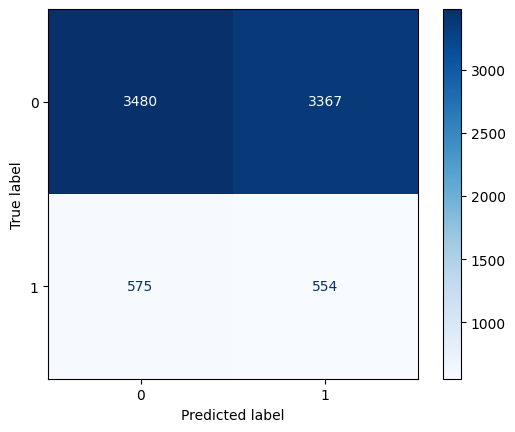

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.1412904871206325|0.7567214984235856|0.49069973427812225|0.2194059405940594|0.5791043887505298|0.5057673019057172|0.49947576169141983|-0.0007310751699104152


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
run_estimation(
    estimator=DummyClassifier(strategy="uniform", random_state=44),
    data_fpath='data/test.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_random.csv',
    model_name='random'
)

## Majority baseline

running k-fold cross validation k=10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is i

# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.0|0.6977817777777778|0.0|0.0|0.7603869717883522|0.8353333333333334|0.5|0.0
0.0|0.6987130846848756|0.0|0.0|0.7611707223420265|0.8358905937291528|0.5|0.0
0.0|0.6987130846848756|0.0|0.0|0.7611707223420265|0.8358905937291528|0.5|0.0
0.0|0.6987130846848756|0.0|0.0|0.7611707223420265|0.8358905937291528|0.5|0.0
0.0|0.6975982654213326|0.0|0.0|0.7602324971767196|0.8352234823215477|0.5|0.0
0.0|0.6975982654213326|0.0|0.0|0.7602324971767196|0.8352234823215477|0.5|0.0
0.0|0.6975982654213326|0.0|0.0|0.7602324971767196|0.8352234823215477|0.5|0.0
0.0|0.6975982654213326|0.0|0.0|0.7602324971767196|0.8352234823215477|0.5|0.0
0.0|0.6975982654213326|0.0|0.0|0.7602324971767196|0.8352234823215477|0.5|0.0
0.0|0.6975982654213326|0.0|0.0|0.7602324971767196|0.8352234823215477|0.5|0.0
mean: 0.00000000|mean: 0.69795106|mean: 0.00000000|mean: 0.00000000|mean: 0.76052941|mean: 0.83543460|mean: 0.50000000|mean: 0.00000000


Loading using pickle -> ./models/majority.pkl
Loaded existing fitted model! ./models/majority.pkl



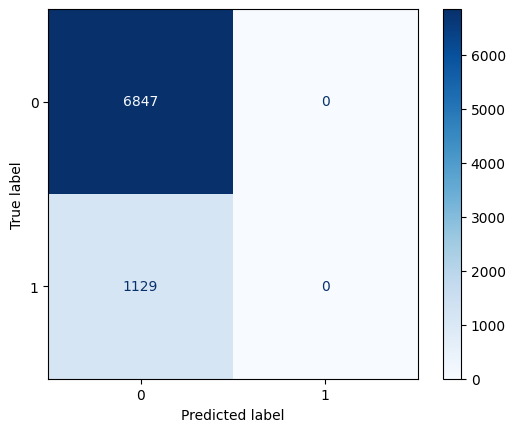

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.0|0.7369370052232928|0.0|0.0|0.7930661207125391|0.8584503510531595|0.5|0.0


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
run_estimation(
    estimator=DummyClassifier(strategy="most_frequent"),
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_majority.csv',
    model_name='majority'
)

## Beto Fine Tuning
```
Al principio pq necesita GPU, y si va a lo último puede fallar porque Colab la desactiva después de un tiempo si está inactiva
```

In [ ]:
beto_fine_tuning_pipeline = Pipeline([
    ('generate_embeddings', BetoFineTuningTransformer(model_path='./beto_fine_tuning/',)),
    ('clf', BetoFineTuningClassifier(model_path='./beto_fine_tuning/'))
])

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


There are 1 GPU(s) available.
We will use the GPU: Tesla T4


There are 1 GPU(s) available.
We will use the GPU: Tesla T4
There are 1 GPU(s) available.
We will use the GPU: Tesla T4
running k-fold cross validation k=10
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Token indices sequence length is longer than the specified maximum sequence length for this model (3365 > 512). Running this sequence through the model will result in indexing errors


    DONE.
1500 predictions done.
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Token indices sequence length is longer than the specified maximum sequence length for this model (3365 > 512). Running this sequence through the model will result in indexing errors


    DONE.
1499 predictions done.
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Token indices sequence length is longer than the specified maximum sequence length for this model (3365 > 512). Running this sequence through the model will result in indexing errors


    DONE.
1499 predictions done.
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Token indices sequence length is longer than the specified maximum sequence length for this model (3365 > 512). Running this sequence through the model will result in indexing errors


    DONE.
1499 predictions done.
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Token indices sequence length is longer than the specified maximum sequence length for this model (888 > 512). Running this sequence through the model will result in indexing errors


    DONE.
1499 predictions done.
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Token indices sequence length is longer than the specified maximum sequence length for this model (3365 > 512). Running this sequence through the model will result in indexing errors


    DONE.
1499 predictions done.
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Token indices sequence length is longer than the specified maximum sequence length for this model (3365 > 512). Running this sequence through the model will result in indexing errors


    DONE.
1499 predictions done.
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Token indices sequence length is longer than the specified maximum sequence length for this model (3365 > 512). Running this sequence through the model will result in indexing errors


    DONE.
1499 predictions done.
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Token indices sequence length is longer than the specified maximum sequence length for this model (3365 > 512). Running this sequence through the model will result in indexing errors


    DONE.
1499 predictions done.
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Token indices sequence length is longer than the specified maximum sequence length for this model (3365 > 512). Running this sequence through the model will result in indexing errors


    DONE.
1499 predictions done.


# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.262208067940552|0.878510261854211|1.0|0.41547518923465093|0.5831758200710019|0.5366666666666666|0.7226656025538707|0.34171542968519664
0.9799196787148594|0.9953672054462009|0.991869918699187|0.9858585858585858|0.9953415724851042|0.9953302201467645|0.9939397478571752|0.983087966998
0.9759036144578314|0.9940394190504513|0.9878048780487805|0.9818181818181818|0.9940105931951341|0.9939959973315544|0.9915081852334884|0.9782484294497081
0.9529411764705882|0.990261391081855|0.9878048780487805|0.9700598802395209|0.9900651755170083|0.989993328885924|0.9891139314425865|0.9642792853241321
0.9083969465648855|0.9788291599716377|0.9635627530364372|0.9351669941060904|0.9782433689253461|0.9779853235490327|0.9721967119814774|0.9225036643149307
0.7610921501706485|0.9440122336268032|0.902834008097166|0.8259259259259258|0.9393756683201613|0.9372915276851234|0.9234617324830878|0.7922957797901602
0.7033898305084746|0.8975602076841167|0.6720647773279352|0.6873706004140787|0.8983393975918278|0.8992661774516344|0.8080771170984724|0.6275992292954722
0.785|0.9067053709401339|0.6356275303643725|0.7024608501118568|0.9074269751696298|0.9112741827885257|0.8006412412205248|0.6560087303693224
0.6798029556650246|0.8769926266399011|0.5587044534412956|0.6133333333333333|0.8792499587200816|0.8839226150767178|0.7533937602669737|0.5494472870274266
0.7169811320754716|0.8917130535064504|0.6153846153846154|0.6623093681917213|0.8933680773403033|0.8965977318212142|0.7837306463504548|0.6041289952003577
mean: 0.77256356|mean: 0.93539909|mean: 0.83156578|mean: 0.77797789|mean: 0.90585966|mean: 0.90223238|mean: 0.87387287|mean: 0.74193148


Loading using pickle -> ./models/beto_fine_tuning.pkl
Loaded existing fitted model! ./models/beto_fine_tuning.pkl

    DONE.
7976 predictions done.


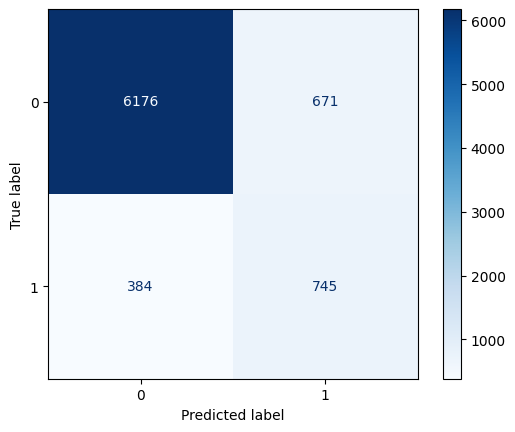

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.5261299435028248|0.8826731075996351|0.6598759964570416|0.5854616895874262|0.8737705865865772|0.867728184553661|0.7809384363766149|0.5125718425647104


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
run_estimation(
    estimator=beto_fine_tuning_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_beto_fine_tuning.csv',
    model_name='beto_fine_tuning'
)

## SVM

In [ ]:
from sklearn.svm import SVC

### w/ vectors

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

running k-fold cross validation k=10


# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.3006134969325153|0.8022098916013827|0.5951417004048583|0.39945652173913043|0.7380286462334203|0.7053333333333334|0.6610983841210245|0.25492661818522855
0.7222222222222222|0.8470356311983401|0.26422764227642276|0.3869047619047619|0.8346995560633852|0.8625750500333556|0.6221377636761204|0.3808432804011294
0.6397058823529411|0.8433619982121494|0.35365853658536583|0.45549738219895286|0.8441797496370632|0.8612408272181454|0.6572761956669846|0.4056193811687751
0.75|0.8523388377510356|0.2682926829268293|0.39520958083832336|0.8373661088235276|0.8652434956637759|0.6253674108967746|0.3950507572554044
0.7216494845360825|0.8486888960676295|0.2834008097165992|0.40697674418604657|0.838084148771935|0.8639092728485657|0.6309176572544657|0.39483804045206694
0.8369565217391305|0.8722188462260688|0.3117408906882591|0.4542772861356932|0.8519670142504927|0.8765843895930621|0.6498800300086663|0.4633225583218077
0.8152173913043478|0.8674495078133628|0.30364372469635625|0.44247787610619466|0.8487663010450979|0.8739159439626417|0.6450327249679864|0.4483381352983794
0.8762886597938144|0.8831058580920991|0.3441295546558704|0.4941860465116278|0.8618953033642976|0.8839226150767178|0.6672724450595646|0.5044814107891595
0.8192771084337349|0.8646384817886669|0.27530364372469635|0.4121212121212121|0.8423992382485451|0.8705803869246164|0.631661406526885|0.42713824033258097
0.8780487804878049|0.8767549079400152|0.291497975708502|0.4376899696048632|0.8494515386009103|0.8765843895930621|0.6417553776306089|0.46251766949863377
mean: 0.73599795|mean: 0.85578029|mean: 0.32910372|mean: 0.42847974|mean: 0.83468376|mean: 0.85398897|mean: 0.64323994|mean: 0.41370761


Loaded existing fitted model! ./models/svc_tfidf.pkl



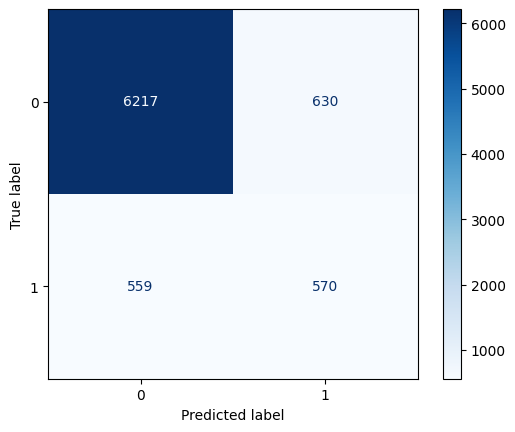

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.475|0.8548668141378089|0.5048715677590788|0.489480463718334|0.8528115651671134|0.8509277833500501|0.7064302340036814|0.4025530428270448


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
svc_tfidf_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 1),lowercase=True,use_idf=True,max_df=0.95, min_df=3,max_features=5000)),  # (1, 1) means only unigrams
    ('clf', SVC(C=1, gamma='scale', kernel='linear', random_state=0))
])
run_estimation(
    estimator=svc_tfidf_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_svc_tfidf.csv',
    model_name='svc_tfidf'
)

### w/ embeddings

#### Word2vec

********************
preprocessing...
{'USER': [9884, '4.771%'], 'URL': [13093, '6.321%'], 'HASHTAG': [6813, '3.289%'], 'ucc_processed_hashtags': [4787, '2.311%'], 'lemmatized': [172570, '83.308%']}
training embedding model...
training finished.
{'present': [212086, '100.0%'], 'not_present': [0, '0.0%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
{'present': [237912, '99.361%'], 'not_present': [1530, '0.639%']} 

********************
preprocessing...
{'USER': [9612, '4.612%'], 'URL': [13073, '6.272%'], 'HASHTAG': [6753, '3.24%'], 'ucc_processed_hashtags': [4761, '2.284%'], 'lemmatized': [174227, '83.592%']}
training embedding model...
training finished.
{'present': [213404, '100.0%'], 'not_present': [0, '0.0%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'

# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.30158730158730157|0.7705379782254783|0.3076923076923077|0.3046092184368737|0.7695944104656067|0.7686666666666667|0.5836147093130333|0.16589340796824734
0.6612903225806451|0.8251678115323939|0.16666666666666666|0.2662337662337662|0.809354819561872|0.8492328218812542|0.5749534450651769|0.27883061388263497
0.6231884057971014|0.8195002810224553|0.17479674796747968|0.27301587301587305|0.8093499506507109|0.8472314876584389|0.5770232742231652|0.2722716962098317
0.660377358490566|0.822291759491496|0.14227642276422764|0.23411371237458195|0.8033886826826018|0.8472314876584389|0.5639554500094083|0.2565243303324875
0.8|0.843965156574568|0.12955465587044535|0.2229965156794425|0.803264701449736|0.8512341561040694|0.561582439756309|0.28351750984836915
0.7804878048780488|0.8406655883160845|0.12955465587044535|0.22222222222222224|0.8028035637260975|0.8505670446964643|0.5611830787339447|0.27831798614942743
0.7906976744186046|0.843326038809074|0.13765182186234817|0.23448275862068965|0.8053896811698129|0.8519012675116745|0.5652316617298961|0.28995070126614364
0.9090909090909091|0.861389009846326|0.1214574898785425|0.21428571428571427|0.8029281864001699|0.8532354903268846|0.5595306618721786|0.3010214149246536
0.8|0.843965156574568|0.12955465587044535|0.2229965156794425|0.803264701449736|0.8512341561040694|0.561582439756309|0.28351750984836915
0.8947368421052632|0.8608874088543629|0.13765182186234817|0.23859649122807014|0.8077330170803964|0.8552368245496998|0.5672284668417172|0.3173342423005326
mean: 0.72214566|mean: 0.83316962|mean: 0.15768572|mean: 0.24335528|mean: 0.80170717|mean: 0.84257714|mean: 0.56758856|mean: 0.27271794


Loaded existing fitted model! ./models/svc_w2vec.pkl

********************
preprocessing...
{'USER': [15403, '4.463%'], 'URL': [20897, '6.054%'], 'HASHTAG': [11263, '3.263%'], 'ucc_processed_hashtags': [8150, '2.361%'], 'lemmatized': [289438, '83.858%']}
{'present': [345845, '97.823%'], 'not_present': [7695, '2.177%']} 



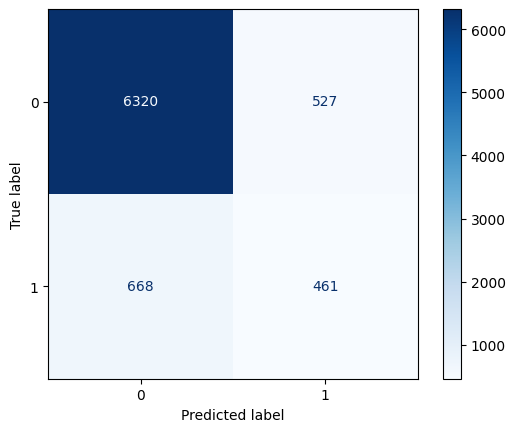

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.4665991902834008|0.8424359353636854|0.408325952170062|0.43552196504487484|0.845949566899478|0.8501755265797393|0.665678968490464|0.350622346680161


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
svc_w2vec_pipeline = Pipeline([
    ('preprocessing', PreprocessingTransformer()),
    ('generate_embeddings', Word2VecTransformer()),
    ('clf', SVC(C=1, gamma='scale', kernel='linear', random_state=0))
])

run_estimation(
    estimator=svc_w2vec_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_svc_w2vec.csv',
    model_name='svc_w2vec'
)

##### debug
```
******************** hidden ********************
```

In [ ]:
preprocessed = PreprocessingTransformer().fit_transform(train_df['tweet_text'])

{'USER': 9860, 'URL': 13285, 'HASHTAG': 1856, 'ucc_processed_hashtags': 5455, 'lemmatized': 190424}


In [ ]:
preprocessed

0        [USER, volver, quedar, evidencia, desplazar, m...
1        [curso, escolar, andaluc, comenzar, presupuest...
2        [pp, equivocar, completamente, excluir, vox, m...
3        [definir, USER, necesitar, HASHTAG, movilizar,...
4        [USER, unir, psoe, erc, pacto, cárcel, lledone...
                               ...                        
13425    [organización, médico, alertar, inminente, cat...
13426    [empezar, navalacruz, HASHTAG, USER, anunciar,...
13427    [valiente, presidente, pedro, sánchez, mostrar...
13428    [pp, conformar, retrasar, llegada, ave, extrem...
13429    [razón, congreso, investigar, negocio, oscuro,...
Length: 13430, dtype: object

In [ ]:
embeddings = Word2VecTransformer().fit_transform(X=preprocessed)

training embedding model...
training finished.
{'present': 226455, 'not_present': 0}


In [ ]:
embeddings

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.136143,1.198859,0.102844,0.670876,0.608562,-0.610436,0.658396,0.976333,-0.353578,-0.041321,...,-0.594645,-0.075685,-0.056387,-0.301623,0.273163,-0.024309,-0.054861,-0.111693,0.374118,-0.317363
1,1.009364,0.643523,-0.449479,-0.356971,1.246303,-0.427633,0.019305,0.748654,-0.248010,-0.088318,...,0.221197,-0.095235,0.260573,-0.348216,-0.343339,0.197810,-0.852394,0.256904,-0.247956,-0.873084
2,1.073062,0.676108,0.231484,0.104979,0.493429,-0.181580,-0.988432,0.177865,-0.816469,-0.334149,...,-0.315999,0.436569,-0.339837,0.547689,-0.431410,0.810997,-0.609445,0.964734,1.048878,-1.184155
3,0.397703,-0.021286,0.212271,0.163830,0.360934,-0.090307,-0.103695,0.486036,-0.576798,-0.799049,...,0.131756,0.499056,-0.274106,0.078978,0.118708,0.587428,0.079046,0.011708,0.310015,-0.203577
4,0.412710,0.305507,-0.105287,0.509055,-0.831424,-0.363297,0.218034,0.125422,0.161145,0.303121,...,-0.397113,-0.369610,0.243512,0.036240,0.227276,0.933431,-0.352032,0.130725,0.643481,-0.813416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13425,0.682195,-0.433000,1.080944,0.299886,-0.073971,0.024694,0.584428,0.677398,0.702821,-0.045219,...,-0.617977,-0.009176,-0.149993,-0.060105,0.098064,-0.238124,-0.616518,0.340738,0.891965,-0.089649
13426,1.271502,-0.441212,-0.521667,-0.640687,0.972987,0.233272,0.234564,1.463010,-0.440728,-0.156510,...,-0.149927,0.539346,1.218293,0.842236,0.221457,0.253545,-0.417812,0.175912,-0.090960,0.679411
13427,0.799352,-0.047485,0.497830,0.404130,0.730670,0.027502,0.178912,0.960028,0.265506,-0.653293,...,-0.028366,-0.053193,0.001178,-0.044444,0.292973,0.690024,-0.117678,0.514782,0.248916,-0.131251
13428,1.203742,0.288112,0.210629,0.334030,0.314712,0.077216,-0.293929,0.600684,0.204571,-0.012171,...,-0.499748,0.389335,0.160480,0.335027,-0.159109,-0.102094,-0.282727,0.403959,0.930243,-0.756129


In [ ]:
clf = SVC(C=1, gamma='scale', kernel='linear', random_state=0)

In [ ]:
clf.fit(embeddings, train_df['class_label'])

SVC(C=1, kernel='linear', random_state=0)

#### FastText

running k-fold cross validation k=10
********************
preprocessing...
{'USER': [9884, '4.771%'], 'URL': [13093, '6.321%'], 'HASHTAG': [6813, '3.289%'], 'ucc_processed_hashtags': [4787, '2.311%'], 'lemmatized': [172570, '83.308%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [203349, '95.88%'], 'not_present': [8737, '4.12%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9612, '4.612%'], 'URL': [13073, '6.272%'], 'HASHTAG': [6753, '3.24%'], 'ucc_processed_hashtags': [4761, '2.284%'], 'lemmatized': [174227, '83.592%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [204697, '95.92%'], 'not_present': [8707, '4.08%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9575, '4.591%'], 'URL': [13065, '6.264%'], 'HASHTAG': [6843, '3.281%'], 'ucc_processed_hashtags': [4814, '2.308%'], 'lemmatized': [174261, '83.555%']}
tokens txt file with one line per tweet written
existing char n-grams embeddings model has been loaded...



{'present': [204757, '95.907%'], 'not_present': [8738, '4.093%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9828, '4.654%'], 'URL': [13183, '6.242%'], 'HASHTAG': [6973, '3.302%'], 'ucc_processed_hashtags': [4937, '2.338%'], 'lemmatized': [176264, '83.464%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [207515, '95.943%'], 'not_present': [8775, '4.057%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9891, '4.687%'], 'URL': [13136, '6.225%'], 'HASHTAG': [6925, '3.282%'], 'ucc_processed_hashtags': [4935, '2.339%'], 'lemmatized': [176133, '83.467%']}
tokens txt file with one line per tweet written
existing char n-grams embeddings model has been loaded...



{'present': [207594, '96.063%'], 'not_present': [8508, '3.937%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9797, '4.628%'], 'URL': [13175, '6.224%'], 'HASHTAG': [6949, '3.283%'], 'ucc_processed_hashtags': [4952, '2.339%'], 'lemmatized': [176799, '83.525%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [209340, '96.563%'], 'not_present': [7451, '3.437%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9869, '4.655%'], 'URL': [13147, '6.202%'], 'HASHTAG': [6966, '3.286%'], 'ucc_processed_hashtags': [4947, '2.334%'], 'lemmatized': [177058, '83.523%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [209763, '96.643%'], 'not_present': [7287, '3.357%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9807, '4.635%'], 'URL': [13118, '6.2%'], 'HASHTAG': [6885, '3.254%'], 'ucc_processed_hashtags': [4900, '2.316%'], 'lemmatized': [176882, '83.596%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [209309, '96.605%'], 'not_present': [7355, '3.395%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9748, '4.611%'], 'URL': [13185, '6.236%'], 'HASHTAG': [6958, '3.291%'], 'ucc_processed_hashtags': [4979, '2.355%'], 'lemmatized': [176548, '83.507%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [209290, '96.643%'], 'not_present': [7269, '3.357%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9819, '4.643%'], 'URL': [13162, '6.224%'], 'HASHTAG': [6866, '3.247%'], 'ucc_processed_hashtags': [4912, '2.323%'], 'lemmatized': [176715, '83.563%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [209300, '96.658%'], 'not_present': [7237, '3.342%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 



# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.3173076923076923|0.7835182379349045|0.4008097165991903|0.3542039355992844|0.7701212935351823|0.7593333333333333|0.61540884872258|0.21091506403055132
0.6935483870967742|0.8316250462198571|0.17479674796747968|0.27922077922077926|0.812729070543078|0.8519012675116745|0.5798165703125506|0.29692168624007304
0.8103448275862069|0.8534405294261518|0.1910569105691057|0.30921052631578944|0.8214764400820802|0.8599066044029353|0.5911389900012328|0.3500509889674691
0.7894736842105263|0.8418692904315258|0.12195121951219512|0.2112676056338028|0.8015713618206229|0.8505670446964643|0.5577832713682285|0.2723066854959277
0.8666666666666667|0.8523767073821091|0.10526315789473684|0.18772563176895304|0.7970914719034055|0.8498999332888593|0.5510341348579115|0.2703770768361688
0.896551724137931|0.857386541375539|0.10526315789473684|0.18840579710144928|0.7975357618251515|0.8505670446964643|0.5514334958802758|0.2770569278740642
0.7692307692307693|0.8332606440048062|0.08097165991902834|0.14652014652014653|0.7879511227960042|0.8445630420280187|0.5380896638253289|0.21647100277860787
0.84|0.8455757117137341|0.08502024291497975|0.15441176470588233|0.7901968488249427|0.8465643762508339|0.540912677368033|0.23703899204869877
0.75|0.8264542061531692|0.048582995951417005|0.09125475285171102|0.7772735003140934|0.8405603735823882|0.5226940538862516|0.16385592561255427
0.875|0.8514297102022818|0.08502024291497975|0.15498154981549814|0.7906228568777365|0.8472314876584389|0.5413120383903972|0.24420560626382065
mean: 0.76081238|mean: 0.83769366|mean: 0.13987361|mean: 0.20772025|mean: 0.79465697|mean: 0.84010945|mean: 0.55896237|mean: 0.25392000


********************
preprocessing...
{'USER': [5533, '4.504%'], 'URL': [7347, '5.98%'], 'HASHTAG': [3955, '3.219%'], 'ucc_processed_hashtags': [2919, '2.376%'], 'lemmatized': [103099, '83.921%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [125090, '99.411%'], 'not_present': [741, '0.589%']} 

********************
preprocessing...
{'USER': [11076, '4.583%'], 'URL': [14959, '6.19%'], 'HASHTAG': [7907, '3.272%'], 'ucc_processed_hashtags': [5614, '2.323%'], 'lemmatized': [202113, '83.632%']}
tokens txt file with one line per tweet written
{'present': [238566, '96.405%'], 'not_present': [8895, '3.595%']} 



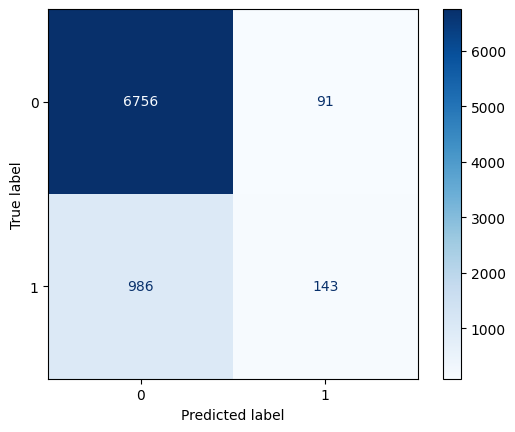

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.6111111111111112|0.8356230194213629|0.1266607617360496|0.20983125458547322|0.8247787316941183|0.8649699097291875|0.5566851347748453|0.23418647085847438


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
svc_fasttext_pipeline = Pipeline([
    ('preprocessing', PreprocessingTransformer()),
    ('write_words', WriteWordsTransformer(words_file_path='fasttext/words.txt')),
    ('generate_embeddings', FastTextTransformer(input_file='fasttext/words.txt', output_file='fasttext/fasttext_vectors.bin')),
    ('clf', SVC(C=1, gamma='scale', kernel='linear', random_state=0))
])

run_estimation(
    estimator=svc_fasttext_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_svc_fasttext.csv',
    model_name='svc_fasttext'
)

##### debug
```
******************** hidden ********************
```

In [ ]:
preprocessed = PreprocessingTransformer().fit_transform(train_df['tweet_text'])

{'USER': 9860, 'URL': 13285, 'HASHTAG': 7311, 'ucc_processed_hashtags': 5455, 'lemmatized': 190424}


In [ ]:
preprocessed

NameError: ignored

In [ ]:
write_txt = WriteWordsTransformer(words_file_path='words.txt').fit_transform(preprocessed)

In [ ]:
write_txt

0        [USER, volver, quedar, evidencia, desplazar, m...
1        [curso, escolar, HASHTAG, andaluc, comenzar, p...
2        [pp, equivocar, completamente, excluir, vox, m...
3        [definir, USER, necesitar, HASHTAG, movilizar,...
4        [USER, unir, psoe, erc, pacto, cárcel, lledone...
                               ...                        
13425    [organización, médico, alertar, inminente, cat...
13426    [empezar, HASHTAG, navalacruz, HASHTAG, USER, ...
13427    [valiente, presidente, pedro, sánchez, mostrar...
13428    [pp, conformar, retrasar, llegada, ave, extrem...
13429    [razón, congreso, investigar, negocio, oscuro,...
Length: 13430, dtype: object

In [ ]:
fast_text = FastTextTransformer(input_file='words.txt').fit_transform(write_txt)

training embedding model...
training finished.
{'present': 230536, 'not_present': 1374} 



In [ ]:
fast_text

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.162609,0.004047,-0.030570,0.188806,-0.041817,-0.066666,0.103425,0.022528,0.228482,0.236830,...,0.066723,0.058972,0.039374,-0.212842,-0.099871,0.245727,-0.068138,0.222734,-0.084429,-0.039888
1,0.029636,0.042049,-0.035104,-0.083198,0.310526,0.042431,0.025298,-0.130302,0.266289,0.302042,...,0.203847,0.038836,-0.082839,-0.221324,-0.372195,0.415847,-0.151376,0.047445,-0.001954,-0.001067
2,0.397603,-0.043445,-0.277611,0.146562,0.220969,0.204437,0.038144,0.090433,0.083033,0.119871,...,0.063392,0.061738,-0.232100,-0.051533,-0.051415,0.120700,-0.167367,0.057009,-0.011444,-0.199284
3,0.117122,-0.100161,0.217759,0.191250,0.134466,-0.112763,0.007630,-0.020365,0.010075,0.257586,...,0.285584,-0.075196,-0.192433,0.144148,0.169408,0.298574,0.026356,-0.280185,-0.006560,-0.059705
4,0.232748,-0.085236,-0.042225,0.179983,-0.081720,0.258416,0.130830,0.234119,0.285764,0.501290,...,-0.149685,0.152486,-0.201171,-0.033893,-0.062415,0.159248,-0.168110,-0.020044,0.043277,-0.221435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13425,0.334010,0.052101,0.024725,0.012482,0.323482,0.110838,0.100886,0.045482,0.051761,0.114245,...,0.254418,0.082298,-0.158560,-0.244704,-0.404471,0.321113,-0.240728,-0.376888,-0.215095,-0.087821
13426,0.159492,-0.070031,-0.016941,0.283397,0.156674,0.133760,0.032345,0.013454,0.150969,0.217928,...,0.311288,0.040781,-0.032677,0.207225,-0.013499,0.288247,0.218973,0.046526,-0.148877,-0.119290
13427,-0.032989,-0.133073,0.062337,0.129037,0.040473,0.005688,0.244456,0.051254,0.141944,0.316384,...,0.081827,0.065064,0.031040,-0.075074,-0.011931,0.215555,-0.179394,-0.077281,-0.091264,-0.111639
13428,0.168250,-0.328495,-0.116221,-0.112034,0.102343,0.092179,-0.052729,-0.017757,0.378212,0.246639,...,0.446286,0.356790,0.051509,-0.038846,-0.164810,0.296832,0.037602,0.227062,0.050972,-0.035929


In [ ]:
clf = SVC(C=1, gamma='scale', kernel='linear', random_state=0)

In [ ]:
clf.fit(fast_text, train_df['class_label'])

SVC(C=1, kernel='linear', random_state=0)

In [ ]:
clf.predict(fast_text.iloc[42,4])

ValueError: ignored

#### InferSent

In [ ]:
svc_infersent_pipeline = Pipeline([
    ('preprocessing', PreprocessingTransformer()),
    ('write_words', WriteWordsTransformer(words_file_path='fasttext/words.txt')),
    ('generate_vec_file', FastTextWordVectors(input_file='fasttext/words.txt', output_file='fasttext/fasttext_vectors.bin')),
    ('generate_embeddings', InferSentTransformer(w2v_path='fasttext/fasttext_vectors.vec', model_version=2)),
    ('clf', SVC(C=1, gamma='scale', kernel='linear', random_state=0))
])

run_estimation(
    estimator=svc_infersent_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_svc_infersent.csv',
    model_name='svc_infersent'
)

NameError: name 'InferSentTransformer' is not defined

##### debug
```
******************** hidden ********************
```

In [ ]:
preprocessed = PreprocessingTransformer().fit_transform(train_df['tweet_text'])

preprocessing...
{'USER': [9860, '4.356%'], 'URL': [13285, '5.87%'], 'HASHTAG': [7311, '3.23%'], 'ucc_processed_hashtags': [5455, '2.41%'], 'lemmatized': [190424, '84.134%']}


In [ ]:
preprocessed

0        [USER, volver, quedar, evidencia, desplazar, m...
1        [curso, escolar, HASHTAG, andaluc, comenzar, p...
2        [pp, equivocar, completamente, excluir, vox, m...
3        [definir, USER, necesitar, HASHTAG, movilizar,...
4        [USER, unir, psoe, erc, pacto, cárcel, lledone...
                               ...                        
13425    [organización, médico, alertar, inminente, cat...
13426    [empezar, HASHTAG, navalacruz, HASHTAG, USER, ...
13427    [valiente, presidente, pedro, sánchez, mostrar...
13428    [pp, conformar, retrasar, llegada, ave, extrem...
13429    [razón, congreso, investigar, negocio, oscuro,...
Length: 13430, dtype: object

In [ ]:
write_txt = WriteWordsTransformer(words_file_path='words.txt').fit_transform(preprocessed)

tokens txt file with one line per tweet written


In [ ]:
write_txt

0        [USER, volver, quedar, evidencia, desplazar, m...
1        [curso, escolar, HASHTAG, andaluc, comenzar, p...
2        [pp, equivocar, completamente, excluir, vox, m...
3        [definir, USER, necesitar, HASHTAG, movilizar,...
4        [USER, unir, psoe, erc, pacto, cárcel, lledone...
                               ...                        
13425    [organización, médico, alertar, inminente, cat...
13426    [empezar, HASHTAG, navalacruz, HASHTAG, USER, ...
13427    [valiente, presidente, pedro, sánchez, mostrar...
13428    [pp, conformar, retrasar, llegada, ave, extrem...
13429    [razón, congreso, investigar, negocio, oscuro,...
Length: 13430, dtype: object

In [ ]:
fast_text_get_vec = FastTextWordVectors(input_file='words.txt').fit_transform(write_txt)

training embedding model...
training finished.


In [ ]:
infersent = InferSentTransformer(w2v_path='fasttext_vectors.vec', model_version=2).fit_transform(fast_text_get_vec)

training embedding model...
Found 15865(/15867) words with w2v vectors
Vocab size : 15865
training finished.
{'present': [230536, '99.408%'], 'not_present': [1374, '0.592%']}


In [ ]:
clf = SVC(C=1, gamma='scale', kernel='linear', random_state=0)

In [ ]:
clf.fit(infersent, train_df['class_label'])

SVC(C=1, kernel='linear', random_state=0)

In [ ]:
clf.predict(infersent.iloc[42])

ValueError: ignored

#### Beto

existing embeddings pickle file loaded for transform



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/537M [00:00<?, ?B/s]

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


running k-fold cross validation k=10
existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.2873015873015873|0.8192722130997994|0.7327935222672065|0.4127708095781072|0.7006667200180177|0.6566666666666666|0.6872267691144492|0.28137923832855094
0.7094594594594594|0.8650800575728076|0.4268292682926829|0.5329949238578681|0.8642956083124973|0.8772515010006671|0.696255815311545|0.48734564199592445
0.6467065868263473|0.8554199499959748|0.43902439024390244|0.5230024213075061|0.8580179100015499|0.8685790527018012|0.6959686995114165|0.4613701015950898
0.7162162162162162|0.8668076248190105|0.43089430894308944|0.5380710659898477|0.8657706560482308|0.8785857238158773|0.6986873779352318|0.49338373796782137
0.6896551724137931|0.8581845782721342|0.4048582995951417|0.5102040816326531|0.8577570986627231|0.8719146097398266|0.6844579037911811|0.46300381809207447
0.756578947368421|0.8780417457220924|0.46558704453441296|0.5764411027568922|0.8758970249085114|0.8872581721147431|0.7180171644397304|0.5358777580534436
0.8201438848920863|0.8886839921776034|0.46153846153846156|0.5906735751295338|0.8820299102987675|0.8945963975983989|0.7207852052101253|0.5647727712889135
0.8559322033898306|0.887960772352553|0.4089068825910931|0.5534246575342466|0.874709048835964|0.8912608405603736|0.6976643039153548|0.5445917289907771
0.7829457364341085|0.8752253364783033|0.4089068825910931|0.5372340425531914|0.8683203070836681|0.8839226150767178|0.6932713326693485|0.5113201872259711
0.8048780487804879|0.8780134005010715|0.4008097165991903|0.5351351351351352|0.8687366357831601|0.885256837891928|0.690820193762854|0.5158734732411464
mean: 0.70698178|mean: 0.86726897|mean: 0.45801488|mean: 0.53099518|mean: 0.85162009|mean: 0.85952924|mean: 0.69831548|mean: 0.48589185

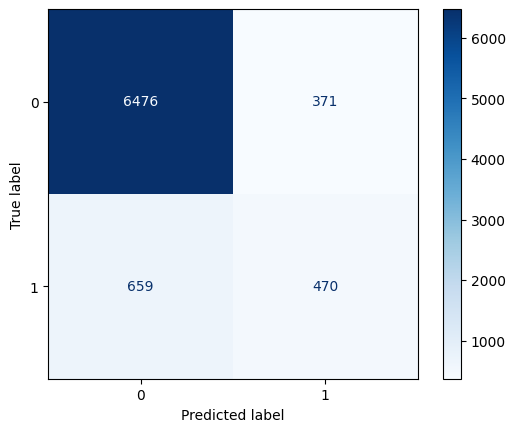

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.558858501783591|0.8582687297727989|0.4162976085031001|0.4771573604060914|0.8627530822934808|0.8708625877632898|0.6810566471024336|0.41100453848254226


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
svc_beto_pipeline = Pipeline([
    ('generate_embeddings', BetoTransformer(
        embeddings_pickle='beto/tweets_embeddings_bert.pickle',
        train_path='data/train.csv',
        test_path='data/test.csv'
    )),
    ('clf', SVC(C=1, gamma='scale', kernel='linear', random_state=0))
])

run_estimation(
    estimator=svc_beto_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_svc_beto.csv',
    model_name='svc_beto'
)

##### debug
```
******************** hidden ********************
```

In [ ]:
beto = BetoTransformer(embeddings_pickle='beto/train_df_tweets_embeddings_bert.pickle').fit(train_df['tweet_text'], train_df['class_label'])

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
beto.predict(test_df['tweet_text'])

AttributeError: ignored

In [ ]:
clf = SVC(C=1, gamma='scale', kernel='linear', random_state=0).fit(beto, train_df['class_label'])

In [ ]:
beto = BetoTransformer(embeddings_pickle='beto/train_df_tweets_embeddings_bert.pickle').transform(test_df['tweet_text'])

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform in training


In [ ]:
clf.predict(beto)

array([0, 1, 0, ..., 1, 1, 0])

## Ejemplo Tfidf
```
******************** hidden ********************
```

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
corpus = [
    'Este es el primer documento.',
    'Este documento es el segundo documento.',
    'Y este es el tercero.',
    'Es este el primer documento?',
    'El primer documento es asi loco',
    'Este documento es el ultimo, es para ser leido por los verdaderos inteligentes de la clase'
]

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,1))

In [ ]:
X = vectorizer.fit_transform(corpus)  # matrix of (n_samples, n_features)

In [ ]:
X

<6x20 sparse matrix of type '<class 'numpy.float64'>'
	with 40 stored elements in Compressed Sparse Row format>

In [ ]:
X.shape  # 6 sentences, 20 features

(6, 20)

In [ ]:
vectorizer.get_feature_names_out()

array(['asi', 'clase', 'de', 'documento', 'el', 'es', 'este',
       'inteligentes', 'la', 'leido', 'loco', 'los', 'para', 'por',
       'primer', 'segundo', 'ser', 'tercero', 'ultimo', 'verdaderos'],
      dtype=object)

## Naive Bayes

### w/ vectors

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

running k-fold cross validation k=10


# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.32710280373831774|0.7742242554614032|0.2834008097165992|0.30368763557483736|0.7797312689932925|0.786|0.5842383138766556|0.17866369116351183
0.8611111111111112|0.8543659622097878|0.12601626016260162|0.21985815602836878|0.8042630160254528|0.8532354903268846|0.5610129185888826|0.2952034790724718
0.8275862068965517|0.8568500786959666|0.1951219512195122|0.3157894736842105|0.823176664462251|0.8612408272181454|0.5935705526249198|0.3593902509139359
0.9666666666666667|0.8710523148856669|0.11788617886178862|0.2101449275362319|0.8034324046590431|0.8545697131420947|0.5585440471324107|0.309659423729682
0.8717948717948718|0.8570237083474218|0.13765182186234817|0.23776223776223776|0.8072629451188609|0.8545697131420947|0.566829105819353|0.31148529990337354
0.8285714285714286|0.8473818871701614|0.11740890688259109|0.20567375886524825|0.8002292771720837|0.8505670446964643|0.5563082873071102|0.276661287751674
0.9117647058823529|0.862315317218104|0.12550607287449392|0.22064056939501775|0.8042578417461542|0.8539026017344896|0.5615549533701544|0.306750565846037
0.9487179487179487|0.8714150377268255|0.14979757085020243|0.25874125874125875|0.8125676347027455|0.8585723815877252|0.5741000633803728|0.3453746714385989
0.8857142857142857|0.8579387038665901|0.12550607287449392|0.21985815602836878|0.8037966115082965|0.8532354903268846|0.5611555923477901|0.3004777048159225
0.9285714285714286|0.8627479988439414|0.10526315789473684|0.18909090909090906|0.7979806228334553|0.8512341561040694|0.5518328569026401|0.2840536874566451
mean: 0.83576015|mean: 0.85153153|mean: 0.14835588|mean: 0.23812471|mean: 0.80366983|mean: 0.84771274|mean: 0.56691467|mean: 0.29677201


Loaded existing fitted model! ./models/bayes_tfidf.pkl



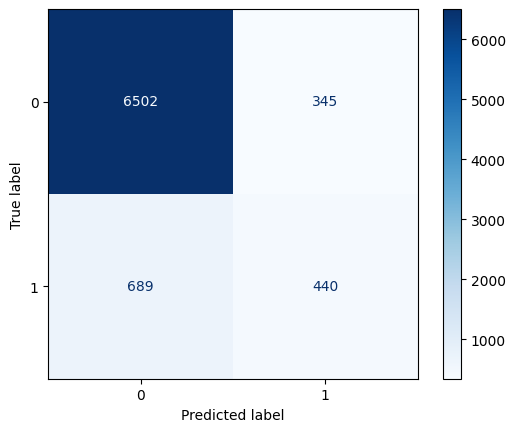

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.5605095541401274|0.85553853756574|0.38972542072630645|0.4597701149425287|0.8602995863771404|0.8703610832497493|0.6696691949549453|0.3971007040151088


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
bayes_tfidf_pipeline = Pipeline([
    ('tdidf_vectorizer', TfidfVectorizer(ngram_range=(1, 1),lowercase=True,use_idf=True,max_df=0.95, min_df=3,max_features=5000)),  # (1, 1) means only unigrams
    ('clf', MultinomialNB())
])
run_estimation(
    estimator=bayes_tfidf_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_bayes_tfidf.csv',
    model_name='bayes_tfidf'
)

### w/ embeddings

#### Word2vec

In [ ]:
from sklearn.preprocessing import MinMaxScaler

running k-fold cross validation k=10
********************
preprocessing...
{'USER': [9884, '4.771%'], 'URL': [13093, '6.321%'], 'HASHTAG': [6813, '3.289%'], 'ucc_processed_hashtags': [4787, '2.311%'], 'lemmatized': [172570, '83.308%']}
training embedding model...
training finished.
{'present': [212086, '100.0%'], 'not_present': [0, '0.0%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
{'present': [237912, '99.361%'], 'not_present': [1530, '0.639%']} 

********************
preprocessing...
{'USER': [9612, '4.612%'], 'URL': [13073, '6.272%'], 'HASHTAG': [6753, '3.24%'], 'ucc_processed_hashtags': [4761, '2.284%'], 'lemmatized': [174227, '83.592%']}
training embedding model...
training finished.
{'present': [213404, '100.0%'], 'not_present': [0, '0.0%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, 

# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.2416555407209613|0.8017144943072492|0.7327935222672065|0.3634538152610442|0.6309099391578289|0.5773333333333334|0.6397407355948961|0.20730804471769432
0.3491686460807601|0.8164269902364498|0.5975609756097561|0.4407796101949025|0.7744698349609369|0.7511674449633089|0.6894428980203609|0.31224894890535576
0.39902676399026765|0.8383755318058038|0.6666666666666666|0.4992389649923896|0.8003458180702576|0.7805203468979319|0.7347698856078744|0.3898343593321163
0.41457286432160806|0.8424298621182214|0.6707317073170732|0.5124223602484472|0.8084844980375226|0.790527018012008|0.7423889981118487|0.4065844761514572
0.3919239904988123|0.8362705831433428|0.6680161943319838|0.4940119760479042|0.7954638807374672|0.7745163442294863|0.7317716754407523|0.38264017687099916
0.41404358353510895|0.8449978800689868|0.6923076923076923|0.5181818181818183|0.8070058526198948|0.7878585723815877|0.7495084787417056|0.41435826563083894
0.4158415841584158|0.84348627795054|0.680161943319838|0.5161290322580645|0.8081708342875623|0.789859906604403|0.7458317703819637|0.4110748465684068
0.43478260869565216|0.8426174863509899|0.6477732793522267|0.5203252032520326|0.8175655878459047|0.8032021347565044|0.7408195470243562|0.41516158381964907
0.43103448275862066|0.8512285472076399|0.708502024291498|0.5359877488514547|0.8156215427060813|0.7978652434956638|0.7619986159796148|0.4374279567889729
0.41604010025062654|0.8422743011935807|0.6720647773279352|0.5139318885448917|0.8084022134537605|0.790527018012008|0.742981270453105|0.4079159102815774
mean: 0.39080902|mean: 0.83598220|mean: 0.67365788|mean: 0.49144624|mean: 0.78664400|mean: 0.76433774|mean: 0.72792539|mean: 0.37845546


Loaded existing fitted model! ./models/bayes_w2vec.pkl

********************
preprocessing...
{'USER': [15403, '4.463%'], 'URL': [20897, '6.054%'], 'HASHTAG': [11263, '3.263%'], 'ucc_processed_hashtags': [8150, '2.361%'], 'lemmatized': [289438, '83.858%']}
{'present': [345845, '97.823%'], 'not_present': [7695, '2.177%']} 



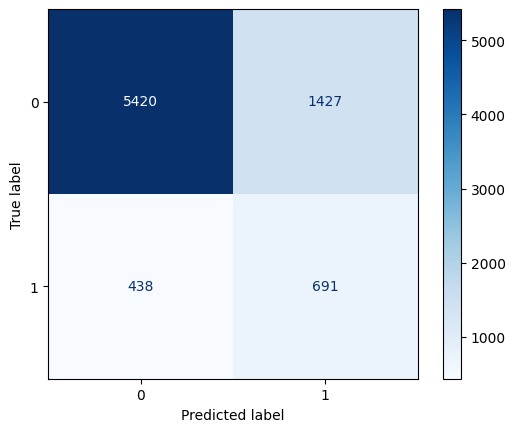

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.3262511803588291|0.8404451481582409|0.6120460584588131|0.4256236526024022|0.7926830695118411|0.7661735205616851|0.701816807526471|0.31860075522183384


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
# agrego MinMaxScaler antes de clf para escalar al rango [0, 1]
# y evitar los negativos

bayes_w2vec_pipeline = Pipeline([
    ('preprocessing', PreprocessingTransformer()),
    ('word2vec', Word2VecTransformer()),
    ('scaler', MinMaxScaler()),
    ('clf', GaussianNB())
])


run_estimation(
    estimator=bayes_w2vec_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_bayes_w2vec.csv',
    model_name='bayes_w2vec'
)

#### FastText

running k-fold cross validation k=10
********************
preprocessing...
{'USER': [9884, '4.771%'], 'URL': [13093, '6.321%'], 'HASHTAG': [6813, '3.289%'], 'ucc_processed_hashtags': [4787, '2.311%'], 'lemmatized': [172570, '83.308%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [203349, '95.88%'], 'not_present': [8737, '4.12%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9612, '4.612%'], 'URL': [13073, '6.272%'], 'HASHTAG': [6753, '3.24%'], 'ucc_processed_hashtags': [4761, '2.284%'], 'lemmatized': [174227, '83.592%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [204697, '95.92%'], 'not_present': [8707, '4.08%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9575, '4.591%'], 'URL': [13065, '6.264%'], 'HASHTAG': [6843, '3.281%'], 'ucc_processed_hashtags': [4814, '2.308%'], 'lemmatized': [174261, '83.555%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [204757, '95.907%'], 'not_present': [8738, '4.093%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9828, '4.654%'], 'URL': [13183, '6.242%'], 'HASHTAG': [6973, '3.302%'], 'ucc_processed_hashtags': [4937, '2.338%'], 'lemmatized': [176264, '83.464%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [207515, '95.943%'], 'not_present': [8775, '4.057%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9891, '4.687%'], 'URL': [13136, '6.225%'], 'HASHTAG': [6925, '3.282%'], 'ucc_processed_hashtags': [4935, '2.339%'], 'lemmatized': [176133, '83.467%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [207594, '96.063%'], 'not_present': [8508, '3.937%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9797, '4.628%'], 'URL': [13175, '6.224%'], 'HASHTAG': [6949, '3.283%'], 'ucc_processed_hashtags': [4952, '2.339%'], 'lemmatized': [176799, '83.525%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [209340, '96.563%'], 'not_present': [7451, '3.437%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9869, '4.655%'], 'URL': [13147, '6.202%'], 'HASHTAG': [6966, '3.286%'], 'ucc_processed_hashtags': [4947, '2.334%'], 'lemmatized': [177058, '83.523%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [209763, '96.643%'], 'not_present': [7287, '3.357%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9807, '4.635%'], 'URL': [13118, '6.2%'], 'HASHTAG': [6885, '3.254%'], 'ucc_processed_hashtags': [4900, '2.316%'], 'lemmatized': [176882, '83.596%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [209309, '96.605%'], 'not_present': [7355, '3.395%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9748, '4.611%'], 'URL': [13185, '6.236%'], 'HASHTAG': [6958, '3.291%'], 'ucc_processed_hashtags': [4979, '2.355%'], 'lemmatized': [176548, '83.507%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [209290, '96.643%'], 'not_present': [7269, '3.357%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9819, '4.643%'], 'URL': [13162, '6.224%'], 'HASHTAG': [6866, '3.247%'], 'ucc_processed_hashtags': [4912, '2.323%'], 'lemmatized': [176715, '83.563%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [209300, '96.658%'], 'not_present': [7237, '3.342%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 



# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.2905982905982906|0.8128893746205221|0.6882591093117408|0.4086538461538462|0.7130567343173431|0.672|0.67852700078516|0.27149975168009366
0.38461538461538464|0.805290617783915|0.44715447154471544|0.41353383458646614|0.7979979384142539|0.7918612408272181|0.6533457912392372|0.2890889744557557
0.4808362369337979|0.8403150426545561|0.5609756097560976|0.5178236397748592|0.8337206756967327|0.828552368245497|0.7210305024039866|0.41613384308558743
0.4267515923566879|0.8269205386926857|0.5447154471544715|0.4785714285714286|0.8143137966034937|0.8052034689793195|0.7005301098501806|0.3650300998494774
0.3989071038251366|0.8264989557101429|0.5910931174089069|0.47634584013050574|0.8013003645174157|0.7858572381587725|0.7076871337843257|0.35870277124182837
0.2512396694214876|0.7878677069741603|0.6153846153846154|0.35680751173708924|0.6807353094938051|0.6344229486324217|0.6267817645613173|0.19173040164115485
0.3760504201680672|0.8416694845886096|0.7246963562753036|0.4951590594744121|0.7828111794662108|0.7565043362241495|0.7437379544954793|0.3884744903763229
0.39601769911504425|0.8462322485289093|0.7246963562753036|0.5121602288984263|0.7957306385961405|0.7725150100066711|0.7533226190322204|0.40955482608985777
0.3883089770354906|0.8492580437117042|0.7530364372469636|0.512396694214876|0.7895183721208157|0.7638425617078052|0.7595054390707661|0.41291366810967806
0.3807531380753138|0.844789762964274|0.7368421052631579|0.5020689655172413|0.7853016782795246|0.7591727818545697|0.7502101900117706|0.3983444861643411
mean: 0.37740785|mean: 0.82817318|mean: 0.63868536|mean: 0.46735210|mean: 0.77944867|mean: 0.75699320|mean: 0.70946785|mean: 0.35014733


********************
preprocessing...
{'USER': [5533, '4.504%'], 'URL': [7347, '5.98%'], 'HASHTAG': [3955, '3.219%'], 'ucc_processed_hashtags': [2919, '2.376%'], 'lemmatized': [103099, '83.921%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [125090, '99.411%'], 'not_present': [741, '0.589%']} 

********************
preprocessing...
{'USER': [11076, '4.583%'], 'URL': [14959, '6.19%'], 'HASHTAG': [7907, '3.272%'], 'ucc_processed_hashtags': [5614, '2.323%'], 'lemmatized': [202113, '83.632%']}
tokens txt file with one line per tweet written
{'present': [238566, '96.405%'], 'not_present': [8895, '3.595%']} 



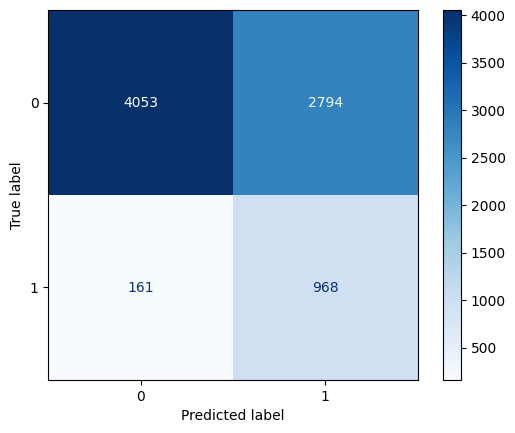

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.2573099415204678|0.8620745459455439|0.8573959255978743|0.395829073809037|0.6851406268815327|0.6295135406218656|0.7246670003336239|0.31376879953586595


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
bayes_fasttext_pipeline = Pipeline([
    ('preprocessing', PreprocessingTransformer()),
    ('write_words', WriteWordsTransformer(words_file_path='fasttext/words.txt')),
    ('generate_embeddings', FastTextTransformer(input_file='fasttext/words.txt', output_file='fasttext/fasttext_vectors.bin')),
    ('clf', GaussianNB())
])

run_estimation(
    estimator=bayes_fasttext_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_bayes_fasttext.csv',
    model_name='bayes_fasttext'
)

#### InferSent

running k-fold cross validation k=10
********************
preprocessing...
{'USER': [9884, '4.771%'], 'URL': [13093, '6.321%'], 'HASHTAG': [6813, '3.289%'], 'ucc_processed_hashtags': [4787, '2.311%'], 'lemmatized': [172570, '83.308%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 14483(/20154) words with w2v vectors
Vocab size : 14483
training finished.
{'present': [203349, '95.88%'], 'not_present': [8737, '4.12%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [229060, '95.664%'], 'not_present': [10382, '4.336%']} 

********************
preprocessing...
{'USER': [9612, '4.612%'], 'URL': [13073, '6.272%'], 'HASHTAG': [6753, '3.24%'], 'ucc_processed_hashtags': [4761, '2.284%'], 'lemmatized': [174227, '83.592%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 14315(/19987) words with w2v vectors
Vocab size : 14315
training finished.
{'present': [204697, '95.92%'], 'not_present': [8707, '4.08%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [228886, '95.591%'], 'not_present': [10556, '4.409%']} 

********************
preprocessing...
{'USER': [9575, '4.591%'], 'URL': [13065, '6.264%'], 'HASHTAG': [6843, '3.281%'], 'ucc_processed_hashtags': [4814, '2.308%'], 'lemmatized': [174261, '83.555%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 14236(/19908) words with w2v vectors
Vocab size : 14236
training finished.
{'present': [204757, '95.907%'], 'not_present': [8738, '4.093%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [228822, '95.565%'], 'not_present': [10620, '4.435%']} 

********************
preprocessing...
{'USER': [9828, '4.654%'], 'URL': [13183, '6.242%'], 'HASHTAG': [6973, '3.302%'], 'ucc_processed_hashtags': [4937, '2.338%'], 'lemmatized': [176264, '83.464%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 14722(/20392) words with w2v vectors
Vocab size : 14722
training finished.
{'present': [207515, '95.943%'], 'not_present': [8775, '4.057%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [229363, '95.791%'], 'not_present': [10079, '4.209%']} 

********************
preprocessing...
{'USER': [9891, '4.687%'], 'URL': [13136, '6.225%'], 'HASHTAG': [6925, '3.282%'], 'ucc_processed_hashtags': [4935, '2.339%'], 'lemmatized': [176133, '83.467%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 14960(/20485) words with w2v vectors
Vocab size : 14960
training finished.
{'present': [207594, '96.063%'], 'not_present': [8508, '3.937%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [229617, '95.897%'], 'not_present': [9825, '4.103%']} 

********************
preprocessing...
{'USER': [9797, '4.628%'], 'URL': [13175, '6.224%'], 'HASHTAG': [6949, '3.283%'], 'ucc_processed_hashtags': [4952, '2.339%'], 'lemmatized': [176799, '83.525%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 15728(/20567) words with w2v vectors
Vocab size : 15728
training finished.
{'present': [209340, '96.563%'], 'not_present': [7451, '3.437%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230423, '96.233%'], 'not_present': [9019, '3.767%']} 

********************
preprocessing...
{'USER': [9869, '4.655%'], 'URL': [13147, '6.202%'], 'HASHTAG': [6966, '3.286%'], 'ucc_processed_hashtags': [4947, '2.334%'], 'lemmatized': [177058, '83.523%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 15843(/20600) words with w2v vectors
Vocab size : 15843
training finished.
{'present': [209763, '96.643%'], 'not_present': [7287, '3.357%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9807, '4.635%'], 'URL': [13118, '6.2%'], 'HASHTAG': [6885, '3.254%'], 'ucc_processed_hashtags': [4900, '2.316%'], 'lemmatized': [176882, '83.596%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 15843(/20636) words with w2v vectors
Vocab size : 15843
training finished.
{'present': [209309, '96.605%'], 'not_present': [7355, '3.395%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9748, '4.611%'], 'URL': [13185, '6.236%'], 'HASHTAG': [6958, '3.291%'], 'ucc_processed_hashtags': [4979, '2.355%'], 'lemmatized': [176548, '83.507%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 15843(/20528) words with w2v vectors
Vocab size : 15843
training finished.
{'present': [209290, '96.643%'], 'not_present': [7269, '3.357%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9819, '4.643%'], 'URL': [13162, '6.224%'], 'HASHTAG': [6866, '3.247%'], 'ucc_processed_hashtags': [4912, '2.323%'], 'lemmatized': [176715, '83.563%']}
tokens txt file with one line per tweet written
existing char n-grams embeddings model has been loaded...



training embedding model...
Found 15842(/20557) words with w2v vectors
Vocab size : 15842
training finished.
{'present': [209300, '96.658%'], 'not_present': [7237, '3.342%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230545, '96.284%'], 'not_present': [8897, '3.716%']} 



# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.28836424957841483|0.8128224582644635|0.6923076923076923|0.40714285714285714|0.7097854497354499|0.668|0.6777579961937503|0.26968212620058923
0.3708609271523179|0.8031773063585836|0.45528455284552843|0.4087591240875913|0.7924295446182056|0.7838559039359573|0.6518242397108728|0.2803907310968169
0.46864686468646866|0.8401138138583994|0.5772357723577236|0.5173041894353371|0.8303355028688177|0.8232154769846565|0.7243720761229959|0.4138614615621816
0.42168674698795183|0.8291684171617383|0.5691056910569106|0.4844290657439446|0.8124579778857213|0.8012008005336891|0.7079367242195965|0.3709367074950535
0.3896457765667575|0.8226936436488707|0.5789473684210527|0.46579804560260585|0.7970627643140739|0.781187458305537|0.7000168152009416|0.3451365066811772
0.2558139534883721|0.7907805379884845|0.6234817813765182|0.3627797408716137|0.6847377310929095|0.6390927284856571|0.6328271526690898|0.20103562879401363
0.36942675159235666|0.8367857190509139|0.7044534412955465|0.48467966573816157|0.7795466569985556|0.7531687791861241|0.7336164970056007|0.37340242441351634
0.39816933638443935|0.8434206553925767|0.7044534412955465|0.5087719298245613|0.7977801007836013|0.7758505670446965|0.7471947717659841|0.4035682029492304
0.39045553145336226|0.8456500427948764|0.728744939271255|0.5084745762711865|0.7920833611275846|0.7678452301534356|0.7521520223512825|0.4054095295436525
0.38477801268498946|0.8457120949578182|0.7368421052631579|0.5055555555555555|0.7880005816643998|0.7625083388925951|0.7522069951235917|0.4026553870546208
mean: 0.37378482|mean: 0.82703247|mean: 0.63708568|mean: 0.46536948|mean: 0.77842197|mean: 0.75559253|mean: 0.70799053|mean: 0.34660787


********************
preprocessing...
{'USER': [5533, '4.504%'], 'URL': [7347, '5.98%'], 'HASHTAG': [3955, '3.219%'], 'ucc_processed_hashtags': [2919, '2.376%'], 'lemmatized': [103099, '83.921%']}
tokens txt file with one line per tweet written
existing char n-grams embeddings model has been loaded...



training embedding model...
Found 15841(/15850) words with w2v vectors
Vocab size : 15841
training finished.
{'present': [125090, '99.411%'], 'not_present': [741, '0.589%']} 

********************
preprocessing...
{'USER': [11076, '4.583%'], 'URL': [14959, '6.19%'], 'HASHTAG': [7907, '3.272%'], 'ucc_processed_hashtags': [5614, '2.323%'], 'lemmatized': [202113, '83.632%']}
tokens txt file with one line per tweet written
{'present': [238562, '96.404%'], 'not_present': [8899, '3.596%']} 



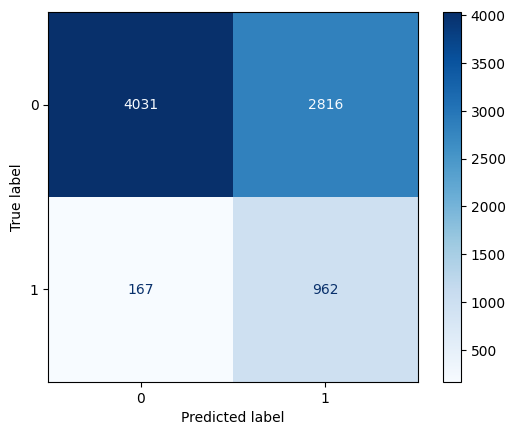

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.25463208046585495|0.8603435497032814|0.8520814880425155|0.3920929284695333|0.6821033081123637|0.6260030090270813|0.7204032385444066|0.3077463482665274


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
bayes_infersent_pipeline = Pipeline([
    ('preprocessing', PreprocessingTransformer()),
    ('write_words', WriteWordsTransformer(words_file_path='fasttext/words.txt')),
    ('generate_vec_file', FastTextWordVectors(input_file='fasttext/words.txt', output_file='fasttext/fasttext_vectors.bin')),
    ('generate_embeddings', InferSentTransformer(w2v_path='fasttext/fasttext_vectors.vec', model_version=2)),
    #('scaler', MinMaxScaler()),
    #('clf', MultinomialNB())
    ('clf', GaussianNB())
])

run_estimation(
    estimator=bayes_infersent_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_bayes_infersent.csv',
    model_name='bayes_infersent'
)

#### Beto

existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


running k-fold cross validation k=10
existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.2349896480331263|0.8427424027419143|0.9190283400809717|0.3742786479802144|0.5421699228328067|0.494|0.6646219114610764|0.2550248237772758
0.3641304347826087|0.8559275732204618|0.8170731707317073|0.5037593984962406|0.7681019426484824|0.7358238825883923|0.7684727385980963|0.4123146340651579
0.3607142857142857|0.8559187386651703|0.8211382113821138|0.501240694789082|0.7648514527728054|0.7318212141427618|0.7677119628339141|0.4099341067328521
0.4583333333333333|0.873504079258087|0.8048780487804879|0.584070796460177|0.8301381624979158|0.8118745830553702|0.8090631265450723|0.5054709430773451
0.4447004608294931|0.8661503160000265|0.7813765182186235|0.566813509544787|0.8222805434378126|0.8032021347565044|0.7944422527195354|0.4816827568783762
0.42596810933940776|0.8581362231344442|0.757085020242915|0.5451895043731778|0.8123460909133668|0.7918612408272181|0.7779035324856748|0.4530952519733592
0.4444444444444444|0.8626599200513408|0.7611336032388664|0.5611940298507463|0.8222158260915803|0.8038692461641094|0.7867169613638421|0.47266963417398916
0.4932249322493225|0.8684515404606661|0.7368421052631579|0.5909090909090909|0.844230250133934|0.8318879252835224|0.7937405414494703|0.505931969413684
0.4796954314720812|0.8704262404733366|0.7651821862348178|0.5897035881435257|0.8391964449901433|0.8245496997998666|0.8007220835327444|0.5068934840012803
0.44366197183098594|0.863181341805589|0.7651821862348178|0.5616641901931649|0.8217979593056818|0.8032021347565044|0.7879425308170894|0.4736764504829562
mean: 0.41498631|mean: 0.86170984|mean: 0.79289194|mean: 0.53788235|mean: 0.78673286|mean: 0.76320921|mean: 0.77513376|mean: 0.44766941

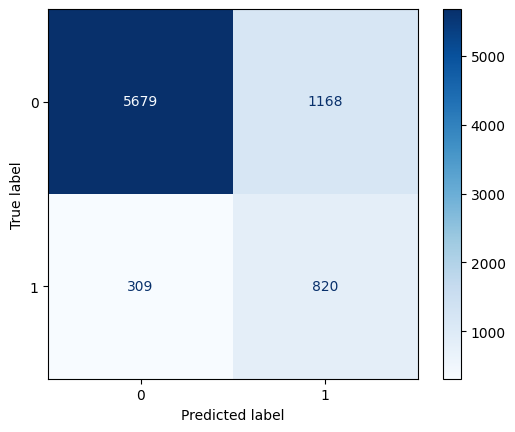

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.4124748490945674|0.8725372304813377|0.7263064658990257|0.5261469361565608|0.8341392633292156|0.8148194583751254|0.7778604039733189|0.44782125991976746


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
bayes_beto_pipeline = Pipeline([
    ('generate_embeddings', BetoTransformer(
        embeddings_pickle='beto/tweets_embeddings_bert.pickle',
        train_path='data/train.csv',
        test_path='data/test.csv'
    )),
    ('clf', GaussianNB())
])

run_estimation(
    estimator=bayes_beto_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_bayes_beto.csv',
    model_name='bayes_beto'
)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

### w/ vectors

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

running k-fold cross validation k=10


# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.28620689655172415|0.7692433361831481|0.3360323886639676|0.3091247672253259|0.76041019150466|0.7526666666666667|0.5854144385458705|0.16043296658684295
0.7272727272727273|0.8286619125222761|0.0975609756097561|0.17204301075268819|0.7931091235702296|0.8458972648432288|0.5451891071185253|0.22813025709229234
0.825|0.8492488481011559|0.13414634146341464|0.23076923076923078|0.805953761171694|0.8532354903268846|0.5642798746423219|0.295454401513889
0.6521739130434783|0.812098191536198|0.06097560975609756|0.11152416356877323|0.7809872424599859|0.8405603735823882|0.5272954664901797|0.16449644206701639
0.75|0.8318427918089452|0.09716599190283401|0.17204301075268816|0.7926134602718915|0.8458972648432288|0.5453881077725032|0.23298752506290976
0.8421052631578947|0.8510716019212443|0.12955465587044535|0.22456140350877193|0.8041889252293436|0.8525683789192795|0.5623811618010374|0.29445381761517914
0.9411764705882353|0.8677318038030841|0.12955465587044535|0.22775800711743768|0.8060454413649107|0.8552368245496998|0.5639786058904943|0.31882850176059685
0.9767441860465116|0.8785712751340999|0.1700404858299595|0.28965517241379307|0.819415650094511|0.8625750500333556|0.5846208818926155|0.3761345855041804
0.9666666666666667|0.8705600572077928|0.11740890688259109|0.20938628158844763|0.8025023659859815|0.8539026017344896|0.5583050924189313|0.30889835786937914
0.7083333333333334|0.8217019444224586|0.06882591093117409|0.12546125461254612|0.7833083715284869|0.8418945963975984|0.5316174283090376|0.1868983848181681
mean: 0.76756795|mean: 0.83807318|mean: 0.13412659|mean: 0.20723263|mean: 0.79485345|mean: 0.84044345|mean: 0.55684702|mean: 0.25667152


Loaded existing fitted model! ./models/random_forest_tfidf.pkl



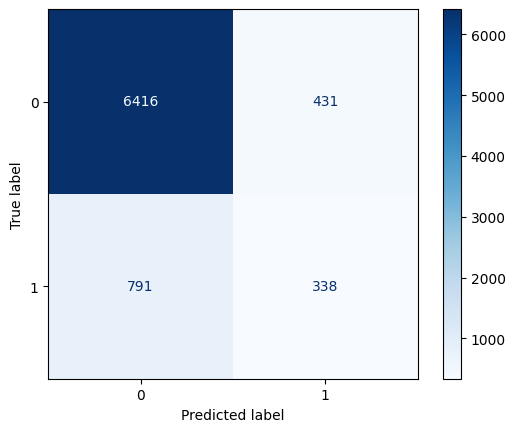

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.43953185955786733|0.826447223595653|0.2993799822852081|0.3561643835616438|0.8342227494028939|0.84679037111334|0.6182163530529298|0.2792314020485299


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
random_forest_tfidf_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(ngram_range=(1, 1),lowercase=True,use_idf=True,max_df=0.95, min_df=3,max_features=5000)),  # (1, 1) means only unigrams
    ('clf', RandomForestClassifier())
])
run_estimation(
    estimator=random_forest_tfidf_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_random_forest_tfidf.csv',
    model_name='random_forest_tfidf'
)

### w/ embeddings

#### Word2vec

running k-fold cross validation k=10
********************
preprocessing...
{'USER': [9884, '4.771%'], 'URL': [13093, '6.321%'], 'HASHTAG': [6813, '3.289%'], 'ucc_processed_hashtags': [4787, '2.311%'], 'lemmatized': [172570, '83.308%']}
training embedding model...
training finished.
{'present': [212086, '100.0%'], 'not_present': [0, '0.0%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
{'present': [237912, '99.361%'], 'not_present': [1530, '0.639%']} 

********************
preprocessing...
{'USER': [9612, '4.612%'], 'URL': [13073, '6.272%'], 'HASHTAG': [6753, '3.24%'], 'ucc_processed_hashtags': [4761, '2.284%'], 'lemmatized': [174227, '83.592%']}
training embedding model...
training finished.
{'present': [213404, '100.0%'], 'not_present': [0, '0.0%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, 

# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.3282051282051282|0.77223908045977|0.2591093117408907|0.2895927601809955|0.7804806451118367|0.7906666666666666|0.5772801147690886|0.17045086309079377
0.6808510638297872|0.8244286609766884|0.13008130081300814|0.21843003412969286|0.8009721570661209|0.8472314876584389|0.5590550159292494|0.2510138232253666
0.7288135593220338|0.8376583996989831|0.17479674796747968|0.28196721311475414|0.8141878161155179|0.8539026017344896|0.5810136972080016|0.3086201551750985
0.7058823529411765|0.8305053005762915|0.14634146341463414|0.2424242424242424|0.8060429322823431|0.8498999332888593|0.5671850972300625|0.27452169121971665
0.6530612244897959|0.8189891548623314|0.12955465587044535|0.2162162162162162|0.7991366080731357|0.8452301534356238|0.557988190555031|0.2419569787604792
0.7878787878787878|0.8513917325895723|0.21052631578947367|0.33226837060702874|0.8249598359290373|0.8605737158105403|0.5996721035816378|0.3604617592051923
0.7678571428571429|0.8436709761759794|0.17408906882591094|0.2838283828382839|0.8147399739497442|0.8552368245496998|0.5818528411222207|0.3202485824855623
0.8909090909090909|0.8674992763579984|0.19838056680161945|0.3245033112582782|0.82549460496083|0.8639092728485657|0.5967941172666245|0.38200113994760887
0.8604651162790697|0.8565430024309586|0.14979757085020243|0.25517241379310346|0.8106494195165747|0.8559039359573049|0.572502619290916|0.3222696578554074
0.8222222222222222|0.8500757701119611|0.14979757085020243|0.2534246575342466|0.8096948789836376|0.8545697131420947|0.5717038972461875|0.3117704412566807
mean: 0.72261457|mean: 0.83530014|mean: 0.17224746|mean: 0.26978276|mean: 0.80863589|mean: 0.84771243|mean: 0.57650477|mean: 0.29433151


Loaded existing fitted model! ./models/random_forest_w2vec.pkl

********************
preprocessing...
{'USER': [15403, '4.463%'], 'URL': [20897, '6.054%'], 'HASHTAG': [11263, '3.263%'], 'ucc_processed_hashtags': [8150, '2.361%'], 'lemmatized': [289438, '83.858%']}
{'present': [345845, '97.823%'], 'not_present': [7695, '2.177%']} 



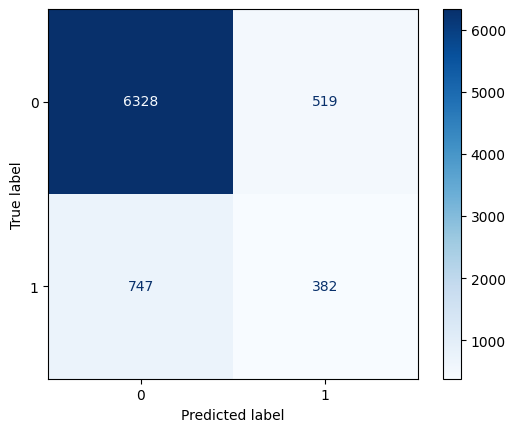

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.4239733629300777|0.8278258349561495|0.3383525243578388|0.37635467980295567|0.8336598605177757|0.8412738214643932|0.6312764520430936|0.289126796086268


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
random_forest_w2vec_pipeline = Pipeline([
    ('preprocessing', PreprocessingTransformer()),
    ('word2vec', Word2VecTransformer()),
    ('clf', RandomForestClassifier())
])
run_estimation(
    estimator=random_forest_w2vec_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_random_forest_w2vec.csv',
    model_name='random_forest_w2vec'
)

#### FastText

running k-fold cross validation k=10
********************
preprocessing...
{'USER': [9884, '4.771%'], 'URL': [13093, '6.321%'], 'HASHTAG': [6813, '3.289%'], 'ucc_processed_hashtags': [4787, '2.311%'], 'lemmatized': [172570, '83.308%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [203349, '95.88%'], 'not_present': [8737, '4.12%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9612, '4.612%'], 'URL': [13073, '6.272%'], 'HASHTAG': [6753, '3.24%'], 'ucc_processed_hashtags': [4761, '2.284%'], 'lemmatized': [174227, '83.592%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [204697, '95.92%'], 'not_present': [8707, '4.08%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9575, '4.591%'], 'URL': [13065, '6.264%'], 'HASHTAG': [6843, '3.281%'], 'ucc_processed_hashtags': [4814, '2.308%'], 'lemmatized': [174261, '83.555%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [204757, '95.907%'], 'not_present': [8738, '4.093%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9828, '4.654%'], 'URL': [13183, '6.242%'], 'HASHTAG': [6973, '3.302%'], 'ucc_processed_hashtags': [4937, '2.338%'], 'lemmatized': [176264, '83.464%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [207515, '95.943%'], 'not_present': [8775, '4.057%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9891, '4.687%'], 'URL': [13136, '6.225%'], 'HASHTAG': [6925, '3.282%'], 'ucc_processed_hashtags': [4935, '2.339%'], 'lemmatized': [176133, '83.467%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [207594, '96.063%'], 'not_present': [8508, '3.937%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9797, '4.628%'], 'URL': [13175, '6.224%'], 'HASHTAG': [6949, '3.283%'], 'ucc_processed_hashtags': [4952, '2.339%'], 'lemmatized': [176799, '83.525%']}
tokens txt file with one line per tweet written
existing char n-grams embeddings model has been loaded...



{'present': [209340, '96.563%'], 'not_present': [7451, '3.437%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9869, '4.655%'], 'URL': [13147, '6.202%'], 'HASHTAG': [6966, '3.286%'], 'ucc_processed_hashtags': [4947, '2.334%'], 'lemmatized': [177058, '83.523%']}
tokens txt file with one line per tweet written
existing char n-grams embeddings model has been loaded...



{'present': [209763, '96.643%'], 'not_present': [7287, '3.357%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9807, '4.635%'], 'URL': [13118, '6.2%'], 'HASHTAG': [6885, '3.254%'], 'ucc_processed_hashtags': [4900, '2.316%'], 'lemmatized': [176882, '83.596%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [209309, '96.605%'], 'not_present': [7355, '3.395%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9748, '4.611%'], 'URL': [13185, '6.236%'], 'HASHTAG': [6958, '3.291%'], 'ucc_processed_hashtags': [4979, '2.355%'], 'lemmatized': [176548, '83.507%']}
tokens txt file with one line per tweet written
existing char n-grams embeddings model has been loaded...



{'present': [209290, '96.643%'], 'not_present': [7269, '3.357%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9819, '4.643%'], 'URL': [13162, '6.224%'], 'HASHTAG': [6866, '3.247%'], 'ucc_processed_hashtags': [4912, '2.323%'], 'lemmatized': [176715, '83.563%']}
tokens txt file with one line per tweet written
existing char n-grams embeddings model has been loaded...



{'present': [209300, '96.658%'], 'not_present': [7237, '3.342%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 



# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.3953488372093023|0.7685695466419796|0.06882591093117409|0.11724137931034483|0.7757293633625991|0.8293333333333334|0.5240378557050125|0.1068527559468853
0.8571428571428571|0.8420961861718612|0.024390243902439025|0.04743083003952569|0.7702865946091055|0.8392261507671781|0.5117960796527359|0.12816733367825695
0.75|0.8257473150672517|0.036585365853658534|0.0697674418604651|0.7741233928486698|0.8398932621747832|0.5170955560313784|0.14210527787315136
0.6|0.7996257186904544|0.024390243902439025|0.046875|0.7692005434938634|0.8372248165443629|0.510598952757285|0.09644699307712949
0.6111111111111112|0.8028258867253939|0.044534412955465584|0.0830188679245283|0.7746405811732328|0.837891927951968|0.5194716793211833|0.13263870207482578
0.8076923076923077|0.8401652244288679|0.08502024291497975|0.15384615384615383|0.7897712848320899|0.8458972648432288|0.5405133163456688|0.23024509366769577
0.8235294117647058|0.8396079776504703|0.05668016194331984|0.10606060606060606|0.7806029465026221|0.8425617078052035|0.5271419979045673|0.19018396036726462
1.0|0.8722865311199799|0.08502024291497975|0.15671641791044774|0.7919036250690188|0.8492328218812542|0.5425101214574899|0.2683651503906912
0.8823529411764706|0.8498642925825547|0.06072874493927125|0.11363636363636362|0.782462243566159|0.8438959306204136|0.5295656504249072|0.20716649188513736
0.625|0.8026460407989409|0.020242914979757085|0.0392156862745098|0.7670845944885344|0.8365577051367579|0.5089233744227859|0.09087113191540024
mean: 0.73521775|mean: 0.82434347|mean: 0.05064185|mean: 0.09338087|mean: 0.77758052|mean: 0.84017149|mean: 0.52316546|mean: 0.15930429


********************
preprocessing...
{'USER': [5533, '4.504%'], 'URL': [7347, '5.98%'], 'HASHTAG': [3955, '3.219%'], 'ucc_processed_hashtags': [2919, '2.376%'], 'lemmatized': [103099, '83.921%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [125090, '99.411%'], 'not_present': [741, '0.589%']} 

********************
preprocessing...
{'USER': [11076, '4.583%'], 'URL': [14959, '6.19%'], 'HASHTAG': [7907, '3.272%'], 'ucc_processed_hashtags': [5614, '2.323%'], 'lemmatized': [202113, '83.632%']}
tokens txt file with one line per tweet written
{'present': [238566, '96.405%'], 'not_present': [8895, '3.595%']} 



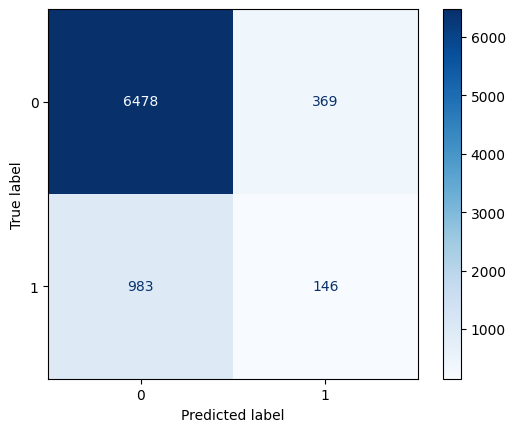

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.283495145631068|0.7854766311209763|0.12931798051372898|0.17761557177615575|0.8024745744913906|0.8304914744232698|0.5377128824724333|0.10698298807369061


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
random_forest_fasttext_pipeline = Pipeline([
    ('preprocessing', PreprocessingTransformer()),
    ('write_words', WriteWordsTransformer(words_file_path='fasttext/words.txt')),
    ('generate_embeddings', FastTextTransformer(input_file='fasttext/words.txt', output_file='fasttext/fasttext_vectors.bin')),
    ('clf', RandomForestClassifier())
])

run_estimation(
    estimator=random_forest_fasttext_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_random_forest_fasttext.csv',
    model_name='random_forest_fasttext'
)

#### InferSent

running k-fold cross validation k=10
********************
preprocessing...
{'USER': [9884, '4.771%'], 'URL': [13093, '6.321%'], 'HASHTAG': [6813, '3.289%'], 'ucc_processed_hashtags': [4787, '2.311%'], 'lemmatized': [172570, '83.308%']}
tokens txt file with one line per tweet written
existing char n-grams embeddings model has been loaded...

training embedding model...


Found 14483(/20154) words with w2v vectors
Vocab size : 14483
training finished.
{'present': [203349, '95.88%'], 'not_present': [8737, '4.12%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [229060, '95.664%'], 'not_present': [10382, '4.336%']} 

********************
preprocessing...
{'USER': [9612, '4.612%'], 'URL': [13073, '6.272%'], 'HASHTAG': [6753, '3.24%'], 'ucc_processed_hashtags': [4761, '2.284%'], 'lemmatized': [174227, '83.592%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 14315(/19987) words with w2v vectors
Vocab size : 14315
training finished.
{'present': [204697, '95.92%'], 'not_present': [8707, '4.08%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [228886, '95.591%'], 'not_present': [10556, '4.409%']} 

********************
preprocessing...
{'USER': [9575, '4.591%'], 'URL': [13065, '6.264%'], 'HASHTAG': [6843, '3.281%'], 'ucc_processed_hashtags': [4814, '2.308%'], 'lemmatized': [174261, '83.555%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 14236(/19908) words with w2v vectors
Vocab size : 14236
training finished.
{'present': [204757, '95.907%'], 'not_present': [8738, '4.093%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [228822, '95.565%'], 'not_present': [10620, '4.435%']} 

********************
preprocessing...
{'USER': [9828, '4.654%'], 'URL': [13183, '6.242%'], 'HASHTAG': [6973, '3.302%'], 'ucc_processed_hashtags': [4937, '2.338%'], 'lemmatized': [176264, '83.464%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 14722(/20392) words with w2v vectors
Vocab size : 14722
training finished.
{'present': [207515, '95.943%'], 'not_present': [8775, '4.057%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [229363, '95.791%'], 'not_present': [10079, '4.209%']} 

********************
preprocessing...
{'USER': [9891, '4.687%'], 'URL': [13136, '6.225%'], 'HASHTAG': [6925, '3.282%'], 'ucc_processed_hashtags': [4935, '2.339%'], 'lemmatized': [176133, '83.467%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 14960(/20485) words with w2v vectors
Vocab size : 14960
training finished.
{'present': [207594, '96.063%'], 'not_present': [8508, '3.937%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [229617, '95.897%'], 'not_present': [9825, '4.103%']} 

********************
preprocessing...
{'USER': [9797, '4.628%'], 'URL': [13175, '6.224%'], 'HASHTAG': [6949, '3.283%'], 'ucc_processed_hashtags': [4952, '2.339%'], 'lemmatized': [176799, '83.525%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 15728(/20567) words with w2v vectors
Vocab size : 15728
training finished.
{'present': [209340, '96.563%'], 'not_present': [7451, '3.437%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230423, '96.233%'], 'not_present': [9019, '3.767%']} 

********************
preprocessing...
{'USER': [9869, '4.655%'], 'URL': [13147, '6.202%'], 'HASHTAG': [6966, '3.286%'], 'ucc_processed_hashtags': [4947, '2.334%'], 'lemmatized': [177058, '83.523%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 15843(/20600) words with w2v vectors
Vocab size : 15843
training finished.
{'present': [209763, '96.643%'], 'not_present': [7287, '3.357%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9807, '4.635%'], 'URL': [13118, '6.2%'], 'HASHTAG': [6885, '3.254%'], 'ucc_processed_hashtags': [4900, '2.316%'], 'lemmatized': [176882, '83.596%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 15843(/20636) words with w2v vectors
Vocab size : 15843
training finished.
{'present': [209309, '96.605%'], 'not_present': [7355, '3.395%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9748, '4.611%'], 'URL': [13185, '6.236%'], 'HASHTAG': [6958, '3.291%'], 'ucc_processed_hashtags': [4979, '2.355%'], 'lemmatized': [176548, '83.507%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 15843(/20528) words with w2v vectors
Vocab size : 15843
training finished.
{'present': [209290, '96.643%'], 'not_present': [7269, '3.357%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9819, '4.643%'], 'URL': [13162, '6.224%'], 'HASHTAG': [6866, '3.247%'], 'ucc_processed_hashtags': [4912, '2.323%'], 'lemmatized': [176715, '83.563%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 15842(/20557) words with w2v vectors
Vocab size : 15842
training finished.
{'present': [209300, '96.658%'], 'not_present': [7237, '3.342%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230545, '96.284%'], 'not_present': [8897, '3.716%']} 



# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.3695652173913043|0.7640517712258039|0.06882591093117409|0.11604095563139931|0.7745184947969134|0.8273333333333334|0.5228407288095616|0.09826590225448409
0.9285714285714286|0.8571246952834679|0.052845528455284556|0.1|0.7808631125400862|0.8438959306204136|0.5260237219291586|0.2004080903678687
0.8461538461538461|0.8425624330013708|0.044715447154471545|0.08494208494208495|0.7775025061569504|0.8418945963975984|0.5215596389802685|0.17223979030886938
0.5333333333333333|0.7893576849975457|0.032520325203252036|0.06130268199233717|0.7711269742831366|0.8365577051367579|0.5134668665122405|0.10022522963954823
0.631578947368421|0.806672917079855|0.048582995951417005|0.09022556390977443|0.776106611686603|0.8385590393595731|0.521495970819159|0.1425706213765996
0.76|0.8312603155608941|0.07692307692307693|0.1397058823529412|0.7865480983697244|0.8438959306204136|0.5360653723273532|0.20895478013904026
0.875|0.8481776680070373|0.05668016194331984|0.1064638783269962|0.7810011404762006|0.8432288192128086|0.5275413589269315|0.198854505335156
0.9565217391304348|0.8655151507862788|0.08906882591093117|0.16296296296296295|0.7928822176298989|0.8492328218812542|0.5441350519331014|0.2664140851140099
0.8666666666666667|0.8463301380315238|0.05263157894736842|0.09923664122137404|0.779531219703066|0.8425617078052035|0.5255170674289558|0.19021677664480877
0.7|0.8159440522470542|0.02834008097165992|0.054474708171206226|0.77015391952875|0.837891927951968|0.5129719574187374|0.11823302529348964
mean: 0.74673912|mean: 0.82669968|mean: 0.05511339|mean: 0.10153554|mean: 0.77902343|mean: 0.84050518|mean: 0.52516177|mean: 0.16963828


********************
preprocessing...
{'USER': [5533, '4.504%'], 'URL': [7347, '5.98%'], 'HASHTAG': [3955, '3.219%'], 'ucc_processed_hashtags': [2919, '2.376%'], 'lemmatized': [103099, '83.921%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 15841(/15850) words with w2v vectors
Vocab size : 15841
training finished.
{'present': [125090, '99.411%'], 'not_present': [741, '0.589%']} 

********************
preprocessing...
{'USER': [11076, '4.583%'], 'URL': [14959, '6.19%'], 'HASHTAG': [7907, '3.272%'], 'ucc_processed_hashtags': [5614, '2.323%'], 'lemmatized': [202113, '83.632%']}
tokens txt file with one line per tweet written
{'present': [238562, '96.404%'], 'not_present': [8899, '3.596%']} 



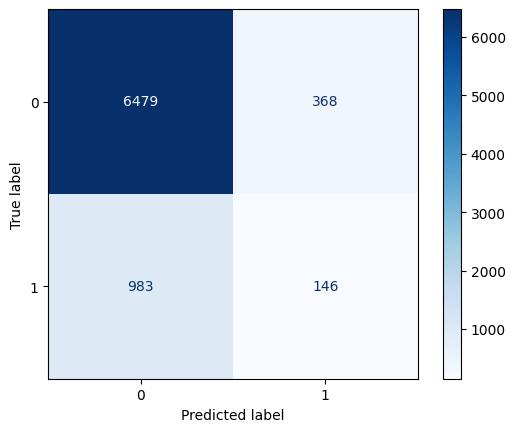

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.2840466926070039|0.7855698595122605|0.12931798051372898|0.17772367620206939|0.8025555393331915|0.830616850551655|0.5377859071547759|0.10728717299335198


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
random_forest_infersent_pipeline = Pipeline([
    ('preprocessing', PreprocessingTransformer()),
    ('write_words', WriteWordsTransformer(words_file_path='fasttext/words.txt')),
    ('generate_vec_file', FastTextWordVectors(input_file='fasttext/words.txt', output_file='fasttext/fasttext_vectors.bin')),
    ('generate_embeddings', InferSentTransformer(w2v_path='fasttext/fasttext_vectors.vec', model_version=2)),
    ('clf', RandomForestClassifier())
])

run_estimation(
    estimator=random_forest_infersent_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_random_forest_infersent.csv',
    model_name='random_forest_infersent'
)

#### Beto

existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


running k-fold cross validation k=10
existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.35269709543568467|0.7859254825834903|0.3441295546558704|0.3483606557377049|0.7869499060248512|0.788|0.6098141787644875|0.22181506539437634
0.8541666666666666|0.8579711882352996|0.16666666666666666|0.27891156462585037|0.8161268040143335|0.8585723815877252|0.5805400372439479|0.3388680206398029
0.8225806451612904|0.8574539849697091|0.2073170731707317|0.3311688311688311|0.8262260744679012|0.8625750500333556|0.5992690713020459|0.3692859756698252
0.851063829787234|0.8569676347543733|0.16260162601626016|0.2730375426621161|0.8148780325549508|0.8579052701801201|0.5785075169187446|0.3336968361385841
0.8333333333333334|0.8533840693550658|0.16194331983805668|0.2711864406779661|0.8134739194586199|0.85657104736491|0.5777767717401147|0.3277753009880627
0.8695652173913043|0.8692858784340063|0.242914979757085|0.37974683544303794|0.8367588857713698|0.8692461641094062|0.6178632406772646|0.41731735929058733
0.9423076923076923|0.8762059986547125|0.19838056680161945|0.3277591973244148|0.8270297160374208|0.8659106070713809|0.5979922003337171|0.39731614117622793
0.9272727272727272|0.8746479689557161|0.20647773279352227|0.33774834437086093|0.8289162793733628|0.866577718478986|0.6016414223073042|0.40113118734618125
0.9230769230769231|0.866617927933691|0.145748987854251|0.2517482517482517|0.8107994048414506|0.857238158772515|0.5716764108600328|0.3340782142601904
0.9047619047619048|0.8644980018817439|0.15384615384615385|0.26297577854671284|0.812884766014432|0.8579052701801201|0.57532563283362|0.33866397744423776
mean: 0.82808260|mean: 0.85629581|mean: 0.19900267|mean: 0.30626434|mean: 0.81740438|mean: 0.85405017|mean: 0.59104065|mean: 0.34799481

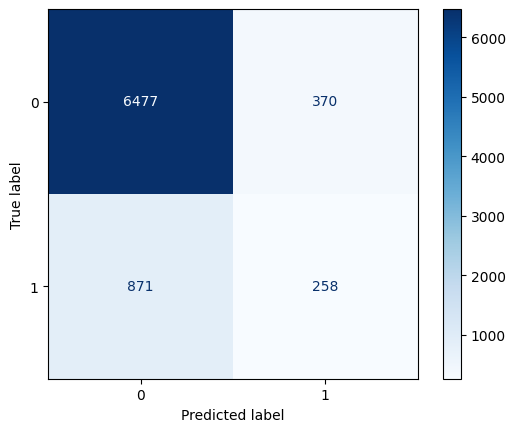

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.410828025477707|0.8148459383651825|0.22852081488042517|0.29368241320432553|0.8249708430927386|0.8444082246740221|0.5872412749734388|0.22583161418039757


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
random_forest_beto_pipeline = Pipeline([
    ('generate_embeddings', BetoTransformer(
        embeddings_pickle='beto/tweets_embeddings_bert.pickle',
        train_path='data/train.csv',
        test_path='data/test.csv'
    )),
    ('clf', RandomForestClassifier())
])

run_estimation(
    estimator=random_forest_beto_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_random_forest_beto.csv',
    model_name='random_forest_beto'
)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

### w/ vectors

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

running k-fold cross validation k=10


# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.3154929577464789|0.788795424072821|0.4534412955465587|0.37209302325581395|0.7649299222220067|0.748|0.6297533692417551|0.22644134807190136
0.7076923076923077|0.8354478854014108|0.18699186991869918|0.2958199356913183|0.816309389023729|0.8539026017344896|0.5859141312881604|0.3124686376124616
0.6666666666666666|0.8387911196345166|0.2764227642276423|0.39080459770114945|0.8331540567274736|0.8585723815877252|0.6246439439653774|0.3666451784522048
0.819672131147541|0.856474263811099|0.2032520325203252|0.32573289902280134|0.8250471499499626|0.8619079386257505|0.5972365509768426|0.3645509799600117
0.796875|0.852450464944109|0.20647773279352227|0.3279742765273312|0.8243006613301431|0.8605737158105403|0.5980471731060263|0.35983199429528534
0.8484848484848485|0.8637095866218608|0.22672064777327935|0.3578274760383387|0.8316599379030456|0.8659106070713809|0.6093667136629974|0.395522082797872
0.8813559322033898|0.8673470637675589|0.21052631578947367|0.3398692810457516|0.8285531716117|0.8652434956637759|0.6024676307381873|0.39098498491407985
0.9295774647887324|0.8825308586071492|0.26720647773279355|0.41509433962264153|0.845654279235063|0.875917278185457|0.6316064337545757|0.45968938947881766
0.9038461538461539|0.8687140194361318|0.1902834008097166|0.31438127090301005|0.8235875213316978|0.8632421614409607|0.5931448952930372|0.37766240825352376
0.9375|0.8808604981718359|0.242914979757085|0.3858520900321543|0.8394326617897481|0.8725817211474316|0.6198600457890856|0.43988498542402155
mean: 0.78071635|mean: 0.85351212|mean: 0.24642375|mean: 0.35254492|mean: 0.82326288|mean: 0.85258519|mean: 0.60920409|mean: 0.36936820


Loaded existing fitted model! ./models/logistic_regression_tfidf.pkl



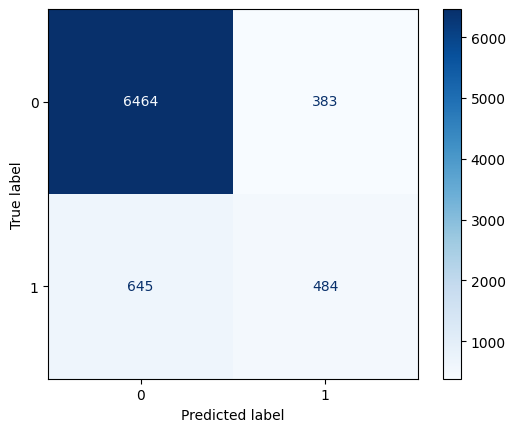

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.558246828143022|0.8595827413266035|0.4286979627989371|0.4849699398797595|0.8638641589626828|0.8711133400200601|0.6863805280622406|0.4174590328013895


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
logistic_regression_tfidf_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(ngram_range=(1, 1),lowercase=True,use_idf=True,max_df=0.95, min_df=3,max_features=5000)),  # (1, 1) means only unigrams
    ('clf', LogisticRegression(alpha=0.01))
])
run_estimation(
    estimator=logistic_regression_tfidf_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_logistic_regression_tfidf.csv',
    model_name='logistic_regression_tfidf'
)

### w/ embeddings

#### Word2vec

running k-fold cross validation k=10
********************
preprocessing...
{'USER': [9884, '4.771%'], 'URL': [13093, '6.321%'], 'HASHTAG': [6813, '3.289%'], 'ucc_processed_hashtags': [4787, '2.311%'], 'lemmatized': [172570, '83.308%']}
training embedding model...
training finished.
{'present': [212086, '100.0%'], 'not_present': [0, '0.0%']} 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
{'present': [237912, '99.361%'], 'not_present': [1530, '0.639%']} 

********************
preprocessing...
{'USER': [9612, '4.612%'], 'URL': [13073, '6.272%'], 'HASHTAG': [6753, '3.24%'], 'ucc_processed_hashtags': [4761, '2.284%'], 'lemmatized': [174227, '83.592%']}
training embedding model...
training finished.
{'present': [213404, '100.0%'], 'not_present': [0, '0.0%']} 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
{'present': [237733, '99.286%'], 'not_present': [1709, '0.714%']} 

********************
preprocessing...
{'USER': [9575, '4.591%'], 'URL': [13065, '6.264%'], 'HASHTAG': [6843, '3.281%'], 'ucc_processed_hashtags': [4814, '2.308%'], 'lemmatized': [174261, '83.555%']}
training embedding model...
training finished.
{'present': [213495, '100.0%'], 'not_present': [0, '0.0%']} 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
{'present': [237676, '99.262%'], 'not_present': [1766, '0.738%']} 

********************
preprocessing...
{'USER': [9828, '4.654%'], 'URL': [13183, '6.242%'], 'HASHTAG': [6973, '3.302%'], 'ucc_processed_hashtags': [4937, '2.338%'], 'lemmatized': [176264, '83.464%']}
training embedding model...
training finished.
{'present': [216290, '100.0%'], 'not_present': [0, '0.0%']} 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
{'present': [238223, '99.491%'], 'not_present': [1219, '0.509%']} 

********************
preprocessing...
{'USER': [9891, '4.687%'], 'URL': [13136, '6.225%'], 'HASHTAG': [6925, '3.282%'], 'ucc_processed_hashtags': [4935, '2.339%'], 'lemmatized': [176133, '83.467%']}
training embedding model...
training finished.
{'present': [216102, '100.0%'], 'not_present': [0, '0.0%']} 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
{'present': [238332, '99.536%'], 'not_present': [1110, '0.464%']} 

********************
preprocessing...
{'USER': [9797, '4.628%'], 'URL': [13175, '6.224%'], 'HASHTAG': [6949, '3.283%'], 'ucc_processed_hashtags': [4952, '2.339%'], 'lemmatized': [176799, '83.525%']}
training embedding model...
training finished.
{'present': [216791, '100.0%'], 'not_present': [0, '0.0%']} 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
{'present': [238419, '99.573%'], 'not_present': [1023, '0.427%']} 

********************
preprocessing...
{'USER': [9869, '4.655%'], 'URL': [13147, '6.202%'], 'HASHTAG': [6966, '3.286%'], 'ucc_processed_hashtags': [4947, '2.334%'], 'lemmatized': [177058, '83.523%']}
training embedding model...
training finished.
{'present': [217050, '100.0%'], 'not_present': [0, '0.0%']} 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
{'present': [238440, '99.582%'], 'not_present': [1002, '0.418%']} 

********************
preprocessing...
{'USER': [9807, '4.635%'], 'URL': [13118, '6.2%'], 'HASHTAG': [6885, '3.254%'], 'ucc_processed_hashtags': [4900, '2.316%'], 'lemmatized': [176882, '83.596%']}
training embedding model...
training finished.
{'present': [216664, '100.0%'], 'not_present': [0, '0.0%']} 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
{'present': [238485, '99.6%'], 'not_present': [957, '0.4%']} 

********************
preprocessing...
{'USER': [9748, '4.611%'], 'URL': [13185, '6.236%'], 'HASHTAG': [6958, '3.291%'], 'ucc_processed_hashtags': [4979, '2.355%'], 'lemmatized': [176548, '83.507%']}
training embedding model...
training finished.
{'present': [216559, '100.0%'], 'not_present': [0, '0.0%']} 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
{'present': [238370, '99.552%'], 'not_present': [1072, '0.448%']} 

********************
preprocessing...
{'USER': [9819, '4.643%'], 'URL': [13162, '6.224%'], 'HASHTAG': [6866, '3.247%'], 'ucc_processed_hashtags': [4912, '2.323%'], 'lemmatized': [176715, '83.563%']}
training embedding model...
training finished.
{'present': [216537, '100.0%'], 'not_present': [0, '0.0%']} 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
{'present': [238403, '99.566%'], 'not_present': [1039, '0.434%']} 



# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.3188854489164087|0.7856443267196428|0.41700404858299595|0.3614035087719299|0.7697163237311386|0.7573333333333333|0.6207127186250974|0.21782992712147975
0.6105263157894737|0.8241553348256062|0.23577235772357724|0.3401759530791789|0.8209318034387795|0.8498999332888593|0.603121613817894|0.31352879197655503
0.6129032258064516|0.8331273048112231|0.3089430894308943|0.41081081081081083|0.8339690335057109|0.8545697131420947|0.6353175143882325|0.36388562945350356
0.6875|0.8414739667262138|0.2682926829268293|0.38596491228070173|0.833140319079767|0.8599066044029353|0.6221750725089055|0.3696504490606768
0.6129032258064516|0.8233475033922645|0.23076923076923078|0.33529411764705885|0.8194560873244197|0.8492328218812542|0.6010076185795036|0.3106709419047298
0.7096774193548387|0.8446399987608558|0.26720647773279355|0.38823529411764707|0.8338356909888466|0.8612408272181454|0.6228204912625629|0.3777611851694998
0.6746987951807228|0.8337372056945913|0.22672064777327935|0.33939393939393936|0.8229022367947567|0.8545697131420947|0.6025775762828058|0.33278396902187046
0.7529411764705882|0.8511958134332671|0.2591093117408907|0.3855421686746988|0.8348412042528546|0.8639092728485657|0.6211680744007968|0.38871802123919
0.6625|0.8301995140288498|0.2145748987854251|0.3241590214067278|0.819530429572744|0.8525683789192795|0.5965047017888787|0.31856122927123315
0.7093023255813954|0.8421553571470334|0.24696356275303644|0.3663663663663664|0.8294636680845373|0.8592394929953302|0.6134977558174128|0.36211590836400703
mean: 0.63518379|mean: 0.83096763|mean: 0.26753563|mean: 0.36373461|mean: 0.82177868|mean: 0.84624701|mean: 0.61389031|mean: 0.33555061


Loaded existing fitted model! ./models/logistic_regression_w2v.pkl

********************
preprocessing...
{'USER': [15403, '4.463%'], 'URL': [20897, '6.054%'], 'HASHTAG': [11263, '3.263%'], 'ucc_processed_hashtags': [8150, '2.361%'], 'lemmatized': [289438, '83.858%']}
{'present': [345845, '97.823%'], 'not_present': [7695, '2.177%']} 



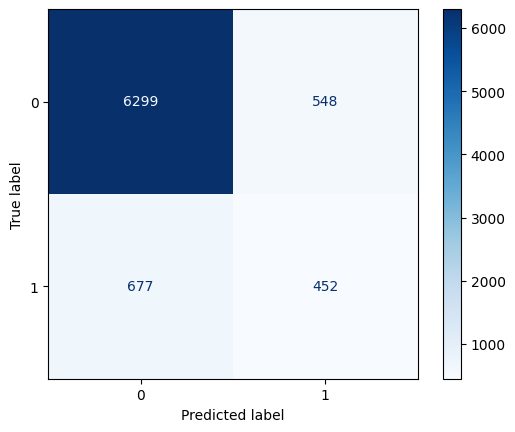

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.452|0.8391207454070928|0.4003542958370239|0.42461249412869895|0.8424778739537265|0.8464142427281846|0.6601596219947498|0.3371917417944685


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
logistic_regression_w2v_pipeline = Pipeline([
    ('preprocessing', PreprocessingTransformer()),
    ('word2vec', Word2VecTransformer()),
    ('clf', LogisticRegression(alpha=0.01))
])
run_estimation(
    estimator=logistic_regression_w2v_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_logistic_regression_w2vec.csv',
    model_name='logistic_regression_w2v'
)

#### FastText

running k-fold cross validation k=10
********************
preprocessing...
{'USER': [9884, '4.771%'], 'URL': [13093, '6.321%'], 'HASHTAG': [6813, '3.289%'], 'ucc_processed_hashtags': [4787, '2.311%'], 'lemmatized': [172570, '83.308%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [203349, '95.88%'], 'not_present': [8737, '4.12%']} 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9612, '4.612%'], 'URL': [13073, '6.272%'], 'HASHTAG': [6753, '3.24%'], 'ucc_processed_hashtags': [4761, '2.284%'], 'lemmatized': [174227, '83.592%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [204697, '95.92%'], 'not_present': [8707, '4.08%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9575, '4.591%'], 'URL': [13065, '6.264%'], 'HASHTAG': [6843, '3.281%'], 'ucc_processed_hashtags': [4814, '2.308%'], 'lemmatized': [174261, '83.555%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [204757, '95.907%'], 'not_present': [8738, '4.093%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9828, '4.654%'], 'URL': [13183, '6.242%'], 'HASHTAG': [6973, '3.302%'], 'ucc_processed_hashtags': [4937, '2.338%'], 'lemmatized': [176264, '83.464%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [207515, '95.943%'], 'not_present': [8775, '4.057%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9891, '4.687%'], 'URL': [13136, '6.225%'], 'HASHTAG': [6925, '3.282%'], 'ucc_processed_hashtags': [4935, '2.339%'], 'lemmatized': [176133, '83.467%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [207594, '96.063%'], 'not_present': [8508, '3.937%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9797, '4.628%'], 'URL': [13175, '6.224%'], 'HASHTAG': [6949, '3.283%'], 'ucc_processed_hashtags': [4952, '2.339%'], 'lemmatized': [176799, '83.525%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [209340, '96.563%'], 'not_present': [7451, '3.437%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9869, '4.655%'], 'URL': [13147, '6.202%'], 'HASHTAG': [6966, '3.286%'], 'ucc_processed_hashtags': [4947, '2.334%'], 'lemmatized': [177058, '83.523%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [209763, '96.643%'], 'not_present': [7287, '3.357%']} 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9807, '4.635%'], 'URL': [13118, '6.2%'], 'HASHTAG': [6885, '3.254%'], 'ucc_processed_hashtags': [4900, '2.316%'], 'lemmatized': [176882, '83.596%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [209309, '96.605%'], 'not_present': [7355, '3.395%']} 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9748, '4.611%'], 'URL': [13185, '6.236%'], 'HASHTAG': [6958, '3.291%'], 'ucc_processed_hashtags': [4979, '2.355%'], 'lemmatized': [176548, '83.507%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [209290, '96.643%'], 'not_present': [7269, '3.357%']} 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9819, '4.643%'], 'URL': [13162, '6.224%'], 'HASHTAG': [6866, '3.247%'], 'ucc_processed_hashtags': [4912, '2.323%'], 'lemmatized': [176715, '83.563%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [209300, '96.658%'], 'not_present': [7237, '3.342%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 



# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.30536130536130535|0.7951412160823926|0.5303643724696356|0.3875739644970414|0.7503466172381836|0.724|0.6462675812866934|0.24009256211009175
0.5909090909090909|0.8239397855873635|0.26422764227642276|0.36516853932584264|0.8243150541191286|0.8492328218812542|0.6141569177064476|0.32428574130403304
0.5594405594405595|0.8253712622849569|0.3252032520325203|0.4113110539845758|0.8300219036536831|0.8472314876584389|0.6374619612117909|0.34662330353779586
0.6509433962264151|0.8365050168080829|0.2804878048780488|0.3920454545454546|0.8326247881784905|0.857238158772515|0.6254793373951297|0.36259082505044654
0.65|0.8336715542074512|0.2631578947368421|0.37463976945244953|0.8285873462021723|0.8552368245496998|0.6176013115856734|0.3496905892273844
0.7619047619047619|0.8527491938368919|0.2591093117408907|0.3867069486404834|0.8353702657689728|0.8645763842561708|0.6215674354231611|0.3921751115235982
0.6794871794871795|0.8331593178781945|0.2145748987854251|0.3261538461538461|0.8205357705735734|0.8539026017344896|0.5973034238336071|0.32506066430367947
0.7611940298507462|0.8463320859783283|0.20647773279352227|0.3248407643312102|0.8227781598641137|0.8585723815877252|0.5968490900389336|0.34775010595329864
0.6727272727272727|0.8246071207716922|0.14979757085020243|0.2450331125827815|0.8049645584856336|0.847898599066044|0.5677102870225453|0.26722085555617486
0.6956521739130435|0.8336202243676791|0.19433198380566802|0.30379746835443033|0.8167701779066395|0.8532354903268846|0.5887794104331855|0.314340492493338
mean: 0.63276198|mean: 0.83050968|mean: 0.26877325|mean: 0.35172709|mean: 0.81663146|mean: 0.84111247|mean: 0.61131768|mean: 0.32698303


********************
preprocessing...
{'USER': [5533, '4.504%'], 'URL': [7347, '5.98%'], 'HASHTAG': [3955, '3.219%'], 'ucc_processed_hashtags': [2919, '2.376%'], 'lemmatized': [103099, '83.921%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

{'present': [125090, '99.411%'], 'not_present': [741, '0.589%']} 

********************
preprocessing...
{'USER': [11076, '4.583%'], 'URL': [14959, '6.19%'], 'HASHTAG': [7907, '3.272%'], 'ucc_processed_hashtags': [5614, '2.323%'], 'lemmatized': [202113, '83.632%']}
tokens txt file with one line per tweet written
{'present': [238566, '96.405%'], 'not_present': [8895, '3.595%']} 



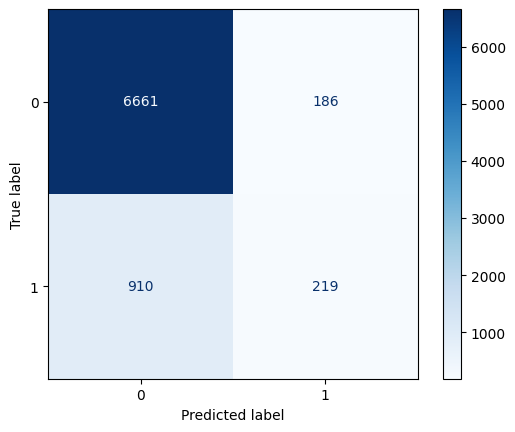

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.5407407407407407|0.8318101587032141|0.19397697077059345|0.2855280312907432|0.8336107036444704|0.8625877632898696|0.5834058944695673|0.2648620524218362


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
logistic_regression_fasttext_pipeline = Pipeline([
    ('preprocessing', PreprocessingTransformer()),
    ('write_words', WriteWordsTransformer(words_file_path='fasttext/words.txt')),
    ('generate_embeddings', FastTextTransformer(input_file='fasttext/words.txt', output_file='fasttext/fasttext_vectors.bin')),
    ('clf', LogisticRegression(alpha=0.01))
])

run_estimation(
    estimator=logistic_regression_fasttext_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_logistic_regression_fasttext.csv',
    model_name='logistic_regression_fasttext'
)

#### InferSent

running k-fold cross validation k=10
********************
preprocessing...
{'USER': [9884, '4.771%'], 'URL': [13093, '6.321%'], 'HASHTAG': [6813, '3.289%'], 'ucc_processed_hashtags': [4787, '2.311%'], 'lemmatized': [172570, '83.308%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 14483(/20154) words with w2v vectors
Vocab size : 14483
training finished.
{'present': [203349, '95.88%'], 'not_present': [8737, '4.12%']} 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [229060, '95.664%'], 'not_present': [10382, '4.336%']} 

********************
preprocessing...
{'USER': [9612, '4.612%'], 'URL': [13073, '6.272%'], 'HASHTAG': [6753, '3.24%'], 'ucc_processed_hashtags': [4761, '2.284%'], 'lemmatized': [174227, '83.592%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 14315(/19987) words with w2v vectors
Vocab size : 14315
training finished.
{'present': [204697, '95.92%'], 'not_present': [8707, '4.08%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [228886, '95.591%'], 'not_present': [10556, '4.409%']} 

********************
preprocessing...
{'USER': [9575, '4.591%'], 'URL': [13065, '6.264%'], 'HASHTAG': [6843, '3.281%'], 'ucc_processed_hashtags': [4814, '2.308%'], 'lemmatized': [174261, '83.555%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 14236(/19908) words with w2v vectors
Vocab size : 14236
training finished.
{'present': [204757, '95.907%'], 'not_present': [8738, '4.093%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [228822, '95.565%'], 'not_present': [10620, '4.435%']} 

********************
preprocessing...
{'USER': [9828, '4.654%'], 'URL': [13183, '6.242%'], 'HASHTAG': [6973, '3.302%'], 'ucc_processed_hashtags': [4937, '2.338%'], 'lemmatized': [176264, '83.464%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 14722(/20392) words with w2v vectors
Vocab size : 14722
training finished.
{'present': [207515, '95.943%'], 'not_present': [8775, '4.057%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [229363, '95.791%'], 'not_present': [10079, '4.209%']} 

********************
preprocessing...
{'USER': [9891, '4.687%'], 'URL': [13136, '6.225%'], 'HASHTAG': [6925, '3.282%'], 'ucc_processed_hashtags': [4935, '2.339%'], 'lemmatized': [176133, '83.467%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 14960(/20485) words with w2v vectors
Vocab size : 14960
training finished.
{'present': [207594, '96.063%'], 'not_present': [8508, '3.937%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [229617, '95.897%'], 'not_present': [9825, '4.103%']} 

********************
preprocessing...
{'USER': [9797, '4.628%'], 'URL': [13175, '6.224%'], 'HASHTAG': [6949, '3.283%'], 'ucc_processed_hashtags': [4952, '2.339%'], 'lemmatized': [176799, '83.525%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 15728(/20567) words with w2v vectors
Vocab size : 15728
training finished.
{'present': [209340, '96.563%'], 'not_present': [7451, '3.437%']} 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230423, '96.233%'], 'not_present': [9019, '3.767%']} 

********************
preprocessing...
{'USER': [9869, '4.655%'], 'URL': [13147, '6.202%'], 'HASHTAG': [6966, '3.286%'], 'ucc_processed_hashtags': [4947, '2.334%'], 'lemmatized': [177058, '83.523%']}
tokens txt file with one line per tweet written
existing char n-grams embeddings model has been loaded...



training embedding model...
Found 15843(/20600) words with w2v vectors
Vocab size : 15843
training finished.
{'present': [209763, '96.643%'], 'not_present': [7287, '3.357%']} 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9807, '4.635%'], 'URL': [13118, '6.2%'], 'HASHTAG': [6885, '3.254%'], 'ucc_processed_hashtags': [4900, '2.316%'], 'lemmatized': [176882, '83.596%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 15843(/20636) words with w2v vectors
Vocab size : 15843
training finished.
{'present': [209309, '96.605%'], 'not_present': [7355, '3.395%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9748, '4.611%'], 'URL': [13185, '6.236%'], 'HASHTAG': [6958, '3.291%'], 'ucc_processed_hashtags': [4979, '2.355%'], 'lemmatized': [176548, '83.507%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 15843(/20528) words with w2v vectors
Vocab size : 15843
training finished.
{'present': [209290, '96.643%'], 'not_present': [7269, '3.357%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230546, '96.285%'], 'not_present': [8896, '3.715%']} 

********************
preprocessing...
{'USER': [9819, '4.643%'], 'URL': [13162, '6.224%'], 'HASHTAG': [6866, '3.247%'], 'ucc_processed_hashtags': [4912, '2.323%'], 'lemmatized': [176715, '83.563%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 15842(/20557) words with w2v vectors
Vocab size : 15842
training finished.
{'present': [209300, '96.658%'], 'not_present': [7237, '3.342%']} 

********************
preprocessing...
{'USER': [10870, '4.649%'], 'URL': [14593, '6.241%'], 'HASHTAG': [7659, '3.275%'], 'ucc_processed_hashtags': [5436, '2.325%'], 'lemmatized': [195273, '83.51%']}
tokens txt file with one line per tweet written
{'present': [230545, '96.284%'], 'not_present': [8897, '3.716%']} 



# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.3060240963855422|0.7933382044306257|0.5141700404858299|0.3836858006042296|0.7527411400763427|0.728|0.6421608382796269|0.23571925838175106
0.6347826086956522|0.8355780665371116|0.2967479674796748|0.4044321329639889|0.8341098422884896|0.85657104736491|0.6316142072035246|0.3663185332183531
0.5664335664335665|0.8271353190015779|0.32926829268292684|0.41645244215938304|0.831506428512603|0.8485657104736491|0.6398935238354778|0.3527547180902392
0.6391752577319587|0.8310820780138213|0.25203252032520324|0.3615160349854228|0.8262696079696643|0.8539026017344896|0.6120497797156742|0.33738379409268376
0.6428571428571429|0.831457367349961|0.2550607287449393|0.3652173913043479|0.8264566551253336|0.8539026017344896|0.6135527285897221|0.3408365068699113
0.7802197802197802|0.859382445439817|0.2874493927125506|0.42011834319526625|0.8429063370182011|0.8692461641094062|0.635737475908991|0.4217531959159925
0.6901408450704225|0.8331341895109621|0.19838056680161945|0.30817610062893086|0.8174405453317952|0.8532354903268846|0.590404340908797|0.31577419958129427
0.7246376811594203|0.8395645000454003|0.20242914979757085|0.3164556962025316|0.820101629217428|0.8559039359573049|0.5936267154738653|0.3315033036262129
0.6964285714285714|0.8295859831049958|0.15789473684210525|0.2574257425742574|0.8079101112382141|0.8498999332888593|0.5721582310408609|0.28231849852342045
0.7083333333333334|0.8372213298315048|0.20647773279352227|0.31974921630094044|0.8202572308791016|0.8552368245496998|0.5948522849271126|0.32911691173170005
mean: 0.63890329|mean: 0.83174795|mean: 0.26999111|mean: 0.35532289|mean: 0.81796995|mean: 0.84244643|mean: 0.61260501|mean: 0.33134789


********************
preprocessing...
{'USER': [5533, '4.504%'], 'URL': [7347, '5.98%'], 'HASHTAG': [3955, '3.219%'], 'ucc_processed_hashtags': [2919, '2.376%'], 'lemmatized': [103099, '83.921%']}
tokens txt file with one line per tweet written


existing char n-grams embeddings model has been loaded...

training embedding model...
Found 15841(/15850) words with w2v vectors
Vocab size : 15841
training finished.
{'present': [125090, '99.411%'], 'not_present': [741, '0.589%']} 

********************
preprocessing...
{'USER': [11076, '4.583%'], 'URL': [14959, '6.19%'], 'HASHTAG': [7907, '3.272%'], 'ucc_processed_hashtags': [5614, '2.323%'], 'lemmatized': [202113, '83.632%']}
tokens txt file with one line per tweet written
{'present': [238562, '96.404%'], 'not_present': [8899, '3.596%']} 



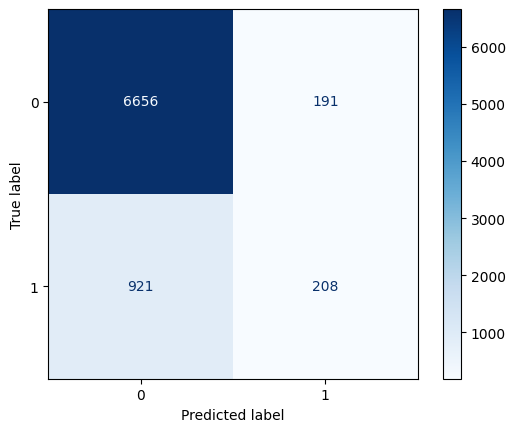

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.5213032581453634|0.8278942309720209|0.18423383525243578|0.27225130890052357|0.8308062863806958|0.8605817452357071|0.5781692032987752|0.2499929288994039


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
logistic_regression_infersent_pipeline = Pipeline([
    ('preprocessing', PreprocessingTransformer()),
    ('write_words', WriteWordsTransformer(words_file_path='fasttext/words.txt')),
    ('generate_vec_file', FastTextWordVectors(input_file='fasttext/words.txt', output_file='fasttext/fasttext_vectors.bin')),
    ('generate_embeddings', InferSentTransformer(w2v_path='fasttext/fasttext_vectors.vec', model_version=2)),
    ('clf', LogisticRegression(alpha=0.01))
])

run_estimation(
    estimator=logistic_regression_infersent_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_logistic_regression_infersent.csv',
    model_name='logistic_regression_infersent'
)

#### Beto

In [ ]:
logistic_regression_beto_pipeline = Pipeline([
    ('generate_embeddings', BetoTransformer(
        embeddings_pickle='beto/tweets_embeddings_bert.pickle',
        train_path='data/train.csv',
        test_path='data/test.csv'
    )),
    ('clf', LogisticRegression(alpha=0.01))
])

existing embeddings pickle file loaded for transform



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/537M [00:00<?, ?B/s]

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


running k-fold cross validation k=10
existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: Convergenc

existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: Convergenc

existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: Convergenc

existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: Convergenc

existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: Convergenc

existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: Convergenc

existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: Convergenc

existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: Convergenc

existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: Convergenc

existing embeddings pickle file loaded for transform



Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: Convergenc

# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.2761904761904762|0.8107215106732348|0.7044534412955465|0.39680729760547323|0.6925295046398666|0.6473333333333333|0.6702634325392338|0.25588539069329524
0.6666666666666666|0.8548298321935405|0.4065040650406504|0.505050505050505|0.8558092758428211|0.8692461641094062|0.6832999175961432|0.4524637077745769
0.6384180790960452|0.8565661123244961|0.45934959349593496|0.5342789598108748|0.8596211084651124|0.8685790527018012|0.7041360896450146|0.4685873015518864
0.7320261437908496|0.8728065211515209|0.45528455284552843|0.5614035087719298|0.8717386758409335|0.8832555036691128|0.711281542184935|0.5169712570861962
0.7054794520547946|0.8625769648657833|0.41700404858299595|0.5241730279898219|0.8616383468094868|0.875250166777852|0.6913295003298366|0.4787813752395377
0.7612903225806451|0.8804997110208649|0.4777327935222672|0.5870646766169153|0.8785499823258868|0.8892595063375583|0.7240900389336575|0.5460566562127422
0.8251748251748252|0.8917358152954745|0.4777327935222672|0.6051282051282051|0.8856152226910646|0.8972648432288192|0.7288823712020281|0.5780895480155199
0.8770491803278688|0.8948231719543528|0.4331983805668016|0.5799457994579945|0.8815420104269949|0.8965977318212142|0.7106087749479375|0.5714920762013999
0.7954545454545454|0.8795351164703227|0.4251012145748988|0.5540897097625329|0.8726287818243637|0.8872581721147431|0.7017678596836155|0.5282766327221946
0.7703703703703704|0.874598677094965|0.42105263157894735|0.544502617801047|0.8693908720740897|0.8839226150767178|0.6981461240961829|0.5135611337116628
mean: 0.70481201|mean: 0.86786934|mean: 0.46774135|mean: 0.53924443|mean: 0.85290638|mean: 0.85979671|mean: 0.70238057|mean: 0.49101651

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


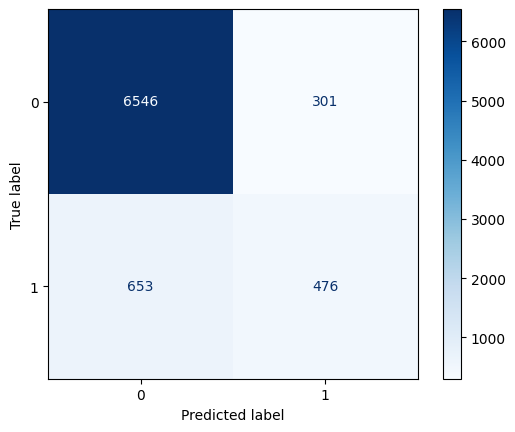

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.6126126126126126|0.8672979587074491|0.4216120460584588|0.49947534102833147|0.8708452264155309|0.8803911735205617|0.6888255936440972|0.4439574958829525


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
run_estimation(
    estimator=logistic_regression_beto_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_logistic_regression_beto.csv',
    model_name='logistic_regression_beto'
)

## GPT


Archivo de resultados GPT cargado

Archivo de resultados GPT cargado
running k-fold cross validation k=10

Archivo de resultados GPT cargado


<ipython-input-76-860615e9bffa>:140: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X_predictions = pd.Series(index=X.index)



Archivo de resultados GPT cargado


<ipython-input-76-860615e9bffa>:140: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X_predictions = pd.Series(index=X.index)



Archivo de resultados GPT cargado


<ipython-input-76-860615e9bffa>:140: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X_predictions = pd.Series(index=X.index)



Archivo de resultados GPT cargado
pos general (de las que restan predecir) 0 de 1499
msg_content
Una frase que vale la pena chequear es aquella que amerita ser chequeada en términos de su probable falsedad en la información, su potencial impacto negativo en la sociedad, individuos, compañías o productos, su relevancia general y la necesidad de la intervención de un profesional que se ocupe de chequearla. Por ejemplo, las frases:
"💬 @Aglezterol: “Ninguna de las CC.AA. consultadas ha recibido ni un euro de los fondos prometidos. Además de ser unos fondos ‘bulo’, son insuficientes👉 si usted divide los 625 mill/€ entre los 47 mill. de habitantes, tocan a cada español 13,29€.  🔴 ¿Creen que es suficiente? https://t.co/1ngXCWXUkf",
"➡ Bajada de impuestos de la señora Ayuso: 16 millones de euros.  ➡ Dinero destinado a los menas: 24 millones de euros.  Se ríen de nosotros. https://t.co/8kwEAtYeS8",
"❌Lo vuelven a hacer.   💶Récord de inflación con subidas históricas en el precio de la luz, comb

<ipython-input-76-860615e9bffa>:140: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X_predictions = pd.Series(index=X.index)



Archivo de resultados GPT cargado
pos general (de las que restan predecir) 0 de 1499
msg_content
Una frase que vale la pena chequear es aquella que amerita ser chequeada en términos de su probable falsedad en la información, su potencial impacto negativo en la sociedad, individuos, compañías o productos, su relevancia general y la necesidad de la intervención de un profesional que se ocupe de chequearla. Por ejemplo, las frases:
"💬 @Aglezterol: “Ninguna de las CC.AA. consultadas ha recibido ni un euro de los fondos prometidos. Además de ser unos fondos ‘bulo’, son insuficientes👉 si usted divide los 625 mill/€ entre los 47 mill. de habitantes, tocan a cada español 13,29€.  🔴 ¿Creen que es suficiente? https://t.co/1ngXCWXUkf",
"➡ Bajada de impuestos de la señora Ayuso: 16 millones de euros.  ➡ Dinero destinado a los menas: 24 millones de euros.  Se ríen de nosotros. https://t.co/8kwEAtYeS8",
"❌Lo vuelven a hacer.   💶Récord de inflación con subidas históricas en el precio de la luz, comb

<ipython-input-76-860615e9bffa>:140: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X_predictions = pd.Series(index=X.index)



Archivo de resultados GPT cargado
pos general (de las que restan predecir) 0 de 1499
msg_content
Una frase que vale la pena chequear es aquella que amerita ser chequeada en términos de su probable falsedad en la información, su potencial impacto negativo en la sociedad, individuos, compañías o productos, su relevancia general y la necesidad de la intervención de un profesional que se ocupe de chequearla. Por ejemplo, las frases:
"💬 @Aglezterol: “Ninguna de las CC.AA. consultadas ha recibido ni un euro de los fondos prometidos. Además de ser unos fondos ‘bulo’, son insuficientes👉 si usted divide los 625 mill/€ entre los 47 mill. de habitantes, tocan a cada español 13,29€.  🔴 ¿Creen que es suficiente? https://t.co/1ngXCWXUkf",
"➡ Bajada de impuestos de la señora Ayuso: 16 millones de euros.  ➡ Dinero destinado a los menas: 24 millones de euros.  Se ríen de nosotros. https://t.co/8kwEAtYeS8",
"❌Lo vuelven a hacer.   💶Récord de inflación con subidas históricas en el precio de la luz, comb

<ipython-input-76-860615e9bffa>:140: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X_predictions = pd.Series(index=X.index)



Archivo de resultados GPT cargado


<ipython-input-76-860615e9bffa>:140: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X_predictions = pd.Series(index=X.index)



Archivo de resultados GPT cargado


<ipython-input-76-860615e9bffa>:140: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X_predictions = pd.Series(index=X.index)



Archivo de resultados GPT cargado


<ipython-input-76-860615e9bffa>:140: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X_predictions = pd.Series(index=X.index)



Archivo de resultados GPT cargado


<ipython-input-76-860615e9bffa>:140: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X_predictions = pd.Series(index=X.index)


# Metricas K-Fold Cross Validation

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.19532710280373833|0.7936770412229225|0.8461538461538461|0.31738800303720577|0.4413905764510079|0.40066666666666667|0.5795015040825097|0.13040770028420787
0.2229064039408867|0.7933844572546838|0.7357723577235772|0.3421550094517959|0.5921549268965479|0.5356904603068713|0.6160904885186123|0.17258909057086552
0.2509457755359395|0.821426048443986|0.8089430894308943|0.38306063522617906|0.6252445591477827|0.5723815877251501|0.6674404194161654|0.24848171949220138
0.23067632850241546|0.8052311266036073|0.7764227642276422|0.35567970204841715|0.5936184156375642|0.5383589059372915|0.6340214379797429|0.1996507424726985
0.232419547079857|0.8077152794438295|0.7894736842105263|0.35911602209944754|0.5903620436849021|0.5356904603068713|0.6375483437027072|0.20558103761702015
0.1816461684011353|0.7612239815820284|0.7773279352226721|0.294478527607362|0.43014237613128037|0.38625750500333556|0.5432166832662881|0.07032074151226708
0.17623762376237623|0.7464096840441563|0.7206477732793523|0.2832140015910899|0.4496467556821191|0.3989326217478319|0.5280555160326474|0.04440008295044716
0.18807339449541285|0.7804448907782205|0.8299595141700404|0.30665669409124907|0.4196171406724428|0.3815877251501001|0.5615452522926879|0.10251803895976627
0.17613636363636365|0.7492384193607696|0.7530364372469636|0.2854950115118956|0.42350938737708244|0.3789192795196798|0.5290741291666128|0.04727739405161389
0.1702728127939793|0.736847531007536|0.7327935222672065|0.2763358778625954|0.4116861381412723|0.3675783855903936|0.5141603394083636|0.023133663969078636
mean: 0.20246415|mean: 0.77955985|mean: 0.77705309|mean: 0.32035795|mean: 0.49773723|mean: 0.44960636|mean: 0.58106541|mean: 0.12443602

<ipython-input-76-860615e9bffa>:140: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  X_predictions = pd.Series(index=X.index)


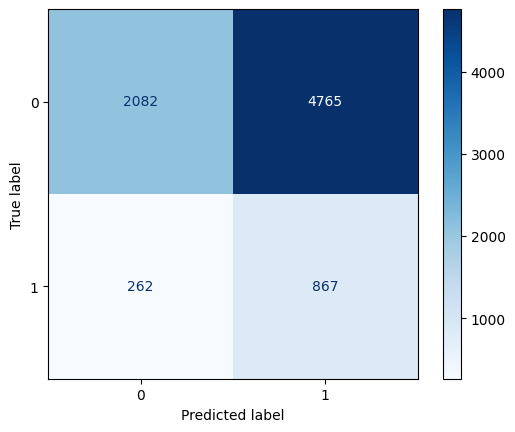

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.15394176136363635|0.7842876850833245|0.7679362267493357|0.2564709362520337|0.42522593238696843|0.36973420260782347|0.5360055020120273|0.05510434878563601


Archivo de resultados guardado en data/final_results_cv.json

Archivo de resultados guardado en data/final_results.json


In [ ]:
gpt_pipeline = Pipeline([
    ('clf', GPTClassifier(model='gpt-3.5-turbo'))
])

run_estimation(
    estimator=gpt_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_gpt.csv',
    model_name='gpt'
)

## GPT Zero-shot

In [ ]:
predicted = pd.read_csv('data/results_gpt_zeroshot.csv', index_col=0, sep='\t')
predicted['class_label']

tweet_id
1296128564090351616    1
1260816850658775042    1
1268857203366256641    1
1188175222026973184    1
1219242938389102592    1
                      ..
1454818788126380037    0
1464547666487132170    1
1458749622592155648    0
1455926135494217729    1
1462757959700729861    0
Name: class_label, Length: 7976, dtype: int64

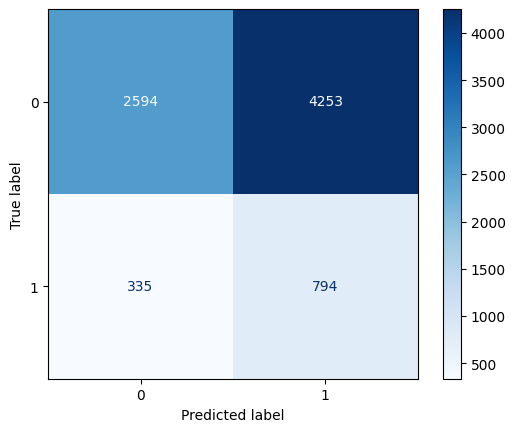

# Metricas Testing

precision|precision_weighted|recall|f1|f1_weighted|accuracy|balanced_accuracy|matthews_corrcoef
---|---|---|---|---|---|---|---
0.15732118089954428|0.7825351323331137|0.7032772364924712|0.2571243523316062|0.4919646446707216|0.4247743229689067|0.5410646442430225|0.05939075648334905

In [ ]:
final_results['gpt_zeroshot'] = run_metrics(test_df['class_label'], predicted['class_label'], [0,1])

## Ensemble

### Voting Ensemble

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [ ]:
ensemble_voting = VotingClassifier(
    estimators=[
        ('clf1', LogisticRegression(class_weight='balanced')),
        ('clf2', SVC(C=1, gamma='scale', kernel='linear', random_state=0)),
        ('clf3', GaussianNB()),
        ('clf4', RandomForestClassifier())
    ],
    voting='hard'
)

ensemble_voting_pipeline = Pipeline([
    ('generate_embeddings', BetoTransformer(
        embeddings_pickle='beto/tweets_embeddings_bert.pickle',
        train_path='data/train.csv',
        test_path='data/test.csv'
    )),
    ('scaler', MinMaxScaler()),
    ('clf', ensemble_voting)
])

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
run_estimation(
    estimator=ensemble_voting_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_ensemble_voting.csv',
    model_name='ensemble_voting'
)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


running k-fold cross validation k=10


### Bagging Ensemble

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
from sklearn.svm import SVC

In [ ]:
ensemble_bagging = BaggingClassifier(
    estimator=SVC(C=1, gamma='scale', kernel='linear', random_state=0),
    n_estimators=10,
    random_state=0
)

ensemble_bagging_pipeline = Pipeline([
    ('generate_embeddings', BetoTransformer(
        embeddings_pickle='beto/tweets_embeddings_bert.pickle',
        train_path='data/train.csv',
        test_path='data/test.csv'
    )),
    ('clf', ensemble_bagging)
])

In [ ]:
run_estimation(
    estimator=ensemble_bagging_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_ensemble_bagging.csv',
    model_name='ensemble_bagging'
)

### Stacking Ensemble

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [ ]:
ensemble_stacking = StackingClassifier(
    estimators=[
        ('clf1', LogisticRegression(class_weight='balanced')),
        ('clf2', SVC(C=1, gamma='scale', kernel='linear', random_state=0)),
        ('clf3', GaussianNB()),
        ('clf4', RandomForestClassifier())
    ]
)

ensemble_stacking_pipeline = Pipeline([
    ('generate_embeddings', BetoTransformer(
        embeddings_pickle='beto/tweets_embeddings_bert.pickle',
        train_path='data/train.csv',
        test_path='data/test.csv'
    )),
    ('scaler', MinMaxScaler()),
    ('clf', ensemble_stacking)
])

In [ ]:
run_estimation(
    estimator=ensemble_stacking_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_ensemble_stacking.csv',
    model_name='ensemble_stacking'
)

### Boosting Ensemble

#### AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
ensemble_adaboost = AdaBoostClassifier(
    estimator=LogisticRegression(class_weight='balanced')
)

ensemble_adaboost_pipeline = Pipeline([
    ('generate_embeddings', BetoTransformer(
        embeddings_pickle='beto/tweets_embeddings_bert.pickle',
        train_path='data/train.csv',
        test_path='data/test.csv'
    )),
    ('clf', ensemble_adaboost)
])

In [ ]:
run_estimation(
    estimator=ensemble_adaboost_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_ensemble_adaboost.csv',
    model_name='ensemble_adaboost'
)

#### GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
ensemble_gradientboosting_pipeline = Pipeline([
    ('generate_embeddings', BetoTransformer(
        embeddings_pickle='beto/tweets_embeddings_bert.pickle',
        train_path='data/train.csv',
        test_path='data/test.csv'
    )),
    ('clf', GradientBoostingClassifier())
])

In [ ]:
run_estimation(
    estimator=ensemble_gradientboosting_pipeline,
    data_fpath='data/train.csv',
    test_fpath='data/test.csv',
    complete_fpath='data/complete.csv',
    results_fpath='data/results_ensemble_gradientboosting.csv',
    model_name='ensemble_gradientboosting'
)

## Model evaluation

In [8]:
import scipy.stats as stats

In [9]:
def paired_test(n_of_test, metric, model1, model2):
    scores1 = final_results_cv[model1][metric]['scores']
    scores2 = final_results_cv[model2][metric]['scores']

    _, pvalue1 = stats.normaltest(scores1)
    _, pvalue2 = stats.normaltest(scores2)

    if pvalue1 > 0.05 and pvalue2 > 0.05:  # en ambos no se rechaza normalidad
        stat, pvalue = stats.ttest_rel(scores1, scores2)
        test_name = f"Prueba {n_of_test}: t-test"
    else:  # en al menos uno se rechaza normalidad
        stat, pvalue = stats.wilcoxon(scores1, scores2)
        test_name = f"Prueba {n_of_test}: Wilcoxon"

    print(f"{test_name} entre {model1} y {model2} para métrica {metric} resulta en estadístico={stat}, p-value={pvalue}\n")
    #return stat, pvalue

In [10]:
from itertools import combinations

In [16]:
model_names = list(final_results_cv.keys())
model_names = [model_name for model_name in model_names if 'random' not in model_name and 'majority' not in model_name]

# combinations me arma un iterador con los pares entre los modelos
n_of_test = 1
for model1, model2 in combinations(model_names, 2):
    target_metrics = final_results_cv[model1].keys()

    for metric in target_metrics:
        n_of_test += 1
        paired_test(n_of_test, metric, model1, model2)

Prueba 2: Wilcoxon entre svc_tfidf y svc_w2vec para métrica precision resulta en estadístico=19.0, p-value=0.431640625

Prueba 3: Wilcoxon entre svc_tfidf y svc_w2vec para métrica precision_weighted resulta en estadístico=0.0, p-value=0.001953125

Prueba 4: Wilcoxon entre svc_tfidf y svc_w2vec para métrica recall resulta en estadístico=0.0, p-value=0.001953125

Prueba 5: t-test entre svc_tfidf y svc_w2vec para métrica f1 resulta en estadístico=11.150135664628447, p-value=1.4358758004994e-06

Prueba 6: Wilcoxon entre svc_tfidf y svc_w2vec para métrica f1_weighted resulta en estadístico=2.0, p-value=0.005859375

Prueba 7: Wilcoxon entre svc_tfidf y svc_w2vec para métrica accuracy resulta en estadístico=10.0, p-value=0.083984375

Prueba 8: t-test entre svc_tfidf y svc_w2vec para métrica balanced_accuracy resulta en estadístico=14.87759428066112, p-value=1.211284229368382e-07

Prueba 9: Wilcoxon entre svc_tfidf y svc_w2vec para métrica matthews_corrcoef resulta en estadístico=0.0, p-value=

In [ ]:
paired_test('precision', 'svc_tfidf', 'svc_w2vec')

Prueba de Wilcoxon entre svc_tfidf y svc_w2vec para métrica precision resulta en estadístico=2.0, p-value=0.005859375



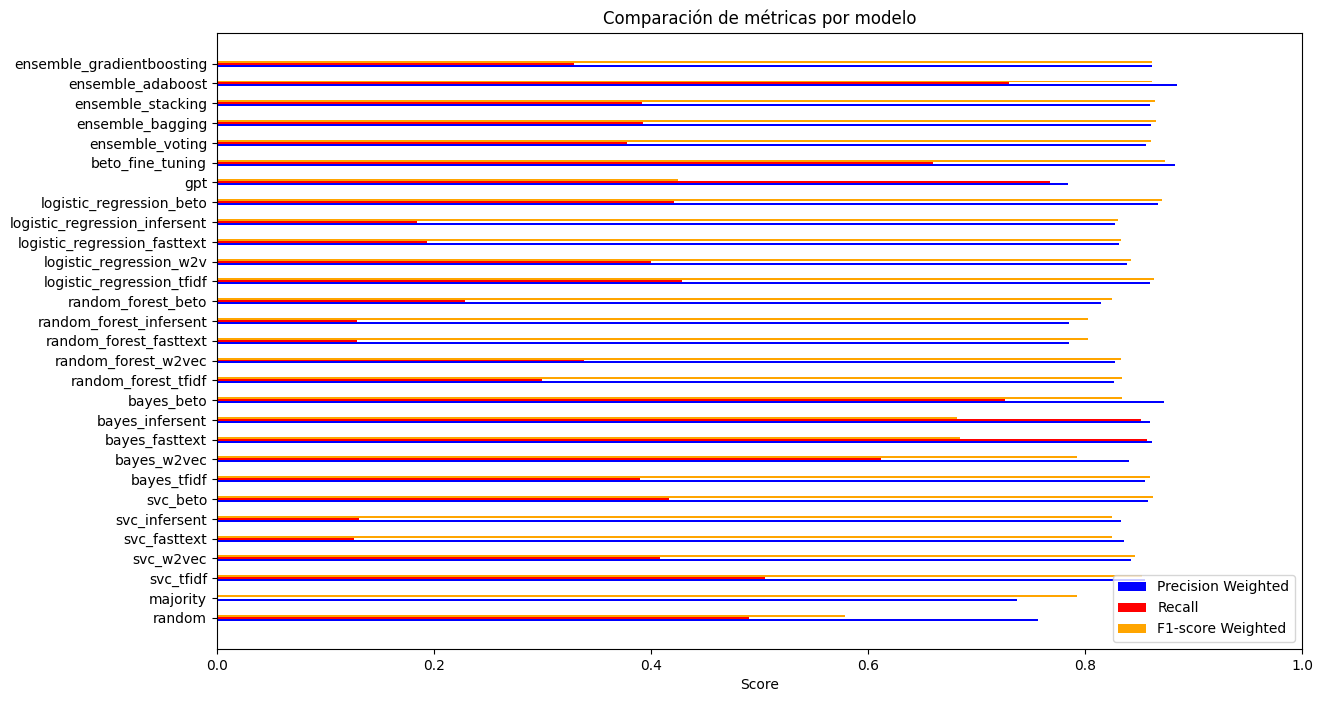

In [21]:
import matplotlib.pyplot as plt
import numpy as np

metrics = final_results

# Preparando los datos para la visualización
models = list(metrics.keys())
precision_weighted = [float(metrics[model]['precision_weighted']) for model in models]
recall = [float(metrics[model]['recall']) for model in models]
f1_weighted = [float(metrics[model]['f1_weighted']) for model in models]

# Tamaño de las barras
bar_height = 0.1

# Configurar las posiciones de las barras en el eje Y
y_positions = np.arange(len(models))

# Crear el gráfico de barras
plt.figure(figsize=(14, 8))  # Ajustar el tamaño de la figura

# Dibujar las barras
plt.barh(y_positions - bar_height, precision_weighted, height=bar_height, color='blue', label='Precision Weighted')
plt.barh(y_positions, recall, height=bar_height, color='red', label='Recall')
plt.barh(y_positions + bar_height, f1_weighted, height=bar_height, color='orange', label='F1-score Weighted')

# Añadir las etiquetas para cada grupo de barras
plt.yticks(y_positions, models)

# Añadir las leyendas y títulos
plt.xlabel('Score')
plt.title('Comparación de métricas por modelo')
plt.legend()

# Ajustar los límites si es necesario
plt.xlim(0, 1)

# Mostrar el gráfico
plt.show()


# Final results to csv

In [ ]:
final_results

{'random': {'precision': '0.1412904871206325',
  'precision_weighted': '0.7567214984235856',
  'recall': '0.49069973427812225',
  'recall_weighted': '0.5057673019057171',
  'f1': '0.2194059405940594',
  'f1_weighted': '0.5791043887505298',
  'accuracy': '0.5057673019057172',
  'balanced_accuracy': '0.49947576169141983',
  'mcc [-1,1]': '-0.0007310751699104152'},
 'majority': {'precision': '0.0',
  'precision_weighted': '0.7369370052232928',
  'recall': '0.0',
  'recall_weighted': '0.8584503510531595',
  'f1': '0.0',
  'f1_weighted': '0.7930661207125391',
  'accuracy': '0.8584503510531595',
  'balanced_accuracy': '0.5',
  'mcc [-1,1]': '0.0'},
 'beto-fine-tuning': {'precision': '0.5261299435028248',
  'precision_weighted': '0.8826731075996351',
  'recall': '0.6598759964570416',
  'recall_weighted': '0.867728184553661',
  'f1': '0.5854616895874262',
  'f1_weighted': '0.8737705865865772',
  'accuracy': '0.867728184553661',
  'balanced_accuracy': '0.7809384363766149',
  'mcc [-1,1]': '0.51

In [ ]:
metrics_names = ['precision', 'precision_weighted', 'recall', 'recall_weighted', 'f1', 'f1_weighted', 'accuracy', 'balanced_accuracy', 'mcc [-1,1]']
header = '\t' + '\t'.join(metrics_names) + '\n'

with open('data/final_results.csv', "w") as final_results_file:
    final_results_file.write(header)

    for model, metrics in final_results.items():
        line = model + '\t' + '\t'.join(metrics.values()) + '\n'
        final_results_file.write(line)


In [ ]:
final_results[model_name] = run_metrics(test_df['class_label'], predicted, estimator.classes_)